In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [6]:
run_grid_simulation = True # If true takes much longer and does 3D plots and so on for MODEL with 2 FEATS
run_sensitivity_with_simulator = True
m4_evaluate = True



We consider missiles with only 1 stage

In [7]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [8]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

# 0. Only one param - m0

In [9]:
m0_param_1 = 'fuelmass'
m0_domain_param_1 = basic_param_spaces[m0_param_1] # [500, 6000] # [5000,15000]

m0_space = ParameterSpace(
          [ContinuousParameter(m0_param_1, *m0_domain_param_1), 
          ])

custom_param_names = [m0_param_1]

In [10]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



New simulation 

fuelmass: 3254.1475877968605


Stage 1 burnout
Velocity (km/s):  1.5810258774504424
Angle (deg h):  43.648391881332145
Range (km):  23.648750401967256
Time (sec):  80.19999999999972
Final results: 
Range (km):  320.06887398907514
Apogee (km):  100.94572051623904
Time to target (sec):  343.70000000000965




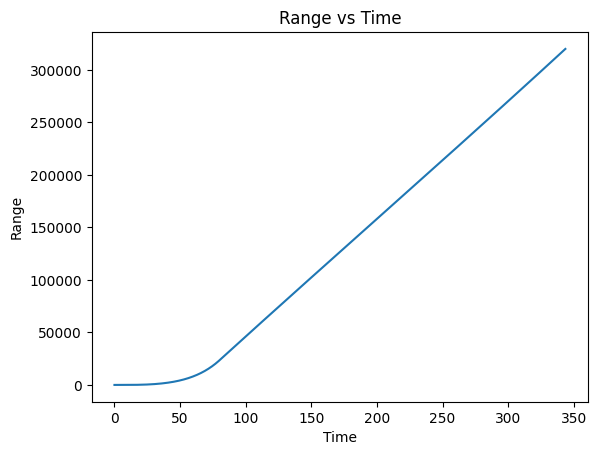

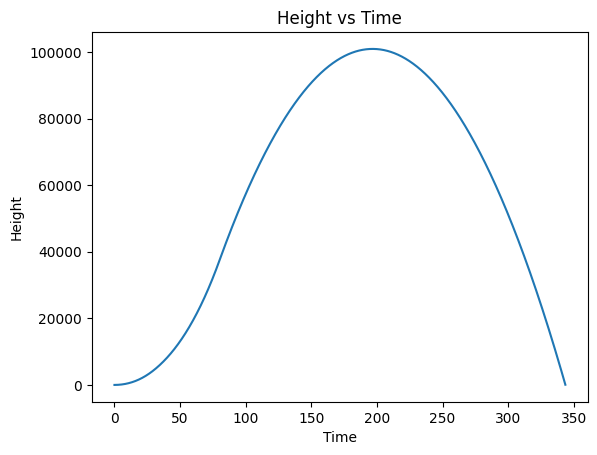

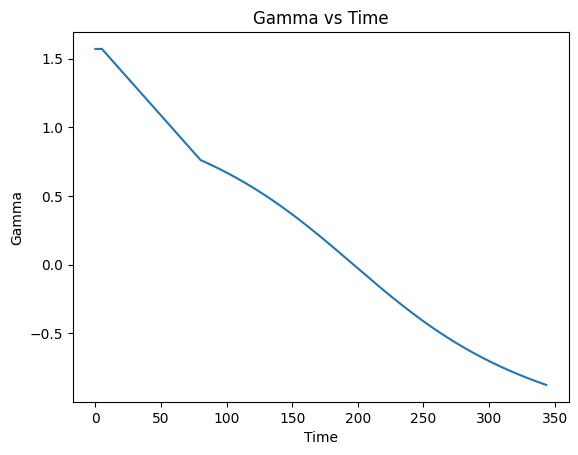

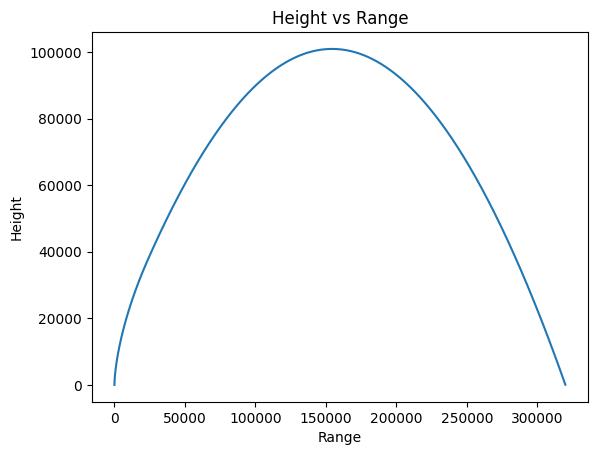

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 1255.0000419728087


Stage 1 burnout
Velocity (km/s):  0.8140744577106309
Angle (deg h):  43.66023179512973
Range (km):  5.3987830624743784
Time (sec):  30.900000000000173
Final results: 
Range (km):  82.56537047950391
Apogee (km):  26.182318233900535
Time to target (sec):  162.49999999999505




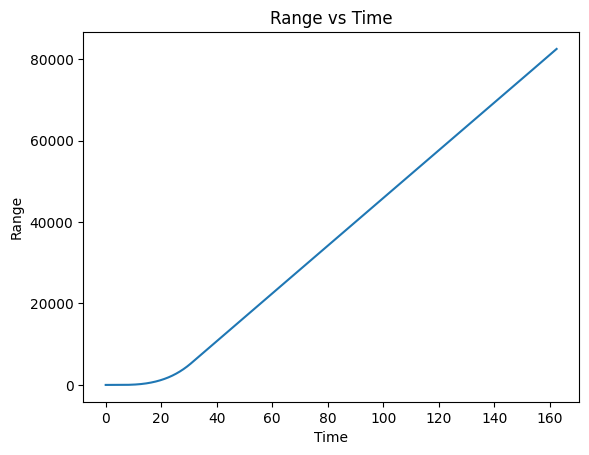

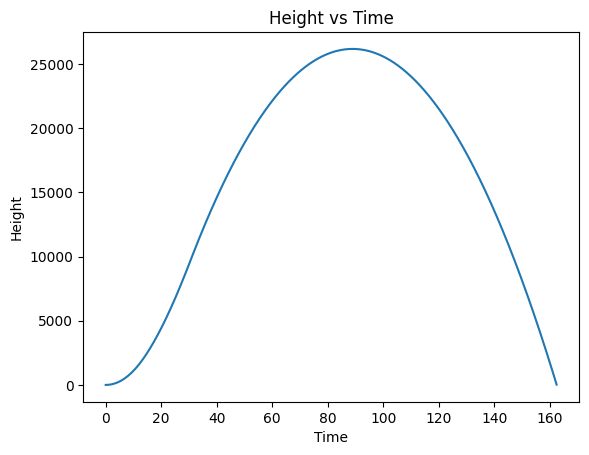

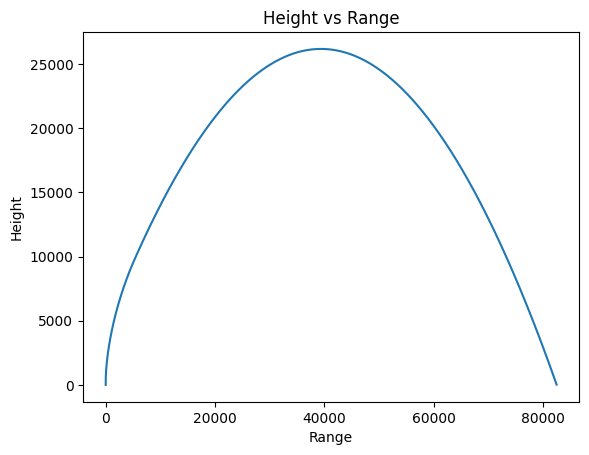

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 1638.6595409154404


Stage 1 burnout
Velocity (km/s):  0.9854831824977424
Angle (deg h):  43.67999040348672
Range (km):  8.420621000116478
Time (sec):  40.400000000000304
Final results: 
Range (km):  122.00381646457747
Apogee (km):  38.755450194561405
Time to target (sec):  200.79999999999288




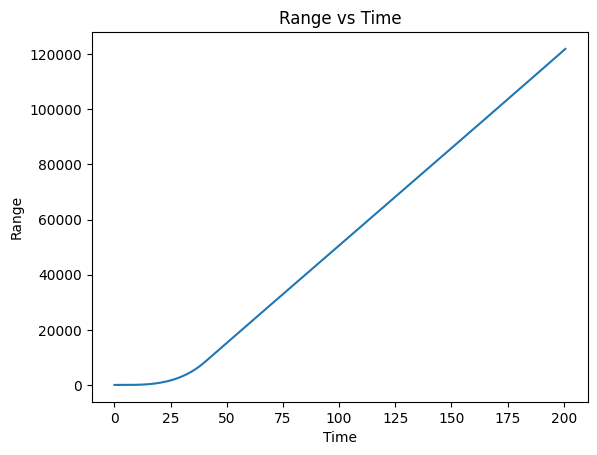

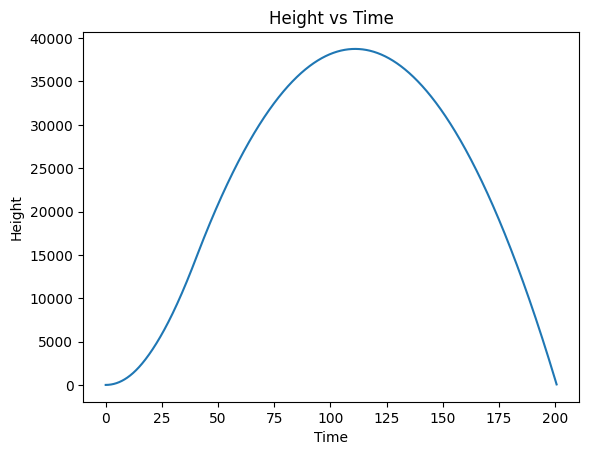

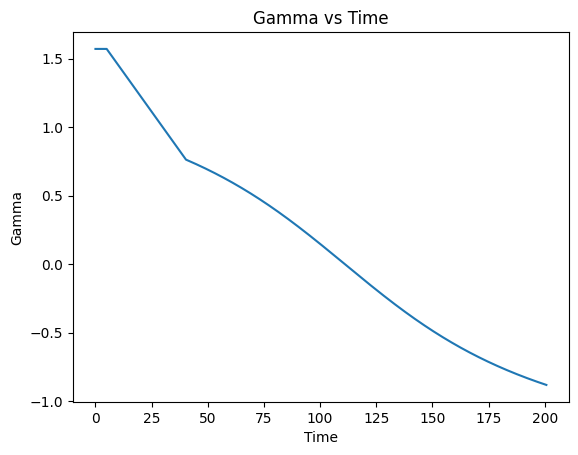

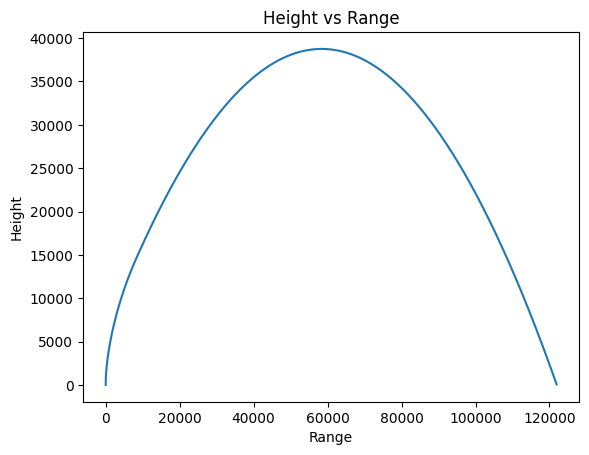

Data written to 'results/results_2.txt'


In [11]:
# Get true points (to build model)
wirte_output_txt = True

m0_design = RandomDesign(m0_space)
m0_x = m0_design.get_samples(3)
m0_y = run_missile_sim(m0_x)

In [12]:
# Build model
m0_var_kernel = (100)**2 
m0_lengthscale = 100 # 1
m0_var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m0_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)


constrain_lengthscale = False

m0_rbf_kern = GPy.kern.RBF(input_dim=1, lengthscale=m0_lengthscale)
if constrain_lengthscale:
    m0_rbf_kern.lengthscale.constrain_bounded(m0_lengthscale, m0_lengthscale*1e12)

m0_kern = m0_rbf_kern + \
    GPy.kern.Linear(input_dim=1)


m0_model_gpy = GPRegression(m0_x,m0_y, kernel=m0_kern)
m0_model_gpy.kern.variance =  m0_var_kernel 
m0_model_gpy.likelihood.variance.fix(m0_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m0_model_gpy)



In [13]:
# Fit emulator
m0_model_emukit = GPyModelWrapper(m0_model_gpy)
m0_model_emukit.optimize() # Optimize model hyperparameters



In [14]:
display(m0_model_gpy)

In [15]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False

nr_points_plot = 301
m0_param_1_x_plot = np.linspace(m0_space.parameters[0].min, m0_space.parameters[0].max, nr_points_plot)[:, None]
m0_param_1_y_plot = run_missile_sim(m0_param_1_x_plot)




New simulation 

fuelmass: 500.0


Stage 1 burnout
Velocity (km/s):  0.4265056287972526
Angle (deg h):  43.732284489193205
Range (km):  0.9440400159604505
Time (sec):  12.299999999999974
Final results: 
Range (km):  21.661219962904816
Apogee (km):  6.737492515662497
Time to target (sec):  79.59999999999975



New simulation 

fuelmass: 518.3333333333334


Stage 1 burnout
Velocity (km/s):  0.43905877485586203
Angle (deg h):  43.94232680213815
Range (km):  1.037682082180261
Time (sec):  12.799999999999972
Final results: 
Range (km):  23.013791615632808
Apogee (km):  7.19665589314658
Time to target (sec):  82.3999999999996



New simulation 

fuelmass: 536.6666666666666


Stage 1 burnout
Velocity (km/s):  0.44799024767022866
Angle (deg h):  43.73993108354109
Range (km):  1.1013774296045882
Time (sec):  13.19999999999997
Final results: 
Range (km):  24.02034604907838
Apogee (km):  7.485179947127214
Time to target (sec):  84.0999999999995



New simulation 

fuelmass: 555.0


Stage 1 burno

Final results: 
Range (km):  67.40006304156974
Apogee (km):  21.344939443798882
Time to target (sec):  145.699999999996



New simulation 

fuelmass: 1105.0


Stage 1 burnout
Velocity (km/s):  0.7444357860029703
Angle (deg h):  43.67461673135336
Range (km):  4.3408570642132
Time (sec):  27.20000000000012
Final results: 
Range (km):  68.664093576499
Apogee (km):  21.751216727163865
Time to target (sec):  147.09999999999593



New simulation 

fuelmass: 1123.3333333333333


Stage 1 burnout
Velocity (km/s):  0.7547895811826383
Angle (deg h):  43.726071767921454
Range (km):  4.49237733290142
Time (sec):  27.700000000000127
Final results: 
Range (km):  70.62512765184988
Apogee (km):  22.395426877698082
Time to target (sec):  149.3999999999958



New simulation 

fuelmass: 1141.6666666666665


Stage 1 burnout
Velocity (km/s):  0.7615111610233133
Angle (deg h):  43.67958738995111
Range (km):  4.590462022329887
Time (sec):  28.100000000000133
Final results: 
Range (km):  71.96332540119403
Apog

Final results: 
Range (km):  129.28352858817843
Apogee (km):  41.057102397684474
Time to target (sec):  207.2999999999925



New simulation 

fuelmass: 1728.3333333333333


Stage 1 burnout
Velocity (km/s):  1.0232816569266785
Angle (deg h):  43.68767848864017
Range (km):  9.165024959476336
Time (sec):  42.600000000000335
Final results: 
Range (km):  131.73175939426795
Apogee (km):  41.85434683536408
Time to target (sec):  209.3999999999924



New simulation 

fuelmass: 1746.6666666666665


Stage 1 burnout
Velocity (km/s):  1.0289506326429567
Angle (deg h):  43.66654519901828
Range (km):  9.282256420400048
Time (sec):  43.00000000000034
Final results: 
Range (km):  133.30161291762843
Apogee (km):  42.33594069385965
Time to target (sec):  210.7999999999923



New simulation 

fuelmass: 1765.0


Stage 1 burnout
Velocity (km/s):  1.0385936324681495
Angle (deg h):  43.69004717234428
Range (km):  9.474532808727448
Time (sec):  43.50000000000035
Final results: 
Range (km):  135.78244350228061

Stage 1 burnout
Velocity (km/s):  1.230496143758119
Angle (deg h):  43.653238987569395
Range (km):  13.713592522189654
Time (sec):  55.200000000000514
Final results: 
Range (km):  191.74608606647126
Apogee (km):  60.72805885861445
Time to target (sec):  257.19999999999



New simulation 

fuelmass: 2260.0


Stage 1 burnout
Velocity (km/s):  1.2398603766516205
Angle (deg h):  43.668508109890624
Range (km):  13.928231499912085
Time (sec):  55.70000000000052
Final results: 
Range (km):  194.6618929821797
Apogee (km):  61.64244527973966
Time to target (sec):  259.29999999999046



New simulation 

fuelmass: 2278.333333333333


Stage 1 burnout
Velocity (km/s):  1.2447819152231097
Angle (deg h):  43.655864854308206
Range (km):  14.053964066848199
Time (sec):  56.10000000000053
Final results: 
Range (km):  196.33140449684205
Apogee (km):  62.15478141711491
Time to target (sec):  260.59999999999076



New simulation 

fuelmass: 2296.6666666666665


Stage 1 burnout
Velocity (km/s):  1.254104472

Range (km):  254.64070309442425
Apogee (km):  80.47607875468076
Time to target (sec):  301.40000000000003



New simulation 

fuelmass: 2755.0


Stage 1 burnout
Velocity (km/s):  1.4231967645190102
Angle (deg h):  43.65571037302037
Range (km):  18.70512511424092
Time (sec):  67.90000000000042
Final results: 
Range (km):  257.7257449040164
Apogee (km):  81.35307986197594
Time to target (sec):  303.20000000000044



New simulation 

fuelmass: 2773.333333333333


Stage 1 burnout
Velocity (km/s):  1.427069690060069
Angle (deg h):  43.69326929044682
Range (km):  18.83232983596492
Time (sec):  68.3000000000004
Final results: 
Range (km):  259.24771961642153
Apogee (km):  81.9252589007249
Time to target (sec):  304.50000000000074



New simulation 

fuelmass: 2791.6666666666665


Stage 1 burnout
Velocity (km/s):  1.4355514392392486
Angle (deg h):  43.657649840081355
Range (km):  19.06255750694612
Time (sec):  68.80000000000037
Final results: 
Range (km):  262.34585942714125
Apogee (km):  82.8

Final results: 
Range (km):  316.5013852238001
Apogee (km):  99.91574941392187
Time to target (sec):  341.7000000000092



New simulation 

fuelmass: 3250.0


Stage 1 burnout
Velocity (km/s):  1.5799274847071405
Angle (deg h):  43.64708220753839
Range (km):  23.610143463859504
Time (sec):  80.09999999999972
Final results: 
Range (km):  319.6135197313673
Apogee (km):  100.79444827914536
Time to target (sec):  343.4000000000096



New simulation 

fuelmass: 3268.333333333333


Stage 1 burnout
Velocity (km/s):  1.5827710302883793
Angle (deg h):  43.67862473993936
Range (km):  23.732862287574672
Time (sec):  80.4999999999997
Final results: 
Range (km):  320.87665162782696
Apogee (km):  101.30930344900209
Time to target (sec):  344.50000000000983



New simulation 

fuelmass: 3286.6666666666665


Stage 1 burnout
Velocity (km/s):  1.5903363815192733
Angle (deg h):  43.648810282686895
Range (km):  23.96947910853838
Time (sec):  80.99999999999967
Final results: 
Range (km):  323.9952408914824


Stage 1 burnout
Velocity (km/s):  1.7052149195551742
Angle (deg h):  43.6667221386163
Range (km):  28.24017899589675
Time (sec):  91.79999999999906
Final results: 
Range (km):  374.7474299756555
Apogee (km):  118.36965644858246
Time to target (sec):  378.3000000000175



New simulation 

fuelmass: 3745.0


Stage 1 burnout
Velocity (km/s):  1.7120353170230982
Angle (deg h):  43.640826984765546
Range (km):  28.477268374053
Time (sec):  92.29999999999903
Final results: 
Range (km):  377.8062639054711
Apogee (km):  119.22816570769305
Time to target (sec):  379.9000000000179



New simulation 

fuelmass: 3763.333333333333


Stage 1 burnout
Velocity (km/s):  1.7139988578684504
Angle (deg h):  43.66801323888249
Range (km):  28.59112490701802
Time (sec):  92.69999999999901
Final results: 
Range (km):  378.74441178709185
Apogee (km):  119.66970031501373
Time to target (sec):  380.8000000000181



New simulation 

fuelmass: 3781.6666666666665


Stage 1 burnout
Velocity (km/s):  1.720763721465991

Final results: 
Range (km):  425.4589569153098
Apogee (km):  134.55454850859368
Time to target (sec):  410.0000000000247



New simulation 

fuelmass: 4221.666666666666


Stage 1 burnout
Velocity (km/s):  1.8172517896895022
Angle (deg h):  43.65875187248439
Range (km):  32.948084136397526
Time (sec):  103.99999999999837
Final results: 
Range (km):  428.35932314107947
Apogee (km):  135.46056650520958
Time to target (sec):  411.6000000000251



New simulation 

fuelmass: 4240.0


Stage 1 burnout
Velocity (km/s):  1.8185121188671796
Angle (deg h):  43.656873589495156
Range (km):  33.050371406448896
Time (sec):  104.39999999999834
Final results: 
Range (km):  429.11856982767335
Apogee (km):  135.74506834585645
Time to target (sec):  412.30000000002525



New simulation 

fuelmass: 4258.333333333333


Stage 1 burnout
Velocity (km/s):  1.8246285685877355
Angle (deg h):  43.65995449880955
Range (km):  33.28291758469607
Time (sec):  104.89999999999831
Final results: 
Range (km):  432.020004342

Final results: 
Range (km):  476.8057966920597
Apogee (km):  150.9150885698353
Time to target (sec):  442.000000000032



New simulation 

fuelmass: 4735.0


Stage 1 burnout
Velocity (km/s):  1.9118264722036735
Angle (deg h):  43.65194438617434
Range (km):  37.4899911678009
Time (sec):  116.59999999999765
Final results: 
Range (km):  477.15524814815024
Apogee (km):  151.1156479620061
Time to target (sec):  442.5000000000321



New simulation 

fuelmass: 4753.333333333333


Stage 1 burnout
Velocity (km/s):  1.9173471571838383
Angle (deg h):  43.65360713180984
Range (km):  37.71462361349822
Time (sec):  117.09999999999762
Final results: 
Range (km):  480.0644208000098
Apogee (km):  151.96970958572982
Time to target (sec):  444.1000000000325



New simulation 

fuelmass: 4771.666666666666


Stage 1 burnout
Velocity (km/s):  1.9179013290525495
Angle (deg h):  43.65314757328279
Range (km):  37.801354458312076
Time (sec):  117.4999999999976
Final results: 
Range (km):  480.4034501221844
Apog

Final results: 
Range (km):  519.34264314737
Apogee (km):  164.53583262376424
Time to target (sec):  469.50000000003826



New simulation 

fuelmass: 5230.0


Stage 1 burnout
Velocity (km/s):  1.989362681002887
Angle (deg h):  43.666640324488895
Range (km):  41.59695439532111
Time (sec):  128.79999999999697
Final results: 
Range (km):  519.5367114103914
Apogee (km):  164.71973075097623
Time to target (sec):  470.1000000000384



New simulation 

fuelmass: 5248.333333333333


Stage 1 burnout
Velocity (km/s):  1.9943607949535647
Angle (deg h):  43.64846023673593
Range (km):  41.81060996186811
Time (sec):  129.29999999999694
Final results: 
Range (km):  522.1588049724447
Apogee (km):  165.4476201011053
Time to target (sec):  471.4000000000387



New simulation 

fuelmass: 5266.666666666666


Stage 1 burnout
Velocity (km/s):  1.9943458628851896
Angle (deg h):  43.66753923153275
Range (km):  41.880856097265934
Time (sec):  129.69999999999692
Final results: 
Range (km):  522.3439771826243
Ap

Final results: 
Range (km):  553.4411088153283
Apogee (km):  175.5032766468458
Time to target (sec):  493.20000000004364



New simulation 

fuelmass: 5706.666666666666


Stage 1 burnout
Velocity (km/s):  2.053301452536527
Angle (deg h):  43.64321115249556
Range (km):  45.25400084550494
Time (sec):  140.5999999999963
Final results: 
Range (km):  556.0126077988738
Apogee (km):  176.1767472510465
Time to target (sec):  494.50000000004394



New simulation 

fuelmass: 5725.0


Stage 1 burnout
Velocity (km/s):  2.052799425282958
Angle (deg h):  43.66072083569242
Range (km):  45.307419552055244
Time (sec):  140.99999999999628
Final results: 
Range (km):  555.9340042472603
Apogee (km):  176.2657308090352
Time to target (sec):  495.00000000004405



New simulation 

fuelmass: 5743.333333333333


Stage 1 burnout
Velocity (km/s):  2.057321312765397
Angle (deg h):  43.64418388443078
Range (km):  45.507416610882075
Time (sec):  141.49999999999625
Final results: 
Range (km):  558.3504734667251
Apo

In [16]:
# Get model prediction on param_1_x_plot
m0_mu_plot, m0_var_plot = m0_model_emukit.predict(m0_param_1_x_plot)



In [17]:
# Plot
def helper_plot_emulator_errorbars(x_plot, y_plot, mu_plot, var_plot, model_emukit):
    """Helper function for plotting the emulator fit."""
    ax.plot(model_emukit.X[:, 0], model_emukit.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot[:, 0], mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot[:, 0], y_plot, 'k', label='target function', linewidth=2)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel(custom_param_names[0])
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
    

RMSE m0 (pre experiment design loop):  21.147593824297896


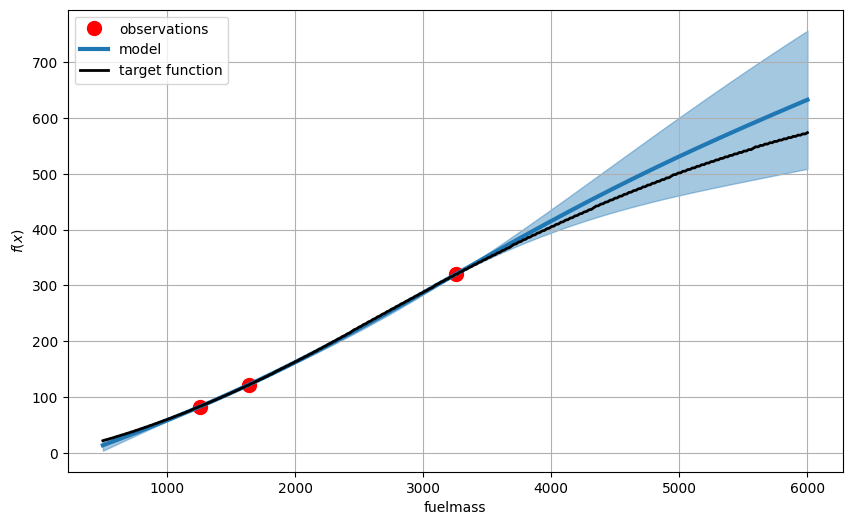

In [18]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m0_param_1_x_plot, y_plot=m0_param_1_y_plot, 
                               mu_plot=m0_mu_plot, var_plot=m0_var_plot, 
                               model_emukit=m0_model_emukit)

m0_rmse = evaluate_prediction(y_actual=m0_param_1_y_plot, y_predicted=m0_mu_plot)
print("RMSE m0 (pre experiment design loop): ", m0_rmse)

### Experiment design loop

In [19]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance

In [20]:
m0_2_model_emukit = m0_model_emukit

In [21]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m0_space,
                                                  model=m0_2_model_emukit)
m0_ed = ExperimentalDesignLoop(space=m0_space, 
                            model=m0_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m0_ed.run_loop(user_function=run_missile_sim, stopping_condition=5)



 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 5409.2231023528975


Stage 1 burnout
Velocity (km/s):  2.0130350690502405
Angle (deg h):  43.65296221371254
Range (km):  42.96446887418858
Time (sec):  133.19999999999672
Final results: 
Range (km):  533.0281762578508
Apogee (km):  168.9739390987284
Time to target (sec):  479.20000000004046



New simulation 

fuelmass: 4708.003583675361


Stage 1 burnout
Velocity (km/s):  1.9103904877915012
Angle (deg h):  43.64694639969381
Range (km):  37.34529714972768
Time (sec):  115.99999999999768
Final results: 
Range (km):  476.3406552866186
Apogee (km):  150.7278490225545
Time to target (sec):  441.6000000000319



New simulation 

fuelmass: 2926.7873625095503


Stage 1 burnout
Velocity (km/s):  1.4790025609265112
Angle (deg h):  43.675805204425544
Range (km):  20.36612443338966
Time (sec):  72.10000000000018
Final results: 
Range (km):  278.94016539985404
Apogee (km):  88.06895714282001
Time to target (sec):  317.4000000000037



New simulation 

fuelmass: 4240.692

In [22]:
m0_2_mu_plot, m0_2_var_plot = m0_2_model_emukit.predict(m0_param_1_x_plot)



RMSE m0 (post experiment design loop):  0.9916964944598599


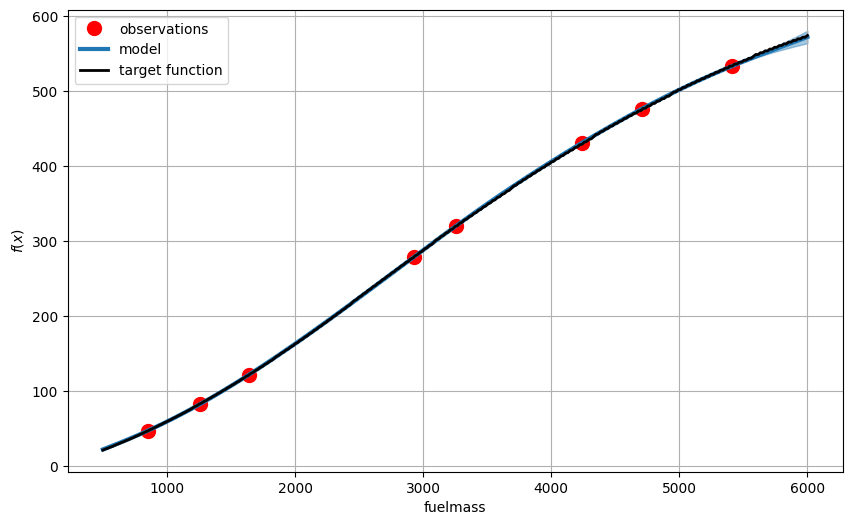

In [23]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m0_param_1_x_plot, y_plot=m0_param_1_y_plot, 
                               mu_plot=m0_2_mu_plot, var_plot=m0_2_var_plot, 
                               model_emukit=m0_2_model_emukit)

m0_2_rmse = evaluate_prediction(y_actual=m0_param_1_y_plot, y_predicted=m0_2_mu_plot)
print("RMSE m0 (post experiment design loop): ", m0_2_rmse)

# 0. Only one param - m1

In [ ]:
m1_param_1 = 'Isp0'
m1_domain_param_1 = basic_param_spaces[m1_param_1] # [500, 6000] # [5000,15000]

m1_space = ParameterSpace(
          [ContinuousParameter(m1_param_1, *m1_domain_param_1), 
          ])

custom_param_names = [m1_param_1]

In [ ]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


In [ ]:
# Get true points (to build model)
wirte_output_txt = True

m1_design = RandomDesign(m1_space)
m1_x = m1_design.get_samples(3)
m1_y = run_missile_sim(m1_x)

In [ ]:
# Build model
m1_var_kernel = (100)**2 
m1_lengthscale = 100 # 1
m1_var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m1_var_noise = 1e-5 # small value
# In catapult: 1e-5

constrain_lengthscale = True

#kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
m1_rbf_kern = GPy.kern.RBF(input_dim=1, lengthscale=m1_lengthscale)
if constrain_lengthscale:
    m1_rbf_kern.lengthscale.constrain_bounded(m1_lengthscale, m1_lengthscale*1e12)

m1_kern = m1_rbf_kern + \
    GPy.kern.Linear(input_dim=1)
# m1_kern = m1_rbf_kern 

m1_model_gpy = GPRegression(m1_x,m1_y, kernel=m1_kern)
m1_model_gpy.kern.variance =  m1_var_kernel 
m1_model_gpy.likelihood.variance.fix(m1_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m1_model_gpy)



In [ ]:
# Fit emulator
m1_model_emukit = GPyModelWrapper(m1_model_gpy)
m1_model_emukit.optimize() # Optimize model hyperparameters



In [ ]:
display(m1_model_gpy)

In [ ]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False

nr_points_plot = 301
m1_param_1_x_plot = np.linspace(m1_space.parameters[0].min, m1_space.parameters[0].max, nr_points_plot)[:, None]
m1_param_1_y_plot = run_missile_sim(m1_param_1_x_plot)



In [ ]:
# Get model prediction on param_1_x_plot
m1_mu_plot, m1_var_plot = m1_model_emukit.predict(m1_param_1_x_plot)



In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m1_param_1_x_plot, y_plot=m1_param_1_y_plot, 
                               mu_plot=m1_mu_plot, var_plot=m1_var_plot, 
                               model_emukit=m1_model_emukit)

m1_rmse = evaluate_prediction(y_actual=m1_param_1_y_plot, y_predicted=m1_mu_plot)
print("RMSE m1 (pre experiment design loop): ", m1_rmse)

### Experiment design loop

In [33]:
m1_2_model_emukit = m1_model_emukit

In [34]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m1_space,
                                                  model=m1_2_model_emukit)
m1_ed = ExperimentalDesignLoop(space=m1_space, 
                            model=m1_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m1_ed.run_loop(user_function=run_missile_sim, stopping_condition=5)



 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

Isp0: 240.30321148954494


Stage 1 burnout
Velocity (km/s):  2.19439836486553
Angle (deg h):  43.64447046207184
Range (km):  50.68710299359993
Time (sec):  146.69999999999595
Final results: 
Range (km):  636.3143288381897
Apogee (km):  201.2161547047774
Time to target (sec):  528.0000000000515



New simulation 

Isp0: 299.02493082188136


Stage 1 burnout
Velocity (km/s):  2.8647472384493793
Angle (deg h):  43.655498711004135
Range (km):  80.93542401907756
Time (sec):  182.49999999999392
Final results: 
Range (km):  1105.1300427955696
Apogee (km):  347.6604461641542
Time to target (sec):  706.200000000092



New simulation 

Isp0: 142.52334280008526


Stage 1 burnout
Velocity (km/s):  1.1857866550460192
Angle (deg h):  43.655367926086726
Range (km):  16.844301960869487
Time (sec):  86.99999999999933
Final results: 
Range (km):  185.15300320114406
Apogee (km):  60.15087859463482
Time to target (sec):  285.0999999999963



New simulation 

Isp0: 653.2956671809936


Stag

In [35]:
m1_2_mu_plot, m1_2_var_plot = m1_2_model_emukit.predict(m1_param_1_x_plot)



In [36]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m1_param_1_x_plot, y_plot=m1_param_1_y_plot, 
                               mu_plot=m1_2_mu_plot, var_plot=m1_2_var_plot, 
                               model_emukit=m1_2_model_emukit)

m1_2_rmse = evaluate_prediction(y_actual=m1_param_1_y_plot, y_predicted=m1_2_mu_plot)
print("RMSE m1 (post experiment design loop): ", m1_2_rmse)

RMSE m1 (post experiment design loop):  207.30718323874433


# 1. Two params

In [37]:
m2_param_1 = 'fuelmass'
m2_domain_param_1 = basic_param_spaces[m2_param_1] # [500, 6000] # [5000,15000]
m2_param_2 = 'Isp0'
m2_domain_param_2 = basic_param_spaces[m2_param_2] # [200, 300] # [224, 228]

m2_space = ParameterSpace(
          [ContinuousParameter(m2_param_1, *m2_domain_param_1), 
           ContinuousParameter(m2_param_2, *m2_domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [m2_param_1, m2_param_2]

In [38]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## 1. Experimental design

Experimental design addresses the problem of how to collect data points (experiments) to better control certain sources of variance of a model.

In experimental design the goal is to decide at which locations of the input space we should evaluate a function of interest. In some contexts it is also known as active learning, for instance in image classification problems in which more labels need to be collected.

The are two main ways of doing experimental design.

1. Model-free designs: These designs define rules to spread the experiments as much as possible across the input domain. Drawing points at random or in a grid are the most naive way of doing so. Other more elaborate approaches are low discrepancy sequences that try to induce some negative correlation in the selected points to spread them evenly. Some examples are Latin hyper-cube sampling and Sobol sequences.

2. Model-based designs: In these designs a feedback loop is used between some ‘optimal’ statistical criterion to collect points and a model. In general, the criterion aims to reduce some type of variance in the model. The type of optimality refers to which type of uncertainty that is reduced. For instance, a D-optimal design aims to maximize the differential Shannon information content of the model parameter estimates; an I-optimal design seeks to minimize the average prediction variance over the entire design space. 

Gaussian processes have a long tradition of being the ‘model of choice’ for designing experiments.

### Use model-free experimental design to start
 (RandomDesign or Latin Design)


New simulation 

fuelmass: 5011.836825038698
Isp0: 596.7719829779396


Stage 1 burnout
Velocity (km/s):  6.250752614950128
Angle (deg h):  43.65094967283756
Range (km):  322.49118012017203
Time (sec):  325.9000000000056
Final results: 
Range (km):  6895.482980764792
Apogee (km):  2563.6751925143612
Time to target (sec):  2500.2999999988215




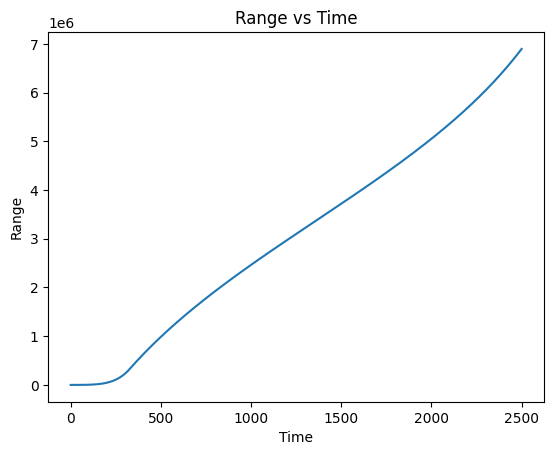

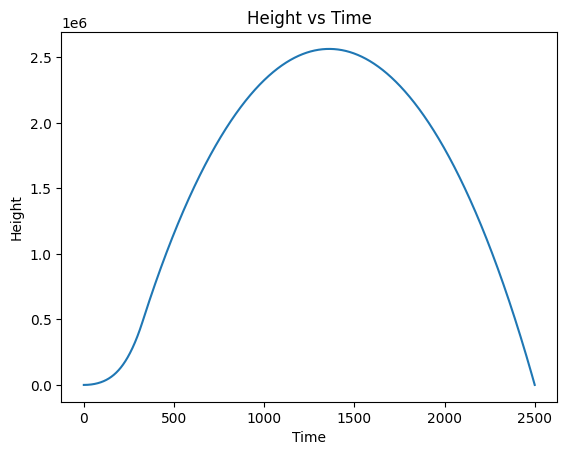

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 3692.7127991436573
Isp0: 584.1339821090933


Stage 1 burnout
Velocity (km/s):  5.298594673930676
Angle (deg h):  43.65482945697622
Range (km):  215.96167771455927
Time (sec):  235.09999999999093
Final results: 
Range (km):  4411.5602057280985
Apogee (km):  1478.7962470756456
Time to target (sec):  1632.5999999996106




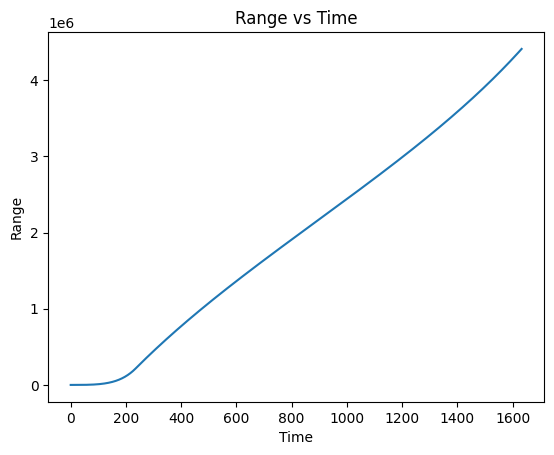

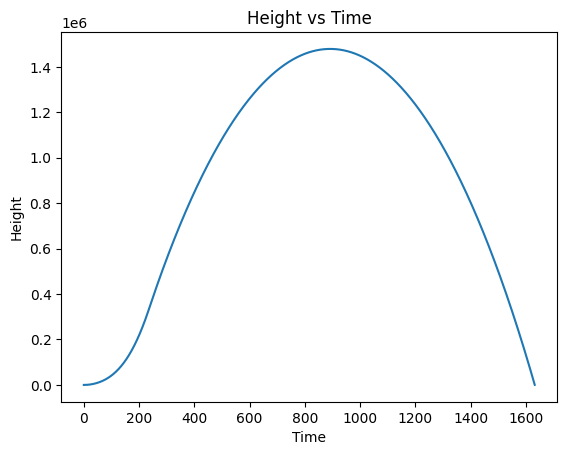

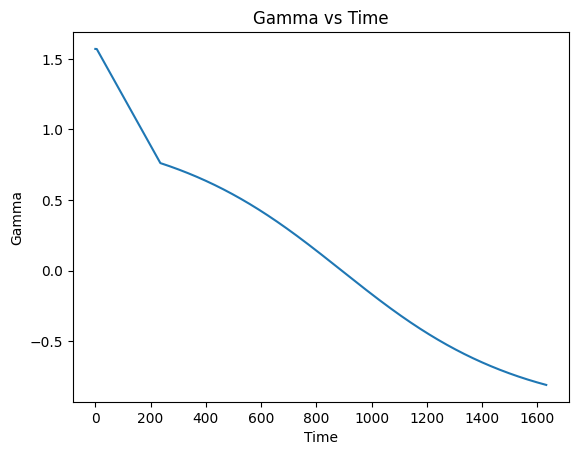

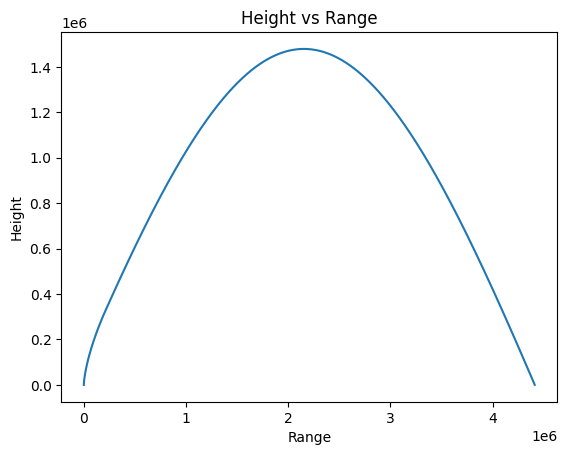

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 643.2961688158825
Isp0: 341.5649562901665


Stage 1 burnout
Velocity (km/s):  0.736296482727205
Angle (deg h):  43.699380150858914
Range (km):  3.8535088969034486
Time (sec):  24.000000000000075
Final results: 
Range (km):  66.39387657303175
Apogee (km):  20.818494173297893
Time to target (sec):  141.89999999999623




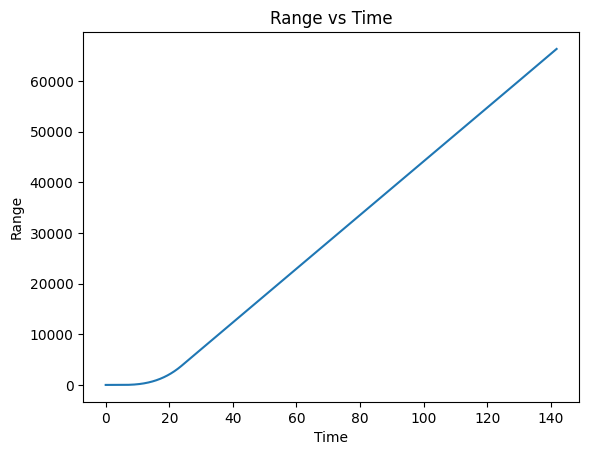

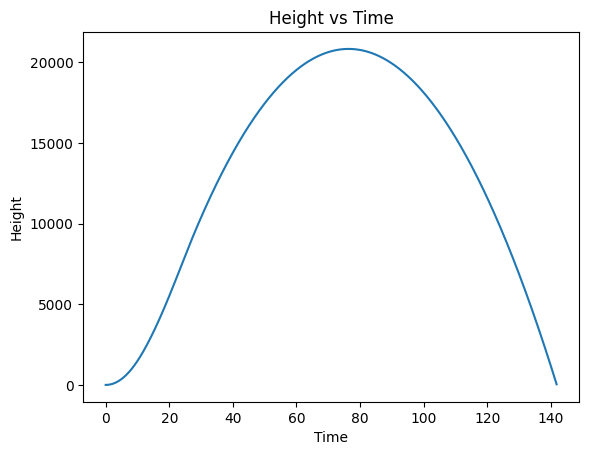

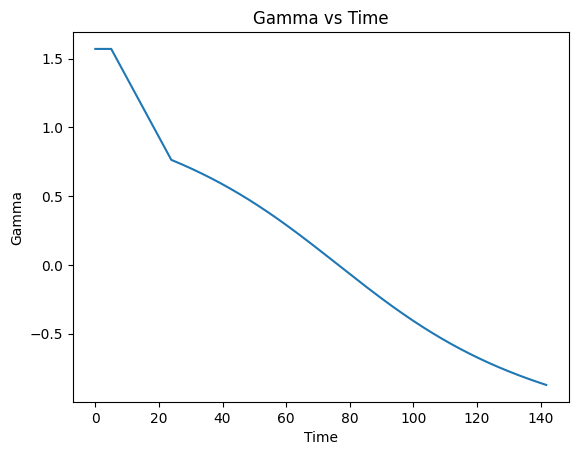

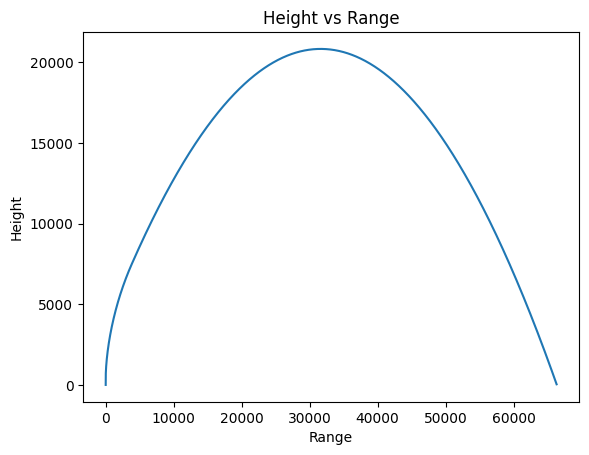

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 5354.551116301774
Isp0: 134.4528374524783


Stage 1 burnout
Velocity (km/s):  1.0914381781425055
Angle (deg h):  43.643760856775515
Range (km):  14.344815740064808
Time (sec):  78.49999999999982
Final results: 
Range (km):  156.90852083588092
Apogee (km):  51.19967201833854
Time to target (sec):  260.49999999999073




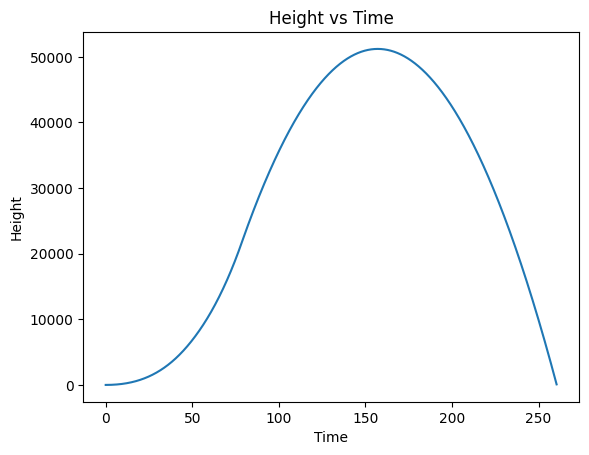

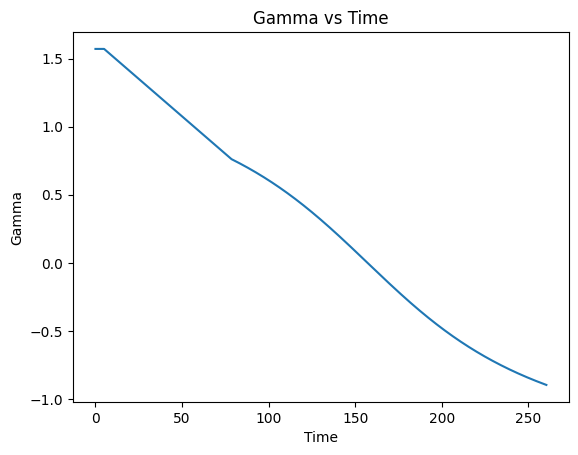

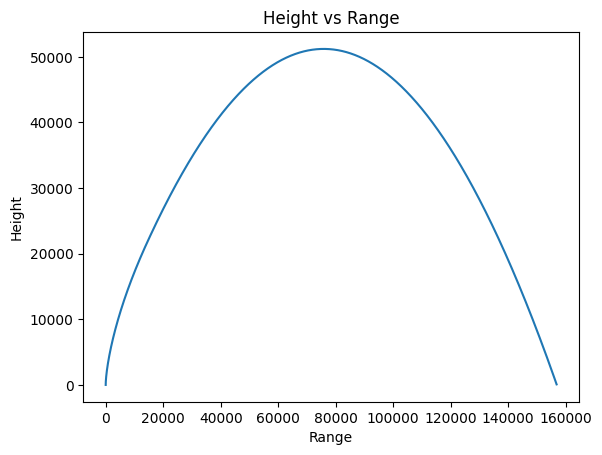

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 3016.730295164458
Isp0: 346.4666350519459


Stage 1 burnout
Velocity (km/s):  2.4952815224955143
Angle (deg h):  43.6740058305874
Range (km):  52.85423119366178
Time (sec):  113.8999999999978
Final results: 
Range (km):  808.5307033418469
Apogee (km):  251.1146994992927
Time to target (sec):  550.8000000000567




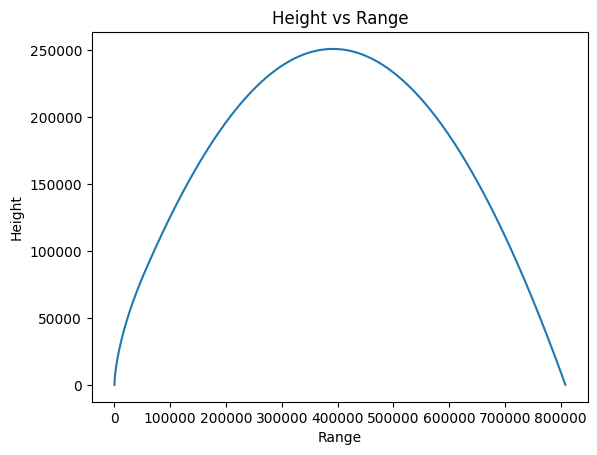

Data written to 'results/results_4.txt'

New simulation 

fuelmass: 5376.978365917834
Isp0: 158.57350785987842


Stage 1 burnout
Velocity (km/s):  1.325019245365978
Angle (deg h):  43.65458961529278
Range (km):  20.212233772702373
Time (sec):  92.899999999999
Final results: 
Range (km):  230.1956887976471
Apogee (km):  74.26776794757154
Time to target (sec):  314.60000000000304




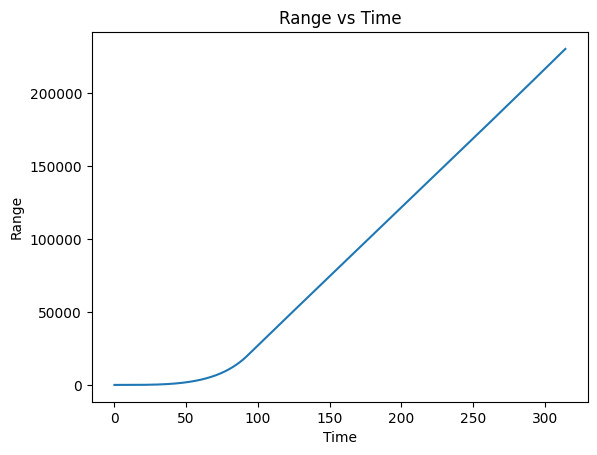

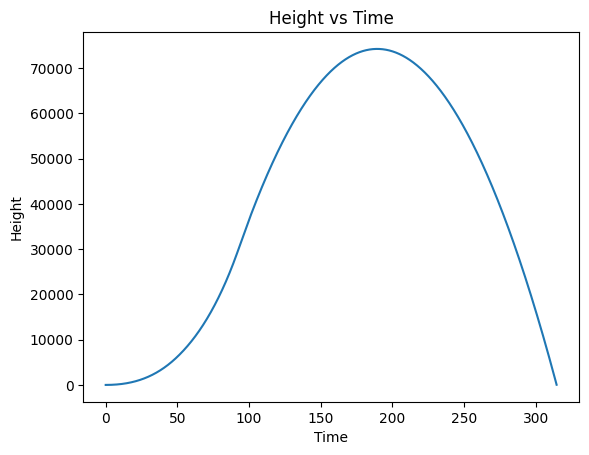

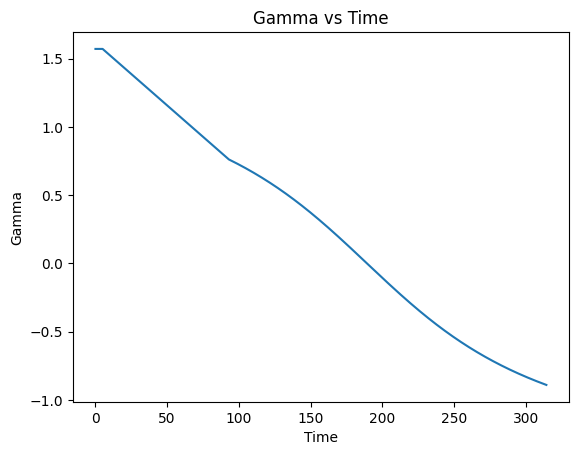

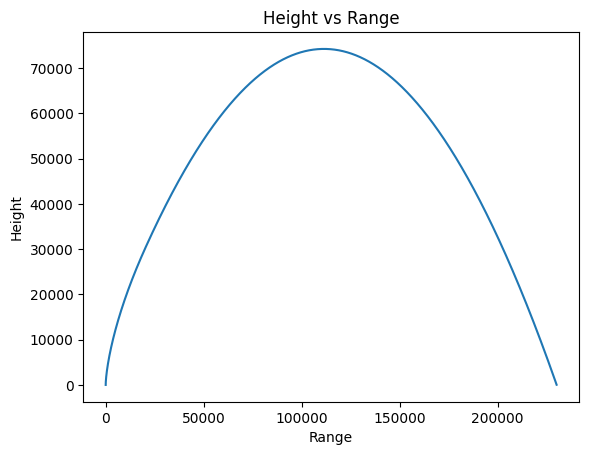

Data written to 'results/results_5.txt'


In [39]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m2_design = RandomDesign(m2_space)
m2_x = m2_design.get_samples(3*2)
m2_y = run_missile_sim(m2_x)

In [40]:
# Build model
m2_var_kernel = (100)**2 
m2_lengthscale = 100 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m2_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)

constrain_lengthscale = True

m2_rbf_kern = GPy.kern.RBF(input_dim=2, lengthscale=m2_lengthscale)
if constrain_lengthscale:
    m2_rbf_kern.lengthscale.constrain_bounded(m2_lengthscale, m2_lengthscale*1e12)

m2_kern = m2_rbf_kern + \
    GPy.kern.Linear(input_dim=2)

m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m2_model_gpy)




reconstraining parameters rbf.lengthscale


In [41]:
m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()

In [42]:
display(m2_model_gpy)

In [ ]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
m2_param_1_x_plot = np.linspace(m2_space.parameters[0].min, m2_space.parameters[0].max, nr_points_plot)[:, None]
m2_param_2_x_plot = np.linspace(m2_space.parameters[1].min, m2_space.parameters[1].max, nr_points_plot)[:, None]
m2_x_plot_mesh, m2_y_plot_mesh = np.meshgrid(m2_param_1_x_plot, m2_param_2_x_plot)
m2_x_plot = np.array([m2_x_plot_mesh, m2_y_plot_mesh]).T.reshape(-1,2)

if run_grid_simulation:
    m2_y_plot = run_missile_sim(m2_x_plot) # TAKES LONG TIME
    m2_Z = m2_y_plot.reshape(m2_x_plot_mesh.shape)





New simulation 

fuelmass: 500.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.20141678595212545
Angle (deg h):  48.42747458604135
Range (km):  0.039225635558525145
Time (sec):  5.499999999999997
Final results: 
Range (km):  4.568720831271844
Apogee (km):  1.6703525359545364
Time to target (sec):  39.40000000000029



New simulation 

fuelmass: 500.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.21626480689820085
Angle (deg h):  45.10778788311837
Range (km):  0.0741876762780693
Time (sec):  5.899999999999996
Final results: 
Range (km):  5.3689349721459765
Apogee (km):  1.7783658154309772
Time to target (sec):  40.60000000000031



New simulation 

fuelmass: 500.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.22653704863045568
Angle (deg h):  44.06837815156451
Range (km):  0.094615557977128
Time (sec):  6.199999999999995
Final results: 
Range (km):  5.937694439446193
Apogee (km):  1.9048834231711183
Time to target (sec):  42.10000000000033



New simulation 

fuelmass: 500.

Final results: 
Range (km):  37.45620227664524
Apogee (km):  11.765768644508606
Time to target (sec):  105.69999999999827



New simulation 

fuelmass: 500.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  0.5682277341455773
Angle (deg h):  43.846592353510786
Range (km):  2.032388641351322
Time (sec):  17.29999999999998
Final results: 
Range (km):  39.042340755417825
Apogee (km):  12.248380363046802
Time to target (sec):  107.79999999999815



New simulation 

fuelmass: 500.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  0.5799546982571362
Angle (deg h):  43.77168137863794
Range (km):  2.136636224203167
Time (sec):  17.699999999999985
Final results: 
Range (km):  40.706846109864
Apogee (km):  12.743283248549096
Time to target (sec):  109.99999999999802



New simulation 

fuelmass: 500.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  0.5917299767912773
Angle (deg h):  43.701192520585515
Range (km):  2.2432236958730503
Time (sec):  18.09999999999999
Final results: 
Range (km):  42.40

Final results: 
Range (km):  87.31922324310594
Apogee (km):  27.251925393371437
Time to target (sec):  162.09999999999508



New simulation 

fuelmass: 500.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  0.8567092859233053
Angle (deg h):  43.784404559006596
Range (km):  5.188992130853853
Time (sec):  27.20000000000012
Final results: 
Range (km):  89.82792555069396
Apogee (km):  28.117288783924973
Time to target (sec):  164.69999999999493



New simulation 

fuelmass: 500.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  0.8688752939558064
Angle (deg h):  43.743742898995805
Range (km):  5.350235871225842
Time (sec):  27.600000000000126
Final results: 
Range (km):  92.4250584629492
Apogee (km):  28.890197689668316
Time to target (sec):  166.9999999999948



New simulation 

fuelmass: 500.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  0.8811018284625006
Angle (deg h):  43.70444078864808
Range (km):  5.513956917837371
Time (sec):  28.00000000000013
Final results: 
Range (km):  95.0643

Stage 1 burnout
Velocity (km/s):  1.188532900267173
Angle (deg h):  43.736509664696165
Range (km):  10.022015193338238
Time (sec):  37.50000000000026
Final results: 
Range (km):  173.31431194301862
Apogee (km):  53.6137778433903
Time to target (sec):  229.39999999999125



New simulation 

fuelmass: 500.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  1.2024985263629944
Angle (deg h):  43.709251441448394
Range (km):  10.250434237991819
Time (sec):  37.90000000000027
Final results: 
Range (km):  177.39672981270684
Apogee (km):  54.80946347555663
Time to target (sec):  231.9999999999911



New simulation 

fuelmass: 500.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  1.2165386136246157
Angle (deg h):  43.68262126768027
Range (km):  10.481739484319652
Time (sec):  38.300000000000274
Final results: 
Range (km):  181.53579941938645
Apogee (km):  56.02405159759176
Time to target (sec):  234.59999999999096



New simulation 

fuelmass: 500.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  32.424275983275955
Apogee (km):  10.194550936844703
Time to target (sec):  98.39999999999868



New simulation 

fuelmass: 555.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  0.5293809178428338
Angle (deg h):  43.680601827052044
Range (km):  1.7306250532959147
Time (sec):  16.199999999999964
Final results: 
Range (km):  33.87061243332882
Apogee (km):  10.587202721441455
Time to target (sec):  100.29999999999858



New simulation 

fuelmass: 555.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  0.5439347489362333
Angle (deg h):  43.69782457336265
Range (km):  1.8597394106245697
Time (sec):  16.69999999999997
Final results: 
Range (km):  35.812194965509036
Apogee (km):  11.186577402662435
Time to target (sec):  103.19999999999841



New simulation 

fuelmass: 555.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  0.5550613206180329
Angle (deg h):  43.78486204582076
Range (km):  1.9523586083782494
Time (sec):  17.099999999999977
Final results: 
Range (km):  3

Final results: 
Range (km):  87.50155899593643
Apogee (km):  27.35303550653502
Time to target (sec):  162.69999999999504



New simulation 

fuelmass: 555.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  0.8601391116912547
Angle (deg h):  43.679705465734465
Range (km):  5.305063920287495
Time (sec):  27.700000000000127
Final results: 
Range (km):  90.73879455642194
Apogee (km):  28.336965098755055
Time to target (sec):  165.69999999999487



New simulation 

fuelmass: 555.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  0.8719265472059077
Angle (deg h):  43.72588194491502
Range (km):  5.456746360057073
Time (sec):  28.100000000000133
Final results: 
Range (km):  93.2363471989568
Apogee (km):  29.156060169498105
Time to target (sec):  168.09999999999474



New simulation 

fuelmass: 555.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  0.883773755432559
Angle (deg h):  43.77040215143975
Range (km):  5.610635333186996
Time (sec):  28.50000000000014
Final results: 
Range (km):  95.77384

Final results: 
Range (km):  184.5879995866186
Apogee (km):  57.0428084326218
Time to target (sec):  237.1999999999908



New simulation 

fuelmass: 555.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  1.2397394865785551
Angle (deg h):  43.739861906369605
Range (km):  10.961811193121301
Time (sec):  39.50000000000029
Final results: 
Range (km):  188.7679149674961
Apogee (km):  58.35057676575761
Time to target (sec):  239.99999999999065



New simulation 

fuelmass: 555.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  1.253686022882034
Angle (deg h):  43.66841606328471
Range (km):  11.186444516754516
Time (sec):  39.9000000000003
Final results: 
Range (km):  193.05605771823505
Apogee (km):  59.538191021582534
Time to target (sec):  242.4999999999905



New simulation 

fuelmass: 555.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  1.271981497149362
Angle (deg h):  43.66780290732589
Range (km):  11.505381619069938
Time (sec):  40.400000000000304
Final results: 
Range (km):  198.708122

Final results: 
Range (km):  35.58860717345975
Apogee (km):  11.2005518414402
Time to target (sec):  103.3999999999984



New simulation 

fuelmass: 610.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  0.5562097488897285
Angle (deg h):  43.75828814525411
Range (km):  1.9936772433807537
Time (sec):  17.39999999999998
Final results: 
Range (km):  37.51590523948943
Apogee (km):  11.764420604553754
Time to target (sec):  105.99999999999825



New simulation 

fuelmass: 610.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  0.5669394348800951
Angle (deg h):  43.6990023917143
Range (km):  2.081469558607177
Time (sec):  17.799999999999986
Final results: 
Range (km):  39.01772672452018
Apogee (km):  12.227979457589504
Time to target (sec):  108.09999999999813



New simulation 

fuelmass: 610.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  0.5813143769082902
Angle (deg h):  43.855592436122926
Range (km):  2.212959871676248
Time (sec):  18.299999999999994
Final results: 
Range (km):  41.02755

Final results: 
Range (km):  96.56623125683703
Apogee (km):  30.253304926223468
Time to target (sec):  171.59999999999454



New simulation 

fuelmass: 610.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  0.9017964074052538
Angle (deg h):  43.69199004261913
Range (km):  5.926863240330371
Time (sec):  29.500000000000153
Final results: 
Range (km):  99.91156419289851
Apogee (km):  31.233584187404507
Time to target (sec):  174.39999999999438



New simulation 

fuelmass: 610.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  0.9133672001071823
Angle (deg h):  43.67021622902122
Range (km):  6.075622578809642
Time (sec):  29.90000000000016
Final results: 
Range (km):  102.5368215598321
Apogee (km):  32.03635002248621
Time to target (sec):  176.69999999999425



New simulation 

fuelmass: 610.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  0.9286858170928016
Angle (deg h):  43.746016555559976
Range (km):  6.293321158833859
Time (sec):  30.400000000000166
Final results: 
Range (km):  105.96

Final results: 
Range (km):  210.73824801072365
Apogee (km):  64.89228402591525
Time to target (sec):  253.89999999998986



New simulation 

fuelmass: 610.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  1.3276904795868538
Angle (deg h):  43.711284859750464
Range (km):  12.550260948233166
Time (sec):  42.500000000000334
Final results: 
Range (km):  216.63723832097403
Apogee (km):  66.7313256384406
Time to target (sec):  257.5999999999901



New simulation 

fuelmass: 610.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  1.3461687579986894
Angle (deg h):  43.668168827514165
Range (km):  12.873796864472471
Time (sec):  43.00000000000034
Final results: 
Range (km):  222.67840451207337
Apogee (km):  68.45526052800275
Time to target (sec):  260.99999999999085



New simulation 

fuelmass: 610.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  1.3603710807225793
Angle (deg h):  43.654861537175975
Range (km):  13.10387052004285
Time (sec):  43.40000000000035
Final results: 
Range (km):  227.

Stage 1 burnout
Velocity (km/s):  0.5902107400210816
Angle (deg h):  43.691514466972464
Range (km):  2.324244100248419
Time (sec):  18.900000000000002
Final results: 
Range (km):  42.392528988935936
Apogee (km):  13.306464598214417
Time to target (sec):  112.99999999999785



New simulation 

fuelmass: 665.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  0.6041094334265942
Angle (deg h):  43.71330383789445
Range (km):  2.4539210287081277
Time (sec):  19.40000000000001
Final results: 
Range (km):  44.44827503719648
Apogee (km):  13.959796631070112
Time to target (sec):  115.7999999999977



New simulation 

fuelmass: 665.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  0.6215232608334759
Angle (deg h):  43.6684456444596
Range (km):  2.6317219805399
Time (sec):  20.000000000000018
Final results: 
Range (km):  47.11855489490391
Apogee (km):  14.756287777577548
Time to target (sec):  119.1999999999975



New simulation 

fuelmass: 665.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  0.6

Final results: 
Range (km):  143.56313599795433
Apogee (km):  44.67526561695834
Time to target (sec):  209.89999999999236



New simulation 

fuelmass: 665.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  1.095572504940176
Angle (deg h):  43.700581714131815
Range (km):  8.84803664542851
Time (sec):  36.200000000000244
Final results: 
Range (km):  147.79423886723404
Apogee (km):  45.99203196745924
Time to target (sec):  212.99999999999218



New simulation 

fuelmass: 665.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  1.111640680064857
Angle (deg h):  43.71033437205018
Range (km):  9.09900294547528
Time (sec):  36.70000000000025
Final results: 
Range (km):  152.1798938775913
Apogee (km):  47.33526234103818
Time to target (sec):  216.199999999992



New simulation 

fuelmass: 665.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  1.127816534731417
Angle (deg h):  43.71978484900432
Range (km):  9.353875792377009
Time (sec):  37.20000000000026
Final results: 
Range (km):  156.6422957361

Final results: 
Range (km):  300.39286810268186
Apogee (km):  91.64980649664311
Time to target (sec):  304.10000000000065



New simulation 

fuelmass: 665.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  1.5819328542149085
Angle (deg h):  43.68100067908949
Range (km):  17.322571986876174
Time (sec):  49.90000000000044
Final results: 
Range (km):  307.7543558103166
Apogee (km):  93.84226730670582
Time to target (sec):  307.9000000000015



New simulation 

fuelmass: 665.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  1.6008615162186863
Angle (deg h):  43.68809295872248
Range (km):  17.69286984830776
Time (sec):  50.400000000000446
Final results: 
Range (km):  315.2078855913278
Apogee (km):  96.06737964480473
Time to target (sec):  311.7000000000024



New simulation 

fuelmass: 665.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  1.61982777656249
Angle (deg h):  43.69502883731849
Range (km):  18.06774338398422
Time (sec):  50.90000000000045
Final results: 
Range (km):  322.63551662

Stage 1 burnout
Velocity (km/s):  0.6135517923013987
Angle (deg h):  43.66927384027773
Range (km):  2.5892994042753332
Time (sec):  20.000000000000018
Final results: 
Range (km):  45.93195087902614
Apogee (km):  14.413915505993979
Time to target (sec):  117.89999999999758



New simulation 

fuelmass: 720.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  0.6268784769974447
Angle (deg h):  43.81513842922556
Range (km):  2.716678535246753
Time (sec):  20.500000000000025
Final results: 
Range (km):  47.970530409402805
Apogee (km):  15.119615560771537
Time to target (sec):  120.79999999999741



New simulation 

fuelmass: 720.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  0.6437313201572968
Angle (deg h):  43.661865744491756
Range (km):  2.8934718155910657
Time (sec):  21.100000000000033
Final results: 
Range (km):  50.68477925334425
Apogee (km):  15.89026521485101
Time to target (sec):  123.99999999999723



New simulation 

fuelmass: 720.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  127.73934410442284
Apogee (km):  39.86199581113519
Time to target (sec):  198.29999999999302



New simulation 

fuelmass: 720.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  1.0366132545608966
Angle (deg h):  43.697952663631845
Range (km):  8.024386376832144
Time (sec):  34.800000000000225
Final results: 
Range (km):  132.45996510418416
Apogee (km):  41.352849203008326
Time to target (sec):  201.9999999999928



New simulation 

fuelmass: 720.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  1.0517821006798282
Angle (deg h):  43.65710208281522
Range (km):  8.248409721029402
Time (sec):  35.30000000000023
Final results: 
Range (km):  136.37916532049903
Apogee (km):  42.52412542502576
Time to target (sec):  204.89999999999264



New simulation 

fuelmass: 720.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  1.0709626128130936
Angle (deg h):  43.69371461393345
Range (km):  8.553073829945498
Time (sec):  35.90000000000024
Final results: 
Range (km):  141.44

Final results: 
Range (km):  287.5215933905856
Apogee (km):  87.8769290397134
Time to target (sec):  297.99999999999926



New simulation 

fuelmass: 720.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  1.5465576961393555
Angle (deg h):  43.71168129128394
Range (km):  16.78308446535758
Time (sec):  49.600000000000435
Final results: 
Range (km):  294.38302505781
Apogee (km):  90.05766358510878
Time to target (sec):  301.8000000000001



New simulation 

fuelmass: 720.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  1.56941824664917
Angle (deg h):  43.65881868095492
Range (km):  17.239591893958455
Time (sec):  50.20000000000044
Final results: 
Range (km):  303.2043630113549
Apogee (km):  92.52874707310362
Time to target (sec):  306.1000000000011



New simulation 

fuelmass: 720.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  1.587705568519349
Angle (deg h):  43.708653368147445
Range (km):  17.588586207103898
Time (sec):  50.70000000000045
Final results: 
Range (km):  310.25541832589

Final results: 
Range (km):  16.841891840560947
Apogee (km):  5.235317505816866
Time to target (sec):  70.70000000000026



New simulation 

fuelmass: 775.0
Isp0: 142.0


Stage 1 burnout
Velocity (km/s):  0.392772174423561
Angle (deg h):  44.1536308404165
Range (km):  0.8197443294434344
Time (sec):  11.999999999999975
Final results: 
Range (km):  18.414960496142474
Apogee (km):  5.7997095078567
Time to target (sec):  74.50000000000004



New simulation 

fuelmass: 775.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.4088843831551021
Angle (deg h):  44.05613990988963
Range (km):  0.9227573325609021
Time (sec):  12.599999999999973
Final results: 
Range (km):  20.00228713543428
Apogee (km):  6.295701895832608
Time to target (sec):  77.59999999999987



New simulation 

fuelmass: 775.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.4248241889043195
Angle (deg h):  43.97299409333344
Range (km):  1.030173614634105
Time (sec):  13.19999999999997
Final results: 
Range (km):  21.643037988

Final results: 
Range (km):  80.25074603764052
Apogee (km):  25.24475213537008
Time to target (sec):  157.19999999999536



New simulation 

fuelmass: 775.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  0.8241181535624411
Angle (deg h):  43.706689638995236
Range (km):  5.070555585838817
Time (sec):  28.00000000000013
Final results: 
Range (km):  83.65731524792285
Apogee (km):  26.297927829507753
Time to target (sec):  160.49999999999517



New simulation 

fuelmass: 775.0
Isp0: 338.0


Stage 1 burnout
Velocity (km/s):  0.8410639577310878
Angle (deg h):  43.68758964742207
Range (km):  5.295834062821531
Time (sec):  28.60000000000014
Final results: 
Range (km):  87.2047826169367
Apogee (km):  27.377773220335683
Time to target (sec):  163.89999999999498



New simulation 

fuelmass: 775.0
Isp0: 345.0


Stage 1 burnout
Velocity (km/s):  0.8581237158253011
Angle (deg h):  43.66944227169172
Range (km):  5.526040917321096
Time (sec):  29.20000000000015
Final results: 
Range (km):  90.773724

Stage 1 burnout
Velocity (km/s):  1.3180094632140995
Angle (deg h):  43.66536031287888
Range (km):  12.729439692883128
Time (sec):  43.900000000000354
Final results: 
Range (km):  214.28696063815977
Apogee (km):  66.1504496164839
Time to target (sec):  257.6999999999901



New simulation 

fuelmass: 775.0
Isp0: 527.0


Stage 1 burnout
Velocity (km/s):  1.3391610700589616
Angle (deg h):  43.654730705780175
Range (km):  13.100015132605424
Time (sec):  44.50000000000036
Final results: 
Range (km):  221.11036357474285
Apogee (km):  68.19465955006285
Time to target (sec):  261.699999999991



New simulation 

fuelmass: 775.0
Isp0: 534.0


Stage 1 burnout
Velocity (km/s):  1.3604699999609704
Angle (deg h):  43.7312109721472
Range (km):  13.476906793278904
Time (sec):  45.10000000000037
Final results: 
Range (km):  228.1351615063432
Apogee (km):  70.43063491513938
Time to target (sec):  266.099999999992



New simulation 

fuelmass: 775.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  1.3819

Final results: 
Range (km):  439.45690830594094
Apogee (km):  133.31565615603188
Time to target (sec):  371.00000000001586



New simulation 

fuelmass: 775.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  1.9086035100855407
Angle (deg h):  43.692339207116994
Range (km):  24.72847269241005
Time (sec):  59.90000000000058
Final results: 
Range (km):  450.361463912115
Apogee (km):  136.5198744119921
Time to target (sec):  375.7000000000169



New simulation 

fuelmass: 775.0
Isp0: 716.0


Stage 1 burnout
Velocity (km/s):  1.9314440094371754
Angle (deg h):  43.68453663493983
Range (km):  25.271031835665394
Time (sec):  60.50000000000059
Final results: 
Range (km):  461.3972607520064
Apogee (km):  139.77191670962947
Time to target (sec):  380.400000000018



New simulation 

fuelmass: 775.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  1.9543179330649287
Angle (deg h):  43.67689884365782
Range (km):  25.82012617748818
Time (sec):  61.1000000000006
Final results: 
Range (km):  472.5639966

Final results: 
Range (km):  29.36670565127466
Apogee (km):  9.22538097790085
Time to target (sec):  94.29999999999892



New simulation 

fuelmass: 830.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  0.5107019015246168
Angle (deg h):  43.734059802790554
Range (km):  1.7142797349559775
Time (sec):  16.69999999999997
Final results: 
Range (km):  31.701066950837628
Apogee (km):  9.969751438256068
Time to target (sec):  98.0999999999987



New simulation 

fuelmass: 830.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.526035003719873
Angle (deg h):  43.853083613577134
Range (km):  1.8431682620464314
Time (sec):  17.29999999999998
Final results: 
Range (km):  33.6877507866115
Apogee (km):  10.634789791179172
Time to target (sec):  101.39999999999851



New simulation 

fuelmass: 830.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.5414681502543591
Angle (deg h):  43.67605952387926
Range (km):  1.9761682797091051
Time (sec):  17.899999999999988
Final results: 
Range (km):  35.748187


New simulation 

fuelmass: 830.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  1.0363555020692394
Angle (deg h):  43.66255257528118
Range (km):  8.185112138667572
Time (sec):  35.70000000000024
Final results: 
Range (km):  132.73694014782188
Apogee (km):  41.480575629653394
Time to target (sec):  202.99999999999275



New simulation 

fuelmass: 830.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.0543289761576509
Angle (deg h):  43.71128577964377
Range (km):  8.459589046045261
Time (sec):  36.300000000000246
Final results: 
Range (km):  137.38183788270092
Apogee (km):  42.96383392402839
Time to target (sec):  206.69999999999254



New simulation 

fuelmass: 830.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  1.0724430627548631
Angle (deg h):  43.75809334148281
Range (km):  8.73909323427449
Time (sec):  36.900000000000254
Final results: 
Range (km):  142.12275628301168
Apogee (km):  44.481965289714616
Time to target (sec):  210.39999999999233



New simulation 

fuelmass: 830.0


Final results: 
Range (km):  331.7738163191771
Apogee (km):  101.30671703399929
Time to target (sec):  321.8000000000047



New simulation 

fuelmass: 830.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  1.6616346114814062
Angle (deg h):  43.715080767623
Range (km):  19.420634070710932
Time (sec):  54.0000000000005
Final results: 
Range (km):  340.647087356736
Apogee (km):  104.04918582940084
Time to target (sec):  326.3000000000057



New simulation 

fuelmass: 830.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  1.688089777858741
Angle (deg h):  43.651840387377796
Range (km):  19.993750496300486
Time (sec):  54.70000000000051
Final results: 
Range (km):  351.78111614609594
Apogee (km):  107.12932072028364
Time to target (sec):  331.40000000000686



New simulation 

fuelmass: 830.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  1.7098896362862483
Angle (deg h):  43.68238035018945
Range (km):  20.452977829156517
Time (sec):  55.300000000000516
Final results: 
Range (km):  360.91696

Final results: 
Range (km):  663.5927747058968
Apogee (km):  200.39372903143556
Time to target (sec):  461.50000000003644



New simulation 

fuelmass: 830.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  2.3279734025420553
Angle (deg h):  43.663706017515146
Range (km):  35.812489538732834
Time (sec):  71.7000000000002
Final results: 
Range (km):  677.3087869056296
Apogee (km):  204.33374628793092
Time to target (sec):  466.40000000003755



New simulation 

fuelmass: 830.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  2.35575969127568
Angle (deg h):  43.67091790566925
Range (km):  36.61489531982976
Time (sec):  72.40000000000016
Final results: 
Range (km):  694.1516117957785
Apogee (km):  209.364416814088
Time to target (sec):  472.60000000003896



New simulation 

fuelmass: 885.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.31735908523078765
Angle (deg h):  43.95371753260921
Range (km):  0.46096399717893893
Time (sec):  9.699999999999983
Final results: 
Range (km):  11.92259

Final results: 
Range (km):  90.42267223359922
Apogee (km):  28.53117993143103
Time to target (sec):  167.89999999999475



New simulation 

fuelmass: 885.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  0.8751448359313182
Angle (deg h):  43.73029058061489
Range (km):  5.876501169283329
Time (sec):  30.60000000000017
Final results: 
Range (km):  94.65864437275059
Apogee (km):  29.817995531400708
Time to target (sec):  171.69999999999453



New simulation 

fuelmass: 885.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  0.8950530102938334
Angle (deg h):  43.68398411964433
Range (km):  6.158961858228945
Time (sec):  31.30000000000018
Final results: 
Range (km):  99.07124793463173
Apogee (km):  31.14169673467396
Time to target (sec):  175.5999999999943



New simulation 

fuelmass: 885.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  0.9113952088298315
Angle (deg h):  43.68381429288863
Range (km):  6.382242045925063
Time (sec):  31.900000000000187
Final results: 
Range (km):  102.742844

Final results: 
Range (km):  243.95871887996083
Apogee (km):  75.16513647844543
Time to target (sec):  276.0999999999943



New simulation 

fuelmass: 885.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  1.4257805687833656
Angle (deg h):  43.67212939141582
Range (km):  14.905313256302435
Time (sec):  48.10000000000041
Final results: 
Range (km):  251.12393109203828
Apogee (km):  77.31844095739233
Time to target (sec):  280.1999999999952



New simulation 

fuelmass: 885.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  1.4507826044202834
Angle (deg h):  43.7243331273819
Range (km):  15.377721427114446
Time (sec):  48.80000000000042
Final results: 
Range (km):  259.8587820903891
Apogee (km):  80.05288383549674
Time to target (sec):  285.19999999999635



New simulation 

fuelmass: 885.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  1.475900265150662
Angle (deg h):  43.697266381147074
Range (km):  15.858804812743516
Time (sec):  49.50000000000043
Final results: 
Range (km):  268.98996

Final results: 
Range (km):  531.6858164778318
Apogee (km):  161.04600057995273
Time to target (sec):  411.200000000025



New simulation 

fuelmass: 885.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  2.094935301083842
Angle (deg h):  43.667474888957976
Range (km):  29.818167900096412
Time (sec):  66.4000000000005
Final results: 
Range (km):  545.6795605528384
Apogee (km):  165.14443075148503
Time to target (sec):  416.70000000002625



New simulation 

fuelmass: 885.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  2.121472544191049
Angle (deg h):  43.64869525668942
Range (km):  30.515894813944662
Time (sec):  67.10000000000046
Final results: 
Range (km):  559.999897429334
Apogee (km):  169.3070877390141
Time to target (sec):  422.3000000000275



New simulation 

fuelmass: 885.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  2.143157118806284
Angle (deg h):  43.70422219430056
Range (km):  31.068446768601838
Time (sec):  67.70000000000043
Final results: 
Range (km):  571.724876774

Final results: 
Range (km):  37.685900617657765
Apogee (km):  11.889862959269541
Time to target (sec):  107.69999999999816



New simulation 

fuelmass: 940.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.5728290135903294
Angle (deg h):  43.78151396991564
Range (km):  2.325537378318152
Time (sec):  19.600000000000012
Final results: 
Range (km):  40.2103348174623
Apogee (km):  12.710073683080703
Time to target (sec):  111.39999999999795



New simulation 

fuelmass: 940.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.5910233547613583
Angle (deg h):  43.825834099863776
Range (km):  2.498622668918861
Time (sec):  20.300000000000022
Final results: 
Range (km):  42.828368616026054
Apogee (km):  13.561850078240957
Time to target (sec):  115.09999999999773



New simulation 

fuelmass: 940.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.6091892338955582
Angle (deg h):  43.86624321938531
Range (km):  2.6775112611180143
Time (sec):  21.000000000000032
Final results: 
Range (km):  45

Final results: 
Range (km):  158.07753134152668
Apogee (km):  49.33659773763038
Time to target (sec):  222.59999999999164



New simulation 

fuelmass: 940.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  1.1512805053337036
Angle (deg h):  43.68934359529145
Range (km):  10.204417958544306
Time (sec):  40.400000000000304
Final results: 
Range (km):  164.20662109227152
Apogee (km):  51.21843623338466
Time to target (sec):  226.9999999999914



New simulation 

fuelmass: 940.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.1729802955628394
Angle (deg h):  43.71039323893613
Range (km):  10.567225958940215
Time (sec):  41.100000000000314
Final results: 
Range (km):  170.3893474490683
Apogee (km):  53.14902747514512
Time to target (sec):  231.29999999999114



New simulation 

fuelmass: 940.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  1.194875134020066
Angle (deg h):  43.73062990114564
Range (km):  10.93724644154514
Time (sec):  41.800000000000324
Final results: 
Range (km):  176.79

Final results: 
Range (km):  447.4384847254996
Apogee (km):  136.0116090487127
Time to target (sec):  376.60000000001713



New simulation 

fuelmass: 940.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  1.924924186875675
Angle (deg h):  43.69719787131302
Range (km):  25.774776699915947
Time (sec):  62.60000000000062
Final results: 
Range (km):  459.6926721357102
Apogee (km):  139.71451596847348
Time to target (sec):  382.00000000001836



New simulation 

fuelmass: 940.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  1.9502937110314331
Angle (deg h):  43.71018314907585
Range (km):  26.392435090475235
Time (sec):  63.30000000000063
Final results: 
Range (km):  471.9656074270142
Apogee (km):  143.47950496799206
Time to target (sec):  387.30000000001957



New simulation 

fuelmass: 940.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  1.9757033739018115
Angle (deg h):  43.66333417880446
Range (km):  27.018190894059607
Time (sec):  64.00000000000064
Final results: 
Range (km):  484.739

Stage 1 burnout
Velocity (km/s):  2.6542382462709644
Angle (deg h):  43.661890486090016
Range (km):  46.27042669360764
Time (sec):  81.99999999999962
Final results: 
Range (km):  891.6744729880459
Apogee (km):  269.1389158024939
Time to target (sec):  543.400000000055



New simulation 

fuelmass: 995.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.34435239459119665
Angle (deg h):  43.8642377739579
Range (km):  0.6085872431272357
Time (sec):  10.899999999999979
Final results: 
Range (km):  14.129146561905026
Apogee (km):  4.427870479467047
Time to target (sec):  65.40000000000056



New simulation 

fuelmass: 995.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.3632858409498271
Angle (deg h):  43.656284050164004
Range (km):  0.7052905162016652
Time (sec):  11.599999999999977
Final results: 
Range (km):  15.77973001574284
Apogee (km):  4.9248945702000775
Time to target (sec):  69.00000000000036



New simulation 

fuelmass: 995.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.

Stage 1 burnout
Velocity (km/s):  0.875742947246843
Angle (deg h):  43.66298226249617
Range (km):  6.009591059599991
Time (sec):  31.40000000000018
Final results: 
Range (km):  95.07772464182608
Apogee (km):  29.941379414143256
Time to target (sec):  172.69999999999447



New simulation 

fuelmass: 995.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  0.8944534302777706
Angle (deg h):  43.76324184144802
Range (km):  6.2696131381785145
Time (sec):  32.100000000000186
Final results: 
Range (km):  99.18793773848498
Apogee (km):  31.31601385800922
Time to target (sec):  176.69999999999425



New simulation 

fuelmass: 995.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  0.9170550635529638
Angle (deg h):  43.69169904993183
Range (km):  6.601661899574915
Time (sec):  32.9000000000002
Final results: 
Range (km):  104.26515575065925
Apogee (km):  32.837900991578906
Time to target (sec):  180.999999999994



New simulation 

fuelmass: 995.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  0.936

Final results: 
Range (km):  274.6416880807049
Apogee (km):  84.52832747564027
Time to target (sec):  294.2999999999984



New simulation 

fuelmass: 995.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  1.51824193056114
Angle (deg h):  43.64900582467046
Range (km):  16.968123197037233
Time (sec):  51.90000000000047
Final results: 
Range (km):  285.25643036570733
Apogee (km):  87.5771077696229
Time to target (sec):  299.79999999999967



New simulation 

fuelmass: 995.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  1.5421001507802266
Angle (deg h):  43.70648572542745
Range (km):  17.434919868238538
Time (sec):  52.60000000000048
Final results: 
Range (km):  294.26183678501127
Apogee (km):  90.427008383063
Time to target (sec):  304.8000000000008



New simulation 

fuelmass: 995.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  1.5706570134904503
Angle (deg h):  43.66632460612213
Range (km):  18.022155743994638
Time (sec):  53.40000000000049
Final results: 
Range (km):  305.262139321

Final results: 
Range (km):  619.433502997794
Apogee (km):  187.56110243747167
Time to target (sec):  447.3000000000332



New simulation 

fuelmass: 995.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  2.251120464675932
Angle (deg h):  43.661232884368644
Range (km):  34.56039547444962
Time (sec):  72.30000000000017
Final results: 
Range (km):  633.9546120977443
Apogee (km):  191.88224775812492
Time to target (sec):  452.80000000003446



New simulation 

fuelmass: 995.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  2.28123071840504
Angle (deg h):  43.68520038952612
Range (km):  35.41791290587159
Time (sec):  73.10000000000012
Final results: 
Range (km):  651.413872853241
Apogee (km):  197.25047299960104
Time to target (sec):  459.500000000036



New simulation 

fuelmass: 995.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  2.311402441703264
Angle (deg h):  43.65723710504974
Range (km):  36.28682697289845
Time (sec):  73.90000000000008
Final results: 
Range (km):  669.354815270514

Stage 1 burnout
Velocity (km/s):  0.5169744429236317
Angle (deg h):  43.746167392767674
Range (km):  1.8674605181544106
Time (sec):  17.899999999999988
Final results: 
Range (km):  32.69946469020726
Apogee (km):  10.33723718243388
Time to target (sec):  100.59999999999856



New simulation 

fuelmass: 1050.0
Isp0: 163.0


Stage 1 burnout
Velocity (km/s):  0.5368560654131509
Angle (deg h):  43.74190818398431
Range (km):  2.0472284191401644
Time (sec):  18.7
Final results: 
Range (km):  35.34035580127
Apogee (km):  11.173822784899302
Time to target (sec):  104.69999999999833



New simulation 

fuelmass: 1050.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  0.5569350103254355
Angle (deg h):  43.73826323004531
Range (km):  2.2342898444549566
Time (sec):  19.50000000000001
Final results: 
Range (km):  38.054641378318074
Apogee (km):  12.047717288455713
Time to target (sec):  108.6999999999981



New simulation 

fuelmass: 1050.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  0.5772600229

Stage 1 burnout
Velocity (km/s):  1.070541112375252
Angle (deg h):  43.711510994221506
Range (km):  9.042715057151417
Time (sec):  38.70000000000028
Final results: 
Range (km):  142.29369904983383
Apogee (km):  44.65460534775894
Time to target (sec):  212.19999999999223



New simulation 

fuelmass: 1050.0
Isp0: 345.0


Stage 1 burnout
Velocity (km/s):  1.094226232340585
Angle (deg h):  43.71126452478109
Range (km):  9.430029959193567
Time (sec):  39.50000000000029
Final results: 
Range (km):  148.64468093189626
Apogee (km):  46.60619672622204
Time to target (sec):  216.89999999999196



New simulation 

fuelmass: 1050.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  1.1181453510029526
Angle (deg h):  43.71104029621616
Range (km):  9.826401939354641
Time (sec):  40.3000000000003
Final results: 
Range (km):  155.24273315838542
Apogee (km):  48.61575308609854
Time to target (sec):  221.6999999999917



New simulation 

fuelmass: 1050.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  1.1

Stage 1 burnout
Velocity (km/s):  1.8179883606307052
Angle (deg h):  43.7089822345311
Range (km):  23.62305390419861
Time (sec):  61.1000000000006
Final results: 
Range (km):  410.1044389216045
Apogee (km):  125.20643340383529
Time to target (sec):  361.6000000000137



New simulation 

fuelmass: 1050.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  1.8462953171742762
Angle (deg h):  43.708950741640805
Range (km):  24.293658177791936
Time (sec):  61.90000000000061
Final results: 
Range (km):  423.1828220387948
Apogee (km):  129.10961121188498
Time to target (sec):  367.50000000001506



New simulation 

fuelmass: 1050.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  1.8746504921152785
Angle (deg h):  43.70892044729329
Range (km):  24.974701048349317
Time (sec):  62.70000000000062
Final results: 
Range (km):  436.46250604972005
Apogee (km):  133.08701291866305
Time to target (sec):  373.4000000000164



New simulation 

fuelmass: 1050.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  883.4048881720762
Apogee (km):  266.99720359831326
Time to target (sec):  542.5000000000548



New simulation 

fuelmass: 1050.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  2.6701648304749583
Angle (deg h):  43.650073899933524
Range (km):  47.55294120166468
Time (sec):  84.39999999999948
Final results: 
Range (km):  904.8129278238871
Apogee (km):  273.46539260813967
Time to target (sec):  549.7000000000564



New simulation 

fuelmass: 1050.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  2.700589714304569
Angle (deg h):  43.65065319661027
Range (km):  48.535134846348505
Time (sec):  85.19999999999943
Final results: 
Range (km):  926.4586867891171
Apogee (km):  280.0493531428308
Time to target (sec):  556.9000000000581



New simulation 

fuelmass: 1050.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  2.7311158761886847
Angle (deg h):  43.65122162796824
Range (km):  49.52839909366621
Time (sec):  85.99999999999939
Final results: 
Range (km):  948.7407

Final results: 
Range (km):  100.5722164419742
Apogee (km):  31.752394611564483
Time to target (sec):  178.49999999999415



New simulation 

fuelmass: 1105.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  0.9246794387101719
Angle (deg h):  43.69406396615687
Range (km):  6.841604458749075
Time (sec):  34.00000000000021
Final results: 
Range (km):  106.3002172439819
Apogee (km):  33.53237670672833
Time to target (sec):  183.59999999999386



New simulation 

fuelmass: 1105.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  0.9462631167432722
Angle (deg h):  43.759311045806335
Range (km):  7.161232068374795
Time (sec):  34.800000000000225
Final results: 
Range (km):  111.31621037554437
Apogee (km):  35.16328288601676
Time to target (sec):  188.0999999999936



New simulation 

fuelmass: 1105.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  0.9718803221284745
Angle (deg h):  43.66977969887911
Range (km):  7.558791739584733
Time (sec):  35.70000000000024
Final results: 
Range (km):  117.4

Final results: 
Range (km):  322.62482889227
Apogee (km):  99.0309337246792
Time to target (sec):  320.5000000000044



New simulation 

fuelmass: 1105.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  1.6400049993726957
Angle (deg h):  43.66022278295648
Range (km):  19.777345836780682
Time (sec):  56.700000000000536
Final results: 
Range (km):  333.50801464808376
Apogee (km):  102.26467648114647
Time to target (sec):  325.8000000000056



New simulation 

fuelmass: 1105.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  1.671836905311164
Angle (deg h):  43.674841431878725
Range (km):  20.481174874948646
Time (sec):  57.60000000000055
Final results: 
Range (km):  346.6519685669295
Apogee (km):  106.20156586904389
Time to target (sec):  332.30000000000706



New simulation 

fuelmass: 1105.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  1.6990204145989543
Angle (deg h):  43.71170218388796
Range (km):  21.076426923997033
Time (sec):  58.40000000000056
Final results: 
Range (km):  358.04

Final results: 
Range (km):  775.7565873985943
Apogee (km):  234.90472624734
Time to target (sec):  506.40000000004665



New simulation 

fuelmass: 1105.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  2.5134474373112425
Angle (deg h):  43.66861006224987
Range (km):  42.95700203865645
Time (sec):  81.19999999999966
Final results: 
Range (km):  798.0516802074151
Apogee (km):  241.64663206209698
Time to target (sec):  514.3000000000484



New simulation 

fuelmass: 1105.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  2.5424380553069716
Angle (deg h):  43.69425505715445
Range (km):  43.85049819375063
Time (sec):  81.99999999999962
Final results: 
Range (km):  817.2609238182356
Apogee (km):  247.6676001549663
Time to target (sec):  521.20000000005



New simulation 

fuelmass: 1105.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  2.576629458808027
Angle (deg h):  43.659820976558365
Range (km):  44.93824466119425
Time (sec):  82.89999999999957
Final results: 
Range (km):  840.407344404

Final results: 
Range (km):  54.11752732462761
Apogee (km):  17.14986077776226
Time to target (sec):  130.59999999999687



New simulation 

fuelmass: 1160.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.6839579694403692
Angle (deg h):  43.653511444152755
Range (km):  3.648286222667796
Time (sec):  25.10000000000009
Final results: 
Range (km):  57.91622512908594
Apogee (km):  18.34103095541481
Time to target (sec):  135.0999999999966



New simulation 

fuelmass: 1160.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.7030704868243886
Angle (deg h):  43.67624664007965
Range (km):  3.871004010920296
Time (sec):  25.9000000000001
Final results: 
Range (km):  61.24636830048555
Apogee (km):  19.427037639859588
Time to target (sec):  139.09999999999638



New simulation 

fuelmass: 1160.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  0.7258501377472586
Angle (deg h):  43.80004997206722
Range (km):  4.152612691227128
Time (sec):  26.800000000000114
Final results: 
Range (km):  65.3393

Final results: 
Range (km):  228.25802920391197
Apogee (km):  70.82343334914788
Time to target (sec):  269.79999999999285



New simulation 

fuelmass: 1160.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  1.3855959089586267
Angle (deg h):  43.651423579230645
Range (km):  14.768973286600788
Time (sec):  49.80000000000044
Final results: 
Range (km):  238.42398853601725
Apogee (km):  73.82315060381644
Time to target (sec):  275.6999999999942



New simulation 

fuelmass: 1160.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.4156154148432882
Angle (deg h):  43.709831091999995
Range (km):  15.343555155495416
Time (sec):  50.70000000000045
Final results: 
Range (km):  248.74389112082122
Apogee (km):  77.04170722785908
Time to target (sec):  281.7999999999956



New simulation 

fuelmass: 1160.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  1.4458103366776425
Angle (deg h):  43.693656462889884
Range (km):  15.931110244675518
Time (sec):  51.60000000000046
Final results: 
Range (km):  2

Stage 1 burnout
Velocity (km/s):  2.208989746629746
Angle (deg h):  43.694674558864165
Range (km):  34.22022496743744
Time (sec):  73.70000000000009
Final results: 
Range (km):  611.4463960560304
Apogee (km):  185.8239809143998
Time to target (sec):  446.9000000000331



New simulation 

fuelmass: 1160.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  2.2411916690955125
Angle (deg h):  43.684052752165144
Range (km):  35.138806534192085
Time (sec):  74.60000000000004
Final results: 
Range (km):  629.8826846054482
Apogee (km):  191.32401793517226
Time to target (sec):  453.9000000000347



New simulation 

fuelmass: 1160.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  2.2734771922827925
Angle (deg h):  43.67369824322631
Range (km):  36.070650985664486
Time (sec):  75.49999999999999
Final results: 
Range (km):  648.7490622565356
Apogee (km):  196.93187692732943
Time to target (sec):  461.0000000000363



New simulation 

fuelmass: 1160.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  1239.4266204496612
Apogee (km):  376.04572787110607
Time to target (sec):  658.7000000000812



New simulation 

fuelmass: 1160.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  3.1304994486970505
Angle (deg h):  43.67177919773324
Range (km):  64.19308046319003
Time (sec):  98.49999999999868
Final results: 
Range (km):  1269.9362211951423
Apogee (km):  385.2900619922715
Time to target (sec):  667.9000000000833



New simulation 

fuelmass: 1160.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  3.1659285871835254
Angle (deg h):  43.66417698159122
Range (km):  65.48947289593073
Time (sec):  99.39999999999863
Final results: 
Range (km):  1301.2187402359334
Apogee (km):  394.7165928032614
Time to target (sec):  677.3000000000854



New simulation 

fuelmass: 1160.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  3.201482721617065
Angle (deg h):  43.65671656451716
Range (km):  66.80037891911728
Time (sec):  100.29999999999858
Final results: 
Range (km):  1332.81

Final results: 
Range (km):  110.70376752848175
Apogee (km):  35.01729251682076
Time to target (sec):  188.2999999999936



New simulation 

fuelmass: 1215.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  0.9667856062284186
Angle (deg h):  43.66168245485762
Range (km):  7.608610316510851
Time (sec):  36.40000000000025
Final results: 
Range (km):  116.46251652653217
Apogee (km):  36.760934648674215
Time to target (sec):  192.99999999999332



New simulation 

fuelmass: 1215.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  0.9951058298995514
Angle (deg h):  43.6595696079077
Range (km):  8.061114879864228
Time (sec):  37.40000000000026
Final results: 
Range (km):  123.35690813484167
Apogee (km):  38.88002723549288
Time to target (sec):  198.599999999993



New simulation 

fuelmass: 1215.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.0198483430793401
Angle (deg h):  43.69649956524023
Range (km):  8.45377536243148
Time (sec):  38.300000000000274
Final results: 
Range (km):  129.5800

Final results: 
Range (km):  369.7436274497236
Apogee (km):  113.24809162395542
Time to target (sec):  344.7000000000099



New simulation 

fuelmass: 1215.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  1.7592486659566107
Angle (deg h):  43.653026650180514
Range (km):  22.8115188064815
Time (sec):  61.500000000000604
Final results: 
Range (km):  384.93916103040505
Apogee (km):  117.78069298723256
Time to target (sec):  351.8000000000115



New simulation 

fuelmass: 1215.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  1.7895071052210128
Angle (deg h):  43.674665038649934
Range (km):  23.52144589346486
Time (sec):  62.40000000000062
Final results: 
Range (km):  398.45155541087945
Apogee (km):  121.90443695595219
Time to target (sec):  358.20000000001295



New simulation 

fuelmass: 1215.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  1.8198190119709974
Angle (deg h):  43.69561584522228
Range (km):  24.243563988720265
Time (sec):  63.30000000000063
Final results: 
Range (km):  41

Final results: 
Range (km):  861.2519091463778
Apogee (km):  261.0589918927218
Time to target (sec):  537.9000000000538



New simulation 

fuelmass: 1215.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  2.6370878494011216
Angle (deg h):  43.66643736471628
Range (km):  47.601099493237
Time (sec):  86.49999999999936
Final results: 
Range (km):  883.9923751074735
Apogee (km):  268.02628911997294
Time to target (sec):  545.8000000000555



New simulation 

fuelmass: 1215.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  2.669662337890461
Angle (deg h):  43.68136797346358
Range (km):  48.661594445651374
Time (sec):  87.39999999999931
Final results: 
Range (km):  907.0075178838836
Apogee (km):  275.12948262984224
Time to target (sec):  553.7000000000573



New simulation 

fuelmass: 1215.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  2.702356382227961
Angle (deg h):  43.65326599785941
Range (km):  49.73499425708765
Time (sec):  88.29999999999926
Final results: 
Range (km):  930.41734003

Stage 1 burnout
Velocity (km/s):  0.5578017313039044
Angle (deg h):  43.707572209164674
Range (km):  2.34896850354969
Time (sec):  20.600000000000026
Final results: 
Range (km):  38.40404630861699
Apogee (km):  12.214091705984833
Time to target (sec):  110.19999999999801



New simulation 

fuelmass: 1270.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.5824911819179758
Angle (deg h):  43.82676792379712
Range (km):  2.596245678241343
Time (sec):  21.60000000000004
Final results: 
Range (km):  41.92573479269253
Apogee (km):  13.368417321318748
Time to target (sec):  115.39999999999772



New simulation 

fuelmass: 1270.0
Isp0: 163.0


Stage 1 burnout
Velocity (km/s):  0.6072881199500421
Angle (deg h):  43.73334104376624
Range (km):  2.8550253090540045
Time (sec):  22.600000000000055
Final results: 
Range (km):  45.62230180082323
Apogee (km):  14.510664645127909
Time to target (sec):  120.29999999999744



New simulation 

fuelmass: 1270.0
Isp0: 170.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  246.25947272883292
Apogee (km):  76.34219362651011
Time to target (sec):  281.3999999999955



New simulation 

fuelmass: 1270.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  1.4398350779132238
Angle (deg h):  43.70718825083779
Range (km):  16.060199681278824
Time (sec):  52.60000000000048
Final results: 
Range (km):  257.7663617772463
Apogee (km):  79.89655710575794
Time to target (sec):  287.999999999997



New simulation 

fuelmass: 1270.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  1.4729865960494508
Angle (deg h):  43.676277436875964
Range (km):  16.72632723896377
Time (sec):  53.60000000000049
Final results: 
Range (km):  269.7505272260058
Apogee (km):  83.41930914698433
Time to target (sec):  294.49999999999847



New simulation 

fuelmass: 1270.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  1.5062944022170666
Angle (deg h):  43.64657726403958
Range (km):  17.40825778956998
Time (sec):  54.600000000000506
Final results: 
Range (km):  282.134

Stage 1 burnout
Velocity (km/s):  2.2927618437203
Angle (deg h):  43.68040136850304
Range (km):  37.20526582372757
Time (sec):  77.79999999999986
Final results: 
Range (km):  661.48226718758
Apogee (km):  201.14629442153864
Time to target (sec):  467.6000000000378



New simulation 

fuelmass: 1270.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  2.3282093626565508
Angle (deg h):  43.66041110518974
Range (km):  38.265526182699055
Time (sec):  78.7999999999998
Final results: 
Range (km):  682.7579585433048
Apogee (km):  207.43916317647054
Time to target (sec):  475.4000000000396



New simulation 

fuelmass: 1270.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  2.358750375754269
Angle (deg h):  43.65629633972637
Range (km):  39.172845429863386
Time (sec):  79.69999999999975
Final results: 
Range (km):  701.3883142880144
Apogee (km):  213.10034432615373
Time to target (sec):  482.30000000004117



New simulation 

fuelmass: 1270.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  2.39441

Final results: 
Range (km):  1384.1774377930303
Apogee (km):  420.7420358589685
Time to target (sec):  704.3000000000916



New simulation 

fuelmass: 1270.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  3.2892331336564
Angle (deg h):  43.68488614929273
Range (km):  71.10599801370823
Time (sec):  104.89999999999831
Final results: 
Range (km):  1415.2378973218902
Apogee (km):  430.78873827463934
Time to target (sec):  713.9000000000938



New simulation 

fuelmass: 1270.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  3.3285858762577765
Angle (deg h):  43.67024571499193
Range (km):  72.61962740995666
Time (sec):  105.89999999999826
Final results: 
Range (km):  1452.378112484455
Apogee (km):  441.995656265807
Time to target (sec):  724.7000000000962



New simulation 

fuelmass: 1270.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  3.368067714933894
Angle (deg h):  43.655884303560434
Range (km):  74.15112368324375
Time (sec):  106.8999999999982
Final results: 
Range (km):  1490.13230

Final results: 
Range (km):  95.41453780780444
Apogee (km):  30.236117474943708
Time to target (sec):  175.29999999999433



New simulation 

fuelmass: 1325.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  0.8999181489761912
Angle (deg h):  43.68497447527702
Range (km):  6.71568339342861
Time (sec):  34.70000000000022
Final results: 
Range (km):  101.09193475946415
Apogee (km):  32.04469013144199
Time to target (sec):  180.49999999999403



New simulation 

fuelmass: 1325.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  0.925983086464821
Angle (deg h):  43.69976616632683
Range (km):  7.110935430752412
Time (sec):  35.70000000000024
Final results: 
Range (km):  107.09535249770452
Apogee (km):  33.920689440287056
Time to target (sec):  185.89999999999372



New simulation 

fuelmass: 1325.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  0.9523423679647227
Angle (deg h):  43.71363938913508
Range (km):  7.518241805720506
Time (sec):  36.70000000000025
Final results: 
Range (km):  113.23

Final results: 
Range (km):  372.65607033965347
Apogee (km):  114.32309766837795
Time to target (sec):  347.4000000000105



New simulation 

fuelmass: 1325.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  1.7625886189881643
Angle (deg h):  43.66760973406011
Range (km):  23.24106271498191
Time (sec):  63.000000000000625
Final results: 
Range (km):  387.1716947157175
Apogee (km):  118.70729471828314
Time to target (sec):  354.30000000001206



New simulation 

fuelmass: 1325.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  1.7956822576157472
Angle (deg h):  43.67576455605651
Range (km):  24.034851813517022
Time (sec):  64.00000000000064
Final results: 
Range (km):  401.9598649311536
Apogee (km):  123.19219837127035
Time to target (sec):  361.20000000001363



New simulation 

fuelmass: 1325.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  1.8288406425176524
Angle (deg h):  43.68364499286412
Range (km):  24.843511472770693
Time (sec):  65.00000000000058
Final results: 
Range (km):  41

Stage 1 burnout
Velocity (km/s):  2.667133888129186
Angle (deg h):  43.65118482629081
Range (km):  49.33111435396397
Time (sec):  89.2999999999992
Final results: 
Range (km):  906.7770195832165
Apogee (km):  275.29988145115124
Time to target (sec):  555.3000000000577



New simulation 

fuelmass: 1325.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  2.7029300021622014
Angle (deg h):  43.657036955037896
Range (km):  50.52710948276671
Time (sec):  90.29999999999914
Final results: 
Range (km):  932.5453670260654
Apogee (km):  283.15340156709027
Time to target (sec):  564.0000000000597



New simulation 

fuelmass: 1325.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  2.738872344230796
Angle (deg h):  43.66275280808387
Range (km):  51.73893153287231
Time (sec):  91.29999999999909
Final results: 
Range (km):  958.8477787994863
Apogee (km):  291.173965927671
Time to target (sec):  572.8000000000617



New simulation 

fuelmass: 1325.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  2.77496

Final results: 
Range (km):  1784.8301061485117
Apogee (km):  545.7034194256403
Time to target (sec):  821.5000000001182



New simulation 

fuelmass: 1380.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.420361342346515
Angle (deg h):  43.72450644440544
Range (km):  1.1850167211092275
Time (sec):  15.099999999999964
Final results: 
Range (km):  21.545496892634375
Apogee (km):  6.796453885654656
Time to target (sec):  82.1999999999996



New simulation 

fuelmass: 1380.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.44256264579826365
Angle (deg h):  43.93336599881142
Range (km):  1.3570658106051239
Time (sec):  16.099999999999962
Final results: 
Range (km):  23.956446160878603
Apogee (km):  7.622877690766362
Time to target (sec):  87.09999999999933



New simulation 

fuelmass: 1380.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.4682405631219776
Angle (deg h):  43.724741189892626
Range (km):  1.5723172024804282
Time (sec):  17.199999999999978
Final results: 
Range (km):  26

Final results: 
Range (km):  195.01378607765977
Apogee (km):  61.036807378745024
Time to target (sec):  251.49999999999



New simulation 

fuelmass: 1380.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.279953024054307
Angle (deg h):  43.671670483249684
Range (km):  13.227320833518963
Time (sec):  48.70000000000042
Final results: 
Range (km):  204.46404882354614
Apogee (km):  63.868486013624725
Time to target (sec):  257.49999999999005



New simulation 

fuelmass: 1380.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.3145864393168236
Angle (deg h):  43.69573270515846
Range (km):  13.877042301484021
Time (sec):  49.80000000000044
Final results: 
Range (km):  215.54398474543396
Apogee (km):  67.25151695836577
Time to target (sec):  264.3999999999916



New simulation 

fuelmass: 1380.0
Isp0: 338.0


Stage 1 burnout
Velocity (km/s):  1.3495989622551683
Angle (deg h):  43.64686460315313
Range (km):  14.545175293131065
Time (sec):  50.90000000000045
Final results: 
Range (km):  227.

Final results: 
Range (km):  576.2178873615592
Apogee (km):  175.65969384886455
Time to target (sec):  436.10000000003066



New simulation 

fuelmass: 1380.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  2.1751381833670744
Angle (deg h):  43.690497099651
Range (km):  34.31341741311865
Time (sec):  76.09999999999995
Final results: 
Range (km):  594.5442442210212
Apogee (km):  181.37960796737036
Time to target (sec):  443.60000000003237



New simulation 

fuelmass: 1380.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  2.213122213235038
Angle (deg h):  43.65954781272135
Range (km):  35.42074880297477
Time (sec):  77.19999999999989
Final results: 
Range (km):  616.1080169113746
Apogee (km):  187.69639849728264
Time to target (sec):  451.80000000003423



New simulation 

fuelmass: 1380.0
Isp0: 520.0


Stage 1 burnout
Velocity (km/s):  2.246247044246161
Angle (deg h):  43.69278851138602
Range (km):  36.3859895940486
Time (sec):  78.19999999999983
Final results: 
Range (km):  635.190725

Final results: 
Range (km):  1360.7266102311191
Apogee (km):  414.3855872725836
Time to target (sec):  699.8000000000906



New simulation 

fuelmass: 1380.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  3.2642068495526333
Angle (deg h):  43.65623134165571
Range (km):  71.17605399856235
Time (sec):  106.59999999999822
Final results: 
Range (km):  1394.7866805265128
Apogee (km):  424.7510628176633
Time to target (sec):  709.9000000000929



New simulation 

fuelmass: 1380.0
Isp0: 716.0


Stage 1 burnout
Velocity (km/s):  3.3067526876001696
Angle (deg h):  43.67016876414673
Range (km):  72.82804062104378
Time (sec):  107.69999999999816
Final results: 
Range (km):  1434.2162728098886
Apogee (km):  437.07700191411203
Time to target (sec):  721.7000000000955



New simulation 

fuelmass: 1380.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  3.3439350345865737
Angle (deg h):  43.65843221897225
Range (km):  74.26362249199715
Time (sec):  108.6999999999981
Final results: 
Range (km):  1469.

Final results: 
Range (km):  67.26359366397014
Apogee (km):  21.45772281075308
Time to target (sec):  147.5999999999959



New simulation 

fuelmass: 1435.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.7606443718136326
Angle (deg h):  43.71945151701704
Range (km):  4.825720187443352
Time (sec):  29.90000000000016
Final results: 
Range (km):  72.23980745690615
Apogee (km):  23.037356619237684
Time to target (sec):  152.9999999999956



New simulation 

fuelmass: 1435.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.7874153798549742
Angle (deg h):  43.7064090275367
Range (km):  5.1921809022167675
Time (sec):  31.000000000000174
Final results: 
Range (km):  77.46928693551442
Apogee (km):  24.683205516705637
Time to target (sec):  158.49999999999528



New simulation 

fuelmass: 1435.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.8144546148933023
Angle (deg h):  43.69446818413842
Range (km):  5.572173715084575
Time (sec):  32.100000000000186
Final results: 
Range (km):  82.963

Final results: 
Range (km):  307.13979355292696
Apogee (km):  94.7879319815521
Time to target (sec):  316.1000000000034



New simulation 

fuelmass: 1435.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  1.6001865661472807
Angle (deg h):  43.6658814449338
Range (km):  19.81774133026622
Time (sec):  59.400000000000574
Final results: 
Range (km):  319.2983087305169
Apogee (km):  98.54548191621443
Time to target (sec):  322.50000000000483



New simulation 

fuelmass: 1435.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  1.6356583014060515
Angle (deg h):  43.66102258855833
Range (km):  20.612465193128166
Time (sec):  60.50000000000059
Final results: 
Range (km):  333.73798163510776
Apogee (km):  102.8510466525825
Time to target (sec):  329.8000000000065



New simulation 

fuelmass: 1435.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  1.6712136744470871
Angle (deg h):  43.65635163182608
Range (km):  21.424879264451704
Time (sec):  61.600000000000605
Final results: 
Range (km):  348.49

Final results: 
Range (km):  878.5259757054437
Apogee (km):  267.3415472302631
Time to target (sec):  547.900000000056



New simulation 

fuelmass: 1435.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  2.66337928583344
Angle (deg h):  43.669501104759895
Range (km):  49.92904184888339
Time (sec):  91.1999999999991
Final results: 
Range (km):  905.7436941078175
Apogee (km):  275.6021524560735
Time to target (sec):  557.1000000000581



New simulation 

fuelmass: 1435.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  2.702181127149605
Angle (deg h):  43.666446306045835
Range (km):  51.24528593658691
Time (sec):  92.29999999999903
Final results: 
Range (km):  933.7457513741557
Apogee (km):  284.05243357480094
Time to target (sec):  566.5000000000603



New simulation 

fuelmass: 1435.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  2.741157638944802
Angle (deg h):  43.66346816548848
Range (km):  52.58048793706383
Time (sec):  93.39999999999897
Final results: 
Range (km):  962.1443911487

Final results: 
Range (km):  1852.4949677886432
Apogee (km):  567.9151880132647
Time to target (sec):  843.3000000001232



New simulation 

fuelmass: 1435.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  3.756683806667111
Angle (deg h):  43.655511738411626
Range (km):  91.80517895024234
Time (sec):  120.69999999999742
Final results: 
Range (km):  1899.8744367575111
Apogee (km):  582.8646187487261
Time to target (sec):  856.6000000001262



New simulation 

fuelmass: 1435.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  3.7990370046701143
Angle (deg h):  43.653299734482005
Range (km):  93.65035651481197
Time (sec):  121.79999999999735
Final results: 
Range (km):  1948.1151519645423
Apogee (km):  598.1129315246453
Time to target (sec):  870.1000000001293



New simulation 

fuelmass: 1435.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  3.8413645695553376
Angle (deg h):  43.651128800997824
Range (km):  95.51552443795669
Time (sec):  122.89999999999729
Final results: 
Range (km):  199

Stage 1 burnout
Velocity (km/s):  1.0078508309576548
Angle (deg h):  43.65314527135923
Range (km):  8.607484448326755
Time (sec):  40.1000000000003
Final results: 
Range (km):  127.25195957122784
Apogee (km):  40.28404403909288
Time to target (sec):  203.8999999999927



New simulation 

fuelmass: 1490.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.0406904665904235
Angle (deg h):  43.66145990848459
Range (km):  9.160611556634336
Time (sec):  41.30000000000032
Final results: 
Range (km):  135.6362021324549
Apogee (km):  42.873644040571996
Time to target (sec):  210.49999999999233



New simulation 

fuelmass: 1490.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.0699513150078046
Angle (deg h):  43.70634454703549
Range (km):  9.655155700315216
Time (sec):  42.40000000000033
Final results: 
Range (km):  143.37388010400565
Apogee (km):  45.3201695680323
Time to target (sec):  216.59999999999198



New simulation 

fuelmass: 1490.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.0

Final results: 
Range (km):  474.52543894459797
Apogee (km):  145.47754231602443
Time to target (sec):  395.8000000000215



New simulation 

fuelmass: 1490.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  1.9863849705170686
Angle (deg h):  43.64812100528961
Range (km):  29.523578807814612
Time (sec):  72.00000000000018
Final results: 
Range (km):  494.77488546197856
Apogee (km):  151.34171546616517
Time to target (sec):  404.2000000000234



New simulation 

fuelmass: 1490.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.0217476372481142
Angle (deg h):  43.67309175477911
Range (km):  30.482179769452753
Time (sec):  73.10000000000012
Final results: 
Range (km):  512.8965197571241
Apogee (km):  156.92624639116042
Time to target (sec):  412.0000000000252



New simulation 

fuelmass: 1490.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.057176608439975
Angle (deg h):  43.697242937652355
Range (km):  31.457578976949655
Time (sec):  74.20000000000006
Final results: 
Range (km):  531

Final results: 
Range (km):  1127.7947578774035
Apogee (km):  343.33549942178445
Time to target (sec):  630.4000000000748



New simulation 

fuelmass: 1490.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  2.9926599422946807
Angle (deg h):  43.67418355937391
Range (km):  61.92650782906599
Time (sec):  101.49999999999851
Final results: 
Range (km):  1159.6359233953217
Apogee (km):  353.2831441021288
Time to target (sec):  640.6000000000771



New simulation 

fuelmass: 1490.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  3.0318019442294277
Angle (deg h):  43.65488093833716
Range (km):  63.36317028356004
Time (sec):  102.59999999999845
Final results: 
Range (km):  1192.2184281903938
Apogee (km):  363.12343169092077
Time to target (sec):  650.6000000000794



New simulation 

fuelmass: 1490.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  3.07651487552773
Angle (deg h):  43.6611298353967
Range (km):  65.0371779173097
Time (sec):  103.79999999999838
Final results: 
Range (km):  1230.00

Stage 1 burnout
Velocity (km/s):  4.05714236959737
Angle (deg h):  43.67514705138432
Range (km):  106.04935427630075
Time (sec):  129.8999999999969
Final results: 
Range (km):  2261.674951381543
Apogee (km):  699.6003843714815
Time to target (sec):  958.9000000001495



New simulation 

fuelmass: 1545.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.4475913632007304
Angle (deg h):  43.69631564769006
Range (km):  1.452079876778477
Time (sec):  16.899999999999974
Final results: 
Range (km):  24.624818451253404
Apogee (km):  7.806030565587762
Time to target (sec):  88.59999999999924



New simulation 

fuelmass: 1545.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.470795487189412
Angle (deg h):  43.69807557118307
Range (km):  1.6496886107008006
Time (sec):  17.99999999999999
Final results: 
Range (km):  27.34531673308681
Apogee (km):  8.698020046644855
Time to target (sec):  93.59999999999896



New simulation 

fuelmass: 1545.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.497

Final results: 
Range (km):  223.70140214958496
Apogee (km):  69.92610195871073
Time to target (sec):  270.9999999999931



New simulation 

fuelmass: 1545.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  1.3744697826410839
Angle (deg h):  43.68596821155954
Range (km):  15.349869827034055
Time (sec):  53.40000000000049
Final results: 
Range (km):  236.12109213431575
Apogee (km):  73.63960729352284
Time to target (sec):  278.2999999999948



New simulation 

fuelmass: 1545.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.4116426851095871
Angle (deg h):  43.66508288403829
Range (km):  16.09434225686805
Time (sec):  54.600000000000506
Final results: 
Range (km):  249.01361593022853
Apogee (km):  77.48049695025928
Time to target (sec):  285.69999999999646



New simulation 

fuelmass: 1545.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.4490452307237969
Angle (deg h):  43.64517063776361
Range (km):  16.85947614074106
Time (sec):  55.80000000000052
Final results: 
Range (km):  262.3

Final results: 
Range (km):  679.0199301757978
Apogee (km):  207.1559210467906
Time to target (sec):  478.30000000004026



New simulation 

fuelmass: 1545.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  2.3521116945428364
Angle (deg h):  43.65421935766482
Range (km):  40.44571437010353
Time (sec):  83.9999999999995
Final results: 
Range (km):  700.5169213671472
Apogee (km):  213.7381313198562
Time to target (sec):  486.4000000000421



New simulation 

fuelmass: 1545.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  2.3924242432890304
Angle (deg h):  43.68440122111889
Range (km):  41.716883019273816
Time (sec):  85.19999999999943
Final results: 
Range (km):  725.5109989830537
Apogee (km):  221.47780432704047
Time to target (sec):  495.80000000004424



New simulation 

fuelmass: 1545.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  2.432914829373978
Angle (deg h):  43.67172304559057
Range (km):  43.00962037028361
Time (sec):  86.39999999999937
Final results: 
Range (km):  751.29883

Final results: 
Range (km):  1517.8837017928868
Apogee (km):  463.97491375655784
Time to target (sec):  749.900000000102



New simulation 

fuelmass: 1545.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  3.4351977506011697
Angle (deg h):  43.660728147990476
Range (km):  79.5174340536786
Time (sec):  114.69999999999776
Final results: 
Range (km):  1562.133047075792
Apogee (km):  477.588889193117
Time to target (sec):  762.7000000001049



New simulation 

fuelmass: 1545.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  3.4802893679027904
Angle (deg h):  43.651691298634944
Range (km):  81.36375188363856
Time (sec):  115.89999999999769
Final results: 
Range (km):  1607.3378953025615
Apogee (km):  491.5230931943542
Time to target (sec):  775.7000000001078



New simulation 

fuelmass: 1545.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  3.51990562941769
Angle (deg h):  43.65167158015027
Range (km):  82.98411064099442
Time (sec):  116.99999999999763
Final results: 
Range (km):  1647.677

Final results: 
Range (km):  77.83739126285226
Apogee (km):  24.885141680741864
Time to target (sec):  159.9999999999952



New simulation 

fuelmass: 1600.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.8161227818582478
Angle (deg h):  43.764091392679525
Range (km):  5.740237365150117
Time (sec):  33.3000000000002
Final results: 
Range (km):  83.54823305983504
Apogee (km):  26.72888559386294
Time to target (sec):  165.89999999999486



New simulation 

fuelmass: 1600.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.8448048117233473
Angle (deg h):  43.68154982334609
Range (km):  6.160632562314365
Time (sec):  34.50000000000022
Final results: 
Range (km):  89.58675924342995
Apogee (km):  28.584292884332978
Time to target (sec):  171.69999999999453



New simulation 

fuelmass: 1600.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  0.8776106127082025
Angle (deg h):  43.6653752954753
Range (km):  6.659801125630363
Time (sec):  35.80000000000024
Final results: 
Range (km):  96.66404

Final results: 
Range (km):  386.30087380325546
Apogee (km):  118.94730842878491
Time to target (sec):  357.30000000001274



New simulation 

fuelmass: 1600.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  1.7939786273935658
Angle (deg h):  43.681571796873534
Range (km):  24.8862611007045
Time (sec):  67.50000000000044
Final results: 
Range (km):  403.02567121427626
Apogee (km):  124.06883871690138
Time to target (sec):  365.20000000001454



New simulation 

fuelmass: 1600.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  1.8314240488630398
Angle (deg h):  43.69591095841088
Range (km):  25.83445165782059
Time (sec):  68.70000000000037
Final results: 
Range (km):  420.2300297184235
Apogee (km):  129.3220548754916
Time to target (sec):  373.20000000001636



New simulation 

fuelmass: 1600.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  1.8689518111862586
Angle (deg h):  43.658566047819406
Range (km):  26.8022481093581
Time (sec):  69.9000000000003
Final results: 
Range (km):  437.8

Final results: 
Range (km):  1004.2452651998576
Apogee (km):  306.3329524240834
Time to target (sec):  593.0000000000663



New simulation 

fuelmass: 1600.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  2.8350169051989833
Angle (deg h):  43.650908757031516
Range (km):  57.0282790730658
Time (sec):  99.19999999999864
Final results: 
Range (km):  1035.8597820644761
Apogee (km):  315.757372502704
Time to target (sec):  603.1000000000686



New simulation 

fuelmass: 1600.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  2.8817326059629607
Angle (deg h):  43.64894667100013
Range (km):  58.72294671729876
Time (sec):  100.49999999999856
Final results: 
Range (km):  1072.0963401577537
Apogee (km):  326.76789845581305
Time to target (sec):  614.7000000000712



New simulation 

fuelmass: 1600.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  2.9233593446297124
Angle (deg h):  43.658832478526925
Range (km):  60.236621793596875
Time (sec):  101.6999999999985
Final results: 
Range (km):  1105.

Final results: 
Range (km):  2126.0134870665393
Apogee (km):  656.3001181465733
Time to target (sec):  923.8000000001415



New simulation 

fuelmass: 1600.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  3.9951009392169037
Angle (deg h):  43.6548329319878
Range (km):  104.58937148486461
Time (sec):  130.99999999999685
Final results: 
Range (km):  2187.471359610252
Apogee (km):  676.0035519967078
Time to target (sec):  940.8000000001454



New simulation 

fuelmass: 1600.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  4.039431603487603
Angle (deg h):  43.66230176126836
Range (km):  106.67131113184178
Time (sec):  132.19999999999678
Final results: 
Range (km):  2242.963453231692
Apogee (km):  694.1554123763607
Time to target (sec):  956.3000000001489



New simulation 

fuelmass: 1600.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  4.083696104307598
Angle (deg h):  43.66962859763969
Range (km):  108.77502162011241
Time (sec):  133.3999999999967
Final results: 
Range (km):  2299.281

Final results: 
Range (km):  158.4453206611013
Apogee (km):  50.04215120845813
Time to target (sec):  228.99999999999127



New simulation 

fuelmass: 1655.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.1590571196824033
Angle (deg h):  43.6907417812017
Range (km):  11.474126075591025
Time (sec):  47.1000000000004
Final results: 
Range (km):  168.63471794969013
Apogee (km):  53.21944212297188
Time to target (sec):  236.29999999999086



New simulation 

fuelmass: 1655.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.1958399413945209
Angle (deg h):  43.64938592839535
Range (km):  12.150767936268846
Time (sec):  48.40000000000042
Final results: 
Range (km):  179.4639568127521
Apogee (km):  56.459998012483545
Time to target (sec):  243.59999999999044



New simulation 

fuelmass: 1655.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.2290642742853606
Angle (deg h):  43.714269458083855
Range (km):  12.761072736435192
Time (sec):  49.600000000000435
Final results: 
Range (km):  189

Final results: 
Range (km):  589.9896323892968
Apogee (km):  180.76707483335971
Time to target (sec):  445.9000000000329



New simulation 

fuelmass: 1655.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.2045729822304576
Angle (deg h):  43.664802496848175
Range (km):  36.46251623178145
Time (sec):  81.19999999999966
Final results: 
Range (km):  613.9848814343054
Apogee (km):  187.88041716947328
Time to target (sec):  455.200000000035



New simulation 

fuelmass: 1655.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.242025219823852
Angle (deg h):  43.65845448603517
Range (km):  37.59379253637732
Time (sec):  82.3999999999996
Final results: 
Range (km):  635.7767709402808
Apogee (km):  194.46534579393614
Time to target (sec):  463.70000000003694



New simulation 

fuelmass: 1655.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.284615590040392
Angle (deg h):  43.67906831816291
Range (km):  38.907466311693724
Time (sec):  83.69999999999952
Final results: 
Range (km):  660.83307

Stage 1 burnout
Velocity (km/s):  3.3688237124862095
Angle (deg h):  43.65547229168551
Range (km):  77.87588729123162
Time (sec):  115.29999999999772
Final results: 
Range (km):  1499.5097993605136
Apogee (km):  458.7157973797574
Time to target (sec):  746.7000000001012



New simulation 

fuelmass: 1655.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.4112197166245326
Angle (deg h):  43.6814117964257
Range (km):  79.59531178553212
Time (sec):  116.49999999999766
Final results: 
Range (km):  1540.9006007623361
Apogee (km):  471.9781584373191
Time to target (sec):  759.2000000001041



New simulation 

fuelmass: 1655.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.4593085925192137
Angle (deg h):  43.66568253498319
Range (km):  81.58097193117392
Time (sec):  117.79999999999758
Final results: 
Range (km):  1588.63429023489
Apogee (km):  486.64015515988535
Time to target (sec):  772.9000000001072



New simulation 

fuelmass: 1655.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  3.

Final results: 
Range (km):  34.817656578167565
Apogee (km):  11.12713668591174
Time to target (sec):  106.59999999999822



New simulation 

fuelmass: 1710.0
Isp0: 121.0


Stage 1 burnout
Velocity (km/s):  0.5572414494630982
Angle (deg h):  43.69852808778902
Range (km):  2.5547767255286247
Time (sec):  22.600000000000055
Final results: 
Range (km):  38.73920400801068
Apogee (km):  12.393961148309584
Time to target (sec):  112.59999999999788



New simulation 

fuelmass: 1710.0
Isp0: 128.0


Stage 1 burnout
Velocity (km/s):  0.5862060010454441
Angle (deg h):  43.70440803472473
Range (km):  2.862679117291739
Time (sec):  23.900000000000073
Final results: 
Range (km):  42.90283674382136
Apogee (km):  13.74298752116965
Time to target (sec):  118.59999999999754



New simulation 

fuelmass: 1710.0
Isp0: 135.0


Stage 1 burnout
Velocity (km/s):  0.6152733541764871
Angle (deg h):  43.70967031122063
Range (km):  3.1871651880953906
Time (sec):  25.20000000000009
Final results: 
Range (km):  47


New simulation 

fuelmass: 1710.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  1.45538694237888
Angle (deg h):  43.6780160141772
Range (km):  17.345073023531107
Time (sec):  57.80000000000055
Final results: 
Range (km):  265.31964627430324
Apogee (km):  82.63812224075818
Time to target (sec):  296.69999999999897



New simulation 

fuelmass: 1710.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  1.4944637954162503
Angle (deg h):  43.681155729219164
Range (km):  18.180134036650873
Time (sec):  59.10000000000057
Final results: 
Range (km):  279.74311347753377
Apogee (km):  87.00205776713821
Time to target (sec):  304.7000000000008



New simulation 

fuelmass: 1710.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  1.533696389357493
Angle (deg h):  43.684148807722785
Range (km):  19.0378924336409
Time (sec):  60.40000000000059
Final results: 
Range (km):  294.5606013948056
Apogee (km):  91.50491697045616
Time to target (sec):  312.7000000000026



New simulation 

fuelmass: 1710.0
Isp

Stage 1 burnout
Velocity (km/s):  2.643644473005383
Angle (deg h):  43.68145513936232
Range (km):  51.016718873848234
Time (sec):  95.59999999999884
Final results: 
Range (km):  895.645165607182
Apogee (km):  273.7273233958167
Time to target (sec):  558.7000000000585



New simulation 

fuelmass: 1710.0
Isp0: 520.0


Stage 1 burnout
Velocity (km/s):  2.686918544313557
Angle (deg h):  43.683275892369785
Range (km):  52.52446020769088
Time (sec):  96.89999999999877
Final results: 
Range (km):  926.5624645488192
Apogee (km):  283.1934218565177
Time to target (sec):  569.2000000000609



New simulation 

fuelmass: 1710.0
Isp0: 527.0


Stage 1 burnout
Velocity (km/s):  2.730426301543376
Angle (deg h):  43.68504700363647
Range (km):  54.056677021286
Time (sec):  98.1999999999987
Final results: 
Range (km):  958.3719602557129
Apogee (km):  292.9064393200981
Time to target (sec):  579.9000000000633



New simulation 

fuelmass: 1710.0
Isp0: 534.0


Stage 1 burnout
Velocity (km/s):  2.774162206

Final results: 
Range (km):  2001.962691124927
Apogee (km):  617.8055896975568
Time to target (sec):  892.2000000001343



New simulation 

fuelmass: 1710.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  3.8858331472563474
Angle (deg h):  43.651451358049314
Range (km):  100.85767540932908
Time (sec):  130.79999999999686
Final results: 
Range (km):  2057.957911442337
Apogee (km):  635.208932322885
Time to target (sec):  907.5000000001378



New simulation 

fuelmass: 1710.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  3.933191171178302
Angle (deg h):  43.65300943733932
Range (km):  103.05611374333584
Time (sec):  132.09999999999678
Final results: 
Range (km):  2114.866414268503
Apogee (km):  653.5530901117532
Time to target (sec):  923.4000000001414



New simulation 

fuelmass: 1710.0
Isp0: 716.0


Stage 1 burnout
Velocity (km/s):  3.980502062984395
Angle (deg h):  43.65453586515756
Range (km):  105.27984220497382
Time (sec):  133.3999999999967
Final results: 
Range (km):  2172.963

Final results: 
Range (km):  144.50407272300293
Apogee (km):  45.83356007070916
Time to target (sec):  219.5999999999918



New simulation 

fuelmass: 1765.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.108844937428217
Angle (deg h):  43.67904469294789
Range (km):  10.720239645817315
Time (sec):  46.20000000000039
Final results: 
Range (km):  154.68959593901272
Apogee (km):  48.98960491733671
Time to target (sec):  227.19999999999138



New simulation 

fuelmass: 1765.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.1426343417327804
Angle (deg h):  43.654192285980976
Range (km):  11.334198024341726
Time (sec):  47.500000000000405
Final results: 
Range (km):  164.26869174982545
Apogee (km):  51.92322570552796
Time to target (sec):  234.09999999999098



New simulation 

fuelmass: 1765.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.181422044333799
Angle (deg h):  43.66947832398622
Range (km):  12.05279943815487
Time (sec):  48.900000000000425
Final results: 
Range (km):  175

Final results: 
Range (km):  584.8846233084123
Apogee (km):  179.36121686434467
Time to target (sec):  445.4000000000328



New simulation 

fuelmass: 1765.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2.1909253108569615
Angle (deg h):  43.65403131068227
Range (km):  36.548106351503755
Time (sec):  82.49999999999959
Final results: 
Range (km):  607.2689906470666
Apogee (km):  186.14563000934578
Time to target (sec):  454.2000000000348



New simulation 

fuelmass: 1765.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  2.2359201520919707
Angle (deg h):  43.66474273941027
Range (km):  37.9300866045834
Time (sec):  83.89999999999951
Final results: 
Range (km):  633.2435046948459
Apogee (km):  194.0070734872689
Time to target (sec):  464.4000000000371



New simulation 

fuelmass: 1765.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.2760810151640336
Angle (deg h):  43.691316970097816
Range (km):  39.17665625606668
Time (sec):  85.19999999999943
Final results: 
Range (km):  656.8604

Final results: 
Range (km):  1493.9397597318916
Apogee (km):  457.6424619622042
Time to target (sec):  747.5000000001014



New simulation 

fuelmass: 1765.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  3.4112944638541047
Angle (deg h):  43.66347547542018
Range (km):  80.64613716897526
Time (sec):  118.89999999999752
Final results: 
Range (km):  1543.4152037493031
Apogee (km):  473.13832610137183
Time to target (sec):  762.1000000001047



New simulation 

fuelmass: 1765.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  3.456771035138756
Angle (deg h):  43.65087245656806
Range (km):  82.5368608796473
Time (sec):  120.19999999999744
Final results: 
Range (km):  1588.911910166496
Apogee (km):  487.1741079672017
Time to target (sec):  775.3000000001077



New simulation 

fuelmass: 1765.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  3.507960582467982
Angle (deg h):  43.660376034610145
Range (km):  84.70073259119151
Time (sec):  121.59999999999737
Final results: 
Range (km):  1640.70

Final results: 
Range (km):  3069.877497323304
Apogee (km):  971.5863547674102
Time to target (sec):  1188.6000000000145



New simulation 

fuelmass: 1765.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  4.668099149192677
Angle (deg h):  43.66311452306795
Range (km):  141.54222439203525
Time (sec):  153.89999999999554
Final results: 
Range (km):  3151.4584706950745
Apogee (km):  999.977806177096
Time to target (sec):  1211.2999999999938



New simulation 

fuelmass: 1820.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.4890554320387897
Angle (deg h):  43.66559614914384
Range (km):  1.9156724288486435
Time (sec):  19.900000000000016
Final results: 
Range (km):  29.71369171869096
Apogee (km):  9.495043366861141
Time to target (sec):  98.59999999999867



New simulation 

fuelmass: 1820.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.5151598460208995
Angle (deg h):  43.70657941981374
Range (km):  2.169397720719993
Time (sec):  21.200000000000035
Final results: 
Range (km):  33.09

Stage 1 burnout
Velocity (km/s):  1.327877226794842
Angle (deg h):  43.655049168735275
Range (km):  14.949069276991356
Time (sec):  54.600000000000506
Final results: 
Range (km):  221.48513397190516
Apogee (km):  69.41875333025241
Time to target (sec):  272.0999999999934



New simulation 

fuelmass: 1820.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.3685987075293384
Angle (deg h):  43.64432074248543
Range (km):  15.769496528534384
Time (sec):  56.000000000000526
Final results: 
Range (km):  235.17750391348466
Apogee (km):  73.54916156984491
Time to target (sec):  280.29999999999524



New simulation 

fuelmass: 1820.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.4050492358004258
Angle (deg h):  43.661906232459565
Range (km):  16.51426028934835
Time (sec):  57.300000000000544
Final results: 
Range (km):  247.8704443872052
Apogee (km):  77.45503819459756
Time to target (sec):  287.89999999999696



New simulation 

fuelmass: 1820.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s

Final results: 
Range (km):  748.3155689989403
Apogee (km):  229.03054006951456
Time to target (sec):  508.4000000000471



New simulation 

fuelmass: 1820.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.4628893917133907
Angle (deg h):  43.66004555997517
Range (km):  45.50769869009811
Time (sec):  91.99999999999905
Final results: 
Range (km):  774.1240153211603
Apogee (km):  236.98222915408525
Time to target (sec):  517.9000000000492



New simulation 

fuelmass: 1820.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.5079214641212917
Angle (deg h):  43.653710167521666
Range (km):  47.0225743645496
Time (sec):  93.39999999999897
Final results: 
Range (km):  803.7050785834588
Apogee (km):  245.97370832684544
Time to target (sec):  528.4000000000516



New simulation 

fuelmass: 1820.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  2.5532002427774945
Angle (deg h):  43.68528033216111
Range (km):  48.564873817901734
Time (sec):  94.79999999999889
Final results: 
Range (km):  834.200

Final results: 
Range (km):  1791.3545724163134
Apogee (km):  551.002760606434
Time to target (sec):  834.8000000001213



New simulation 

fuelmass: 1820.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.693746324661969
Angle (deg h):  43.6547054709505
Range (km):  93.34839170448653
Time (sec):  128.099999999997
Final results: 
Range (km):  1840.0927911495162
Apogee (km):  566.6217726048952
Time to target (sec):  848.8000000001244



New simulation 

fuelmass: 1820.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.743805917750866
Angle (deg h):  43.67951172083351
Range (km):  95.60386338868608
Time (sec):  129.49999999999693
Final results: 
Range (km):  1895.7636911734382
Apogee (km):  584.7308042385879
Time to target (sec):  864.9000000001281



New simulation 

fuelmass: 1820.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  3.793808289353874
Angle (deg h):  43.67493769914801
Range (km):  97.8886624244224
Time (sec):  130.89999999999685
Final results: 
Range (km):  1952.95776746

Final results: 
Range (km):  138.73646707574952
Apogee (km):  44.09195208497849
Time to target (sec):  215.999999999992



New simulation 

fuelmass: 1875.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.0839540321597083
Angle (deg h):  43.696567344163185
Range (km):  10.418749169790486
Time (sec):  46.20000000000039
Final results: 
Range (km):  148.13030101194823
Apogee (km):  47.06391309939923
Time to target (sec):  223.2999999999916



New simulation 

fuelmass: 1875.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.1195977208709116
Angle (deg h):  43.65445222651463
Range (km):  11.067095835424514
Time (sec):  47.600000000000406
Final results: 
Range (km):  158.07488143365393
Apogee (km):  50.08459487423151
Time to target (sec):  230.59999999999118



New simulation 

fuelmass: 1875.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.1600936233692498
Angle (deg h):  43.65191569785482
Range (km):  11.821164419532934
Time (sec):  49.10000000000043
Final results: 
Range (km):  169

Final results: 
Range (km):  725.6796879641764
Apogee (km):  222.38504561642273
Time to target (sec):  501.10000000004544



New simulation 

fuelmass: 1875.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.4348342246068304
Angle (deg h):  43.65618377636026
Range (km):  44.87354450753154
Time (sec):  91.99999999999905
Final results: 
Range (km):  756.4270298170383
Apogee (km):  231.71422195706643
Time to target (sec):  512.3000000000479



New simulation 

fuelmass: 1875.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.4784711317167982
Angle (deg h):  43.67199894959105
Range (km):  46.3363341352748
Time (sec):  93.39999999999897
Final results: 
Range (km):  784.8319431784317
Apogee (km):  240.48965989071263
Time to target (sec):  522.7000000000503



New simulation 

fuelmass: 1875.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.5223315052312074
Angle (deg h):  43.68731194857908
Range (km):  47.82492541710518
Time (sec):  94.79999999999889
Final results: 
Range (km):  814.1071

Stage 1 burnout
Velocity (km/s):  3.73745692167413
Angle (deg h):  43.66187803278928
Range (km):  95.9224601577411
Time (sec):  130.59999999999687
Final results: 
Range (km):  1890.325467105192
Apogee (km):  582.9512631927911
Time to target (sec):  864.400000000128



New simulation 

fuelmass: 1875.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  3.786049562884524
Angle (deg h):  43.67284132170861
Range (km):  98.15052222849354
Time (sec):  131.9999999999968
Final results: 
Range (km):  1945.5614681530815
Apogee (km):  600.7959538587387
Time to target (sec):  880.2000000001316



New simulation 

fuelmass: 1875.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  3.8345432040884466
Angle (deg h):  43.65512575827317
Range (km):  100.40641616056038
Time (sec):  133.3999999999967
Final results: 
Range (km):  2002.023654717816
Apogee (km):  618.5846535326958
Time to target (sec):  895.9000000001352



New simulation 

fuelmass: 1875.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  3.889051

Final results: 
Range (km):  92.9826871769497
Apogee (km):  29.748628722281698
Time to target (sec):  176.99999999999423



New simulation 

fuelmass: 1930.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  0.8893829318704858
Angle (deg h):  43.7365501915471
Range (km):  7.162301554063184
Time (sec):  38.70000000000028
Final results: 
Range (km):  99.91085051557359
Apogee (km):  32.04323762968183
Time to target (sec):  183.79999999999384



New simulation 

fuelmass: 1930.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  0.9251444765919704
Angle (deg h):  43.69607059693357
Range (km):  7.7431280423789195
Time (sec):  40.2000000000003
Final results: 
Range (km):  108.10258305902194
Apogee (km):  34.587646433343394
Time to target (sec):  191.09999999999343



New simulation 

fuelmass: 1930.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  0.9614583929034244
Angle (deg h):  43.65888317108994
Range (km):  8.348220075131426
Time (sec):  41.70000000000032
Final results: 
Range (km):  116.743

Final results: 
Range (km):  502.3852220347248
Apogee (km):  154.70039240503203
Time to target (sec):  413.60000000002555



New simulation 

fuelmass: 1930.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.035160248810722
Angle (deg h):  43.65928267445306
Range (km):  32.59858179807275
Time (sec):  79.89999999999974
Final results: 
Range (km):  523.4912413543018
Apogee (km):  161.16832023729626
Time to target (sec):  422.6000000000276



New simulation 

fuelmass: 1930.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.0808290136854413
Angle (deg h):  43.68498638040293
Range (km):  33.944130727637315
Time (sec):  81.39999999999965
Final results: 
Range (km):  547.8594724566159
Apogee (km):  168.61967070514288
Time to target (sec):  432.90000000002993



New simulation 

fuelmass: 1930.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.126656624133313
Angle (deg h):  43.66784104592916
Range (km):  35.31932832677363
Time (sec):  82.89999999999957
Final results: 
Range (km):  572.705

Stage 1 burnout
Velocity (km/s):  3.3133489701807504
Angle (deg h):  43.66546315117173
Range (km):  78.08948204412519
Time (sec):  119.69999999999747
Final results: 
Range (km):  1452.0675328233606
Apogee (km):  445.6770345359089
Time to target (sec):  738.7000000000994



New simulation 

fuelmass: 1930.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  3.365608110827032
Angle (deg h):  43.654243244437005
Range (km):  80.26252445368462
Time (sec):  121.19999999999739
Final results: 
Range (km):  1502.382140672867
Apogee (km):  461.11008794142634
Time to target (sec):  753.5000000001028



New simulation 

fuelmass: 1930.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  3.412475901330836
Angle (deg h):  43.652556202506865
Range (km):  82.22709429407928
Time (sec):  122.59999999999731
Final results: 
Range (km):  1548.3761831558945
Apogee (km):  475.50891392684747
Time to target (sec):  767.1000000001059



New simulation 

fuelmass: 1930.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  3123.5918683478326
Apogee (km):  991.7203286464022
Time to target (sec):  1208.1999999999966



New simulation 

fuelmass: 1930.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  4.692865210540258
Angle (deg h):  43.65284811736109
Range (km):  145.70541406568728
Time (sec):  159.39999999999523
Final results: 
Range (km):  3199.9373814460932
Apogee (km):  1018.2166647248371
Time to target (sec):  1229.3999999999774



New simulation 

fuelmass: 1930.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  4.745428210855205
Angle (deg h):  43.669273937357225
Range (km):  148.72703451816074
Time (sec):  160.89999999999515
Final results: 
Range (km):  3286.1579215267748
Apogee (km):  1048.8833267685777
Time to target (sec):  1253.6999999999553



New simulation 

fuelmass: 1930.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  4.798013437326883
Angle (deg h):  43.660963641874915
Range (km):  151.7803384432926
Time (sec):  162.39999999999506
Final results: 
Range (km): 

Stage 1 burnout
Velocity (km/s):  1.1284200758028566
Angle (deg h):  43.70232800338133
Range (km):  11.38476727245401
Time (sec):  48.900000000000425
Final results: 
Range (km):  160.78386769113268
Apogee (km):  51.07051931375876
Time to target (sec):  233.599999999991



New simulation 

fuelmass: 1985.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.167184287533918
Angle (deg h):  43.71501535291598
Range (km):  12.111150385617526
Time (sec):  50.400000000000446
Final results: 
Range (km):  171.9527853923787
Apogee (km):  54.538912296862584
Time to target (sec):  241.59999999999056



New simulation 

fuelmass: 1985.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.2069002397156898
Angle (deg h):  43.660811775878976
Range (km):  12.863641676651255
Time (sec):  51.90000000000047
Final results: 
Range (km):  183.81476756065558
Apogee (km):  58.10273141816317
Time to target (sec):  249.5999999999901



New simulation 

fuelmass: 1985.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s): 

Stage 1 burnout
Velocity (km/s):  2.2645634029836246
Angle (deg h):  43.660937097040154
Range (km):  39.85742518985273
Time (sec):  88.29999999999926
Final results: 
Range (km):  652.2009075232821
Apogee (km):  200.37384921057972
Time to target (sec):  475.10000000003953



New simulation 

fuelmass: 1985.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.309883220311985
Angle (deg h):  43.66853683394902
Range (km):  41.318160696128615
Time (sec):  89.79999999999917
Final results: 
Range (km):  679.4498472225097
Apogee (km):  208.70483695691107
Time to target (sec):  485.6000000000419



New simulation 

fuelmass: 1985.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  2.3554131069644453
Angle (deg h):  43.67587135790998
Range (km):  42.80754170877848
Time (sec):  91.29999999999909
Final results: 
Range (km):  707.4108492513019
Apogee (km):  217.27138565765776
Time to target (sec):  496.2000000000443



New simulation 

fuelmass: 1985.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  1797.2233394757413
Apogee (km):  554.0422426622187
Time to target (sec):  840.4000000001225



New simulation 

fuelmass: 1985.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  3.7024023204397527
Angle (deg h):  43.66255293331328
Range (km):  95.5032868104987
Time (sec):  132.19999999999678
Final results: 
Range (km):  1853.7426096278411
Apogee (km):  572.111275328831
Time to target (sec):  856.6000000001262



New simulation 

fuelmass: 1985.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  3.753794880584359
Angle (deg h):  43.66756595971541
Range (km):  97.87041886915334
Time (sec):  133.6999999999967
Final results: 
Range (km):  1911.5253797758637
Apogee (km):  590.6101664752797
Time to target (sec):  873.10000000013



New simulation 

fuelmass: 1985.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  3.805076285028748
Angle (deg h):  43.67246221601734
Range (km):  100.26875146415493
Time (sec):  135.1999999999966
Final results: 
Range (km):  1970.5523675

Final results: 
Range (km):  3833.3269898997814
Apogee (km):  1244.628041248901
Time to target (sec):  1408.999999999814



New simulation 

fuelmass: 1985.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  5.109168139642896
Angle (deg h):  43.65598333152504
Range (km):  171.56350993597263
Time (sec):  173.09999999999445
Final results: 
Range (km):  3940.676483108676
Apogee (km):  1283.799334506375
Time to target (sec):  1439.4999999997863



New simulation 

fuelmass: 2040.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.5194420373675245
Angle (deg h):  43.64935315874877
Range (km):  2.2990472642055444
Time (sec):  22.30000000000005
Final results: 
Range (km):  33.77683672139362
Apogee (km):  10.846701776763503
Time to target (sec):  106.19999999999824



New simulation 

fuelmass: 2040.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.5493827048023238
Angle (deg h):  43.78566278077664
Range (km):  2.615700772190813
Time (sec):  23.80000000000007
Final results: 
Range (km):  37.88

Final results: 
Range (km):  391.90329280991034
Apogee (km):  121.29705099776444
Time to target (sec):  365.30000000001456



New simulation 

fuelmass: 2040.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  1.8052954500267833
Angle (deg h):  43.68136524759855
Range (km):  26.559783916179228
Time (sec):  73.6000000000001
Final results: 
Range (km):  411.01101226979586
Apogee (km):  127.2881602374926
Time to target (sec):  374.50000000001666



New simulation 

fuelmass: 2040.0
Isp0: 338.0


Stage 1 burnout
Velocity (km/s):  1.8524814084365502
Angle (deg h):  43.651738920357865
Range (km):  27.834777369295576
Time (sec):  75.2
Final results: 
Range (km):  433.0891391266874
Apogee (km):  133.85669708942152
Time to target (sec):  384.50000000001893



New simulation 

fuelmass: 2040.0
Isp0: 345.0


Stage 1 burnout
Velocity (km/s):  1.8949962086272527
Angle (deg h):  43.68801630805166
Range (km):  29.006151922162335
Time (sec):  76.69999999999992
Final results: 
Range (km):  453.5620964263

Final results: 
Range (km):  1257.1639665833231
Apogee (km):  385.9637969042553
Time to target (sec):  682.0000000000865



New simulation 

fuelmass: 2040.0
Isp0: 527.0


Stage 1 burnout
Velocity (km/s):  3.1503948218015654
Angle (deg h):  43.65866241423842
Range (km):  72.35998520962349
Time (sec):  117.19999999999762
Final results: 
Range (km):  1304.6386934046996
Apogee (km):  400.3884129762447
Time to target (sec):  696.4000000000898



New simulation 

fuelmass: 2040.0
Isp0: 534.0


Stage 1 burnout
Velocity (km/s):  3.199204855277175
Angle (deg h):  43.65092219563051
Range (km):  74.33619045759768
Time (sec):  118.69999999999753
Final results: 
Range (km):  1348.6058677553115
Apogee (km):  413.94551716355556
Time to target (sec):  709.8000000000928



New simulation 

fuelmass: 2040.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  3.253765625925845
Angle (deg h):  43.66347638285922
Range (km):  76.57361157968074
Time (sec):  120.29999999999744
Final results: 
Range (km):  1398.5

Final results: 
Range (km):  3021.498704130146
Apogee (km):  957.9553191325988
Time to target (sec):  1183.2000000000194



New simulation 

fuelmass: 2040.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  4.628507931125374
Angle (deg h):  43.65443258496473
Range (km):  143.8304872551843
Time (sec):  160.69999999999516
Final results: 
Range (km):  3100.769583546313
Apogee (km):  985.0105963701499
Time to target (sec):  1205.0999999999995



New simulation 

fuelmass: 2040.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  4.683812524315105
Angle (deg h):  43.66575737414546
Range (km):  147.00883930501456
Time (sec):  162.29999999999507
Final results: 
Range (km):  3189.7158617460273
Apogee (km):  1016.1767818242182
Time to target (sec):  1229.9999999999768



New simulation 

fuelmass: 2040.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  4.739131427346419
Angle (deg h):  43.65285697781265
Range (km):  150.22244245717886
Time (sec):  163.89999999999498
Final results: 
Range (km):  3281

Final results: 
Range (km):  228.1020856029728
Apogee (km):  71.7811803443763
Time to target (sec):  278.99999999999494



New simulation 

fuelmass: 2095.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.389098425864433
Angle (deg h):  43.69109998072451
Range (km):  16.71517633010301
Time (sec):  59.60000000000058
Final results: 
Range (km):  243.30251181178346
Apogee (km):  76.3988688281716
Time to target (sec):  288.099999999997



New simulation 

fuelmass: 2095.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.433696907641458
Angle (deg h):  43.68840517055827
Range (km):  17.67673870507809
Time (sec):  61.2000000000006
Final results: 
Range (km):  259.12937017984325
Apogee (km):  81.19881772215275
Time to target (sec):  297.2999999999991



New simulation 

fuelmass: 2095.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.4785282353232372
Angle (deg h):  43.68586126697307
Range (km):  18.6694511642731
Time (sec):  62.80000000000062
Final results: 
Range (km):  275.47722531527

Final results: 
Range (km):  943.3204424566885
Apogee (km):  289.4193091840001
Time to target (sec):  581.5000000000637



New simulation 

fuelmass: 2095.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  2.7527900785366497
Angle (deg h):  43.64787698627991
Range (km):  57.36640456742378
Time (sec):  105.99999999999825
Final results: 
Range (km):  980.5489131758716
Apogee (km):  300.8124431063638
Time to target (sec):  594.0000000000665



New simulation 

fuelmass: 2095.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  2.7981078273396833
Angle (deg h):  43.659402159016075
Range (km):  59.0553292614186
Time (sec):  107.49999999999817
Final results: 
Range (km):  1014.9056107259092
Apogee (km):  311.52785511490606
Time to target (sec):  605.6000000000691



New simulation 

fuelmass: 2095.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  2.849011628734711
Angle (deg h):  43.65835636091652
Range (km):  60.97452653735102
Time (sec):  109.09999999999808
Final results: 
Range (km):  1054.23

Final results: 
Range (km):  2450.706189770437
Apogee (km):  766.3127514391456
Time to target (sec):  1026.7000000001617



New simulation 

fuelmass: 2095.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.239894863877464
Angle (deg h):  43.66468268030237
Range (km):  123.26688250316626
Time (sec):  150.69999999999573
Final results: 
Range (km):  2524.637818788067
Apogee (km):  790.6995557302276
Time to target (sec):  1047.200000000143



New simulation 

fuelmass: 2095.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  4.293903636469096
Angle (deg h):  43.663975159685705
Range (km):  126.13646472795752
Time (sec):  152.29999999999563
Final results: 
Range (km):  2599.7792525307686
Apogee (km):  815.7228583346512
Time to target (sec):  1068.0000000001241



New simulation 

fuelmass: 2095.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  4.347854624648363
Angle (deg h):  43.66328300379217
Range (km):  129.03995696884903
Time (sec):  153.89999999999554
Final results: 
Range (km):  2676

Final results: 
Range (km):  146.04019711442
Apogee (km):  46.499698968336745
Time to target (sec):  223.79999999999157



New simulation 

fuelmass: 2150.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.112212650864352
Angle (deg h):  43.68308311699961
Range (km):  11.304759762015646
Time (sec):  49.700000000000436
Final results: 
Range (km):  156.6437369590411
Apogee (km):  49.87241741022004
Time to target (sec):  231.8999999999911



New simulation 

fuelmass: 2150.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.1516850230712148
Angle (deg h):  43.65619151989669
Range (km):  12.052297948833072
Time (sec):  51.30000000000046
Final results: 
Range (km):  167.89699868522968
Apogee (km):  53.34166438473647
Time to target (sec):  239.99999999999065



New simulation 

fuelmass: 2150.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.1965376825526428
Angle (deg h):  43.66154046735303
Range (km):  12.913740428148852
Time (sec):  53.00000000000048
Final results: 
Range (km):  181.13

Final results: 
Range (km):  649.7001808353494
Apogee (km):  200.06954222690752
Time to target (sec):  476.8000000000399



New simulation 

fuelmass: 2150.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.3037977292252925
Angle (deg h):  43.652308731235074
Range (km):  41.90574424840962
Time (sec):  92.29999999999903
Final results: 
Range (km):  677.4747778628446
Apogee (km):  208.50910698940206
Time to target (sec):  487.4000000000423



New simulation 

fuelmass: 2150.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  2.355479630664141
Angle (deg h):  43.65768199174039
Range (km):  43.624236433865555
Time (sec):  93.99999999999893
Final results: 
Range (km):  709.2203907946384
Apogee (km):  218.15729828196348
Time to target (sec):  499.40000000004505



New simulation 

fuelmass: 2150.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  2.40235581494291
Angle (deg h):  43.67807167873504
Range (km):  45.20835282724468
Time (sec):  95.59999999999884
Final results: 
Range (km):  738.6180

Final results: 
Range (km):  1935.6452460251132
Apogee (km):  599.2941305403881
Time to target (sec):  883.8000000001324



New simulation 

fuelmass: 2150.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  3.829383138768606
Angle (deg h):  43.66371314441018
Range (km):  103.24835464943966
Time (sec):  139.89999999999634
Final results: 
Range (km):  2003.3463492306578
Apogee (km):  620.9653378572258
Time to target (sec):  903.0000000001368



New simulation 

fuelmass: 2150.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  3.882231378314706
Angle (deg h):  43.67719717530113
Range (km):  105.79916469093138
Time (sec):  141.49999999999625
Final results: 
Range (km):  2065.7070921753816
Apogee (km):  641.4119274734339
Time to target (sec):  920.8000000001408



New simulation 

fuelmass: 2150.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  3.940642520590901
Angle (deg h):  43.6568229288555
Range (km):  108.66068226901122
Time (sec):  143.19999999999615
Final results: 
Range (km):  2136.7

Final results: 
Range (km):  4119.564700858197
Apogee (km):  1352.4284805808961
Time to target (sec):  1496.3999999997345



New simulation 

fuelmass: 2150.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  5.248106145648896
Angle (deg h):  43.672371232137536
Range (km):  183.67990625478652
Time (sec):  182.49999999999392
Final results: 
Range (km):  4223.493709439366
Apogee (km):  1392.183234687337
Time to target (sec):  1526.8999999997068



New simulation 

fuelmass: 2150.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  5.305942137366017
Angle (deg h):  43.6567101348346
Range (km):  187.45552126304025
Time (sec):  184.19999999999382
Final results: 
Range (km):  4342.134929252496
Apogee (km):  1436.291714486259
Time to target (sec):  1560.9999999996758



New simulation 

fuelmass: 2150.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  5.358089305300724
Angle (deg h):  43.66696248982953
Range (km):  190.89789022000207
Time (sec):  185.79999999999373
Final results: 
Range (km):  4450

Final results: 
Range (km):  335.82778918489396
Apogee (km):  104.57835448845626
Time to target (sec):  339.70000000000874



New simulation 

fuelmass: 2205.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.6740161505729558
Angle (deg h):  43.663551231542
Range (km):  23.607164540059046
Time (sec):  71.10000000000024
Final results: 
Range (km):  353.9420985046446
Apogee (km):  110.14104796469168
Time to target (sec):  349.00000000001086



New simulation 

fuelmass: 2205.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  1.7217897322288573
Angle (deg h):  43.65082667688534
Range (km):  24.8377621254294
Time (sec):  72.80000000000014
Final results: 
Range (km):  374.5686563926085
Apogee (km):  116.3707180942081
Time to target (sec):  359.10000000001315



New simulation 

fuelmass: 2205.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  1.7696912389451347
Angle (deg h):  43.68387521316306
Range (km):  26.102909561751655
Time (sec):  74.50000000000004
Final results: 
Range (km):  395.86

Final results: 
Range (km):  1106.2073833622678
Apogee (km):  339.98551811556933
Time to target (sec):  637.5000000000764



New simulation 

fuelmass: 2205.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  2.966650784418424
Angle (deg h):  43.658946217094496
Range (km):  66.27924803398079
Time (sec):  114.89999999999775
Final results: 
Range (km):  1150.2241780556174
Apogee (km):  353.4735132362023
Time to target (sec):  651.5000000000796



New simulation 

fuelmass: 2205.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.0211940051152313
Angle (deg h):  43.65139443444273
Range (km):  68.43842120635988
Time (sec):  116.59999999999765
Final results: 
Range (km):  1195.6600099699633
Apogee (km):  367.3846168469589
Time to target (sec):  665.8000000000828



New simulation 

fuelmass: 2205.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  3.0705979791789626
Angle (deg h):  43.65487965864256
Range (km):  70.4179233596724
Time (sec):  118.19999999999756
Final results: 
Range (km):  1237.

Final results: 
Range (km):  2679.6562555322243
Apogee (km):  843.7250739672676
Time to target (sec):  1093.3000000001011



New simulation 

fuelmass: 2205.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.403952994109214
Angle (deg h):  43.66735685659309
Range (km):  133.67966046085635
Time (sec):  158.59999999999528
Final results: 
Range (km):  2762.2912939947246
Apogee (km):  871.2908622503771
Time to target (sec):  1116.1000000000804



New simulation 

fuelmass: 2205.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  4.460449183380484
Angle (deg h):  43.66185061909017
Range (km):  136.8345398550506
Time (sec):  160.29999999999518
Final results: 
Range (km):  2846.3958725753614
Apogee (km):  899.5960790562552
Time to target (sec):  1139.3000000000593



New simulation 

fuelmass: 2205.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  4.516925235040881
Angle (deg h):  43.65646270764948
Range (km):  140.02697065483
Time (sec):  161.99999999999508
Final results: 
Range (km):  2932.2

Final results: 
Range (km):  167.52269203658102
Apogee (km):  53.300723936549666
Time to target (sec):  240.6999999999906



New simulation 

fuelmass: 2260.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.1962922011638042
Angle (deg h):  43.64646409451568
Range (km):  13.06956035488789
Time (sec):  54.0000000000005
Final results: 
Range (km):  181.3806280310328
Apogee (km):  57.51124667281114
Time to target (sec):  250.29999999999006



New simulation 

fuelmass: 2260.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.2398603766516205
Angle (deg h):  43.668508109890624
Range (km):  13.928231499912085
Time (sec):  55.70000000000052
Final results: 
Range (km):  194.6618929821797
Apogee (km):  61.64244527973966
Time to target (sec):  259.29999999999046



New simulation 

fuelmass: 2260.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.2841112368306355
Angle (deg h):  43.68911739062283
Range (km):  14.819265196056886
Time (sec):  57.400000000000546
Final results: 
Range (km):  208.

Final results: 
Range (km):  870.7617446315465
Apogee (km):  267.7890248599363
Time to target (sec):  559.5000000000587



New simulation 

fuelmass: 2260.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2.6490033747924087
Angle (deg h):  43.65795446058429
Range (km):  54.54120225576003
Time (sec):  105.69999999999827
Final results: 
Range (km):  906.7640637248145
Apogee (km):  278.89191758780873
Time to target (sec):  572.1000000000615



New simulation 

fuelmass: 2260.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  2.7000839025215218
Angle (deg h):  43.668717677532875
Range (km):  56.431601275807814
Time (sec):  107.39999999999817
Final results: 
Range (km):  943.6520331434523
Apogee (km):  290.33901133825316
Time to target (sec):  584.8000000000644



New simulation 

fuelmass: 2260.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.7515002495956997
Angle (deg h):  43.67912631777282
Range (km):  58.35801546779209
Time (sec):  109.09999999999808
Final results: 
Range (km):  981.

Final results: 
Range (km):  2400.9325743708705
Apogee (km):  751.3199836414774
Time to target (sec):  1017.3000000001628



New simulation 

fuelmass: 2260.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  4.199830959300749
Angle (deg h):  43.65413427497109
Range (km):  123.32497133262922
Time (sec):  153.89999999999554
Final results: 
Range (km):  2475.5040017205815
Apogee (km):  775.5580461197613
Time to target (sec):  1037.8000000001516



New simulation 

fuelmass: 2260.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.2605585932413215
Angle (deg h):  43.65512926608205
Range (km):  126.5801822153145
Time (sec):  155.69999999999544
Final results: 
Range (km):  2558.8951684210265
Apogee (km):  803.1796567979463
Time to target (sec):  1060.9000000001306



New simulation 

fuelmass: 2260.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  4.315588179962629
Angle (deg h):  43.66241025880842
Range (km):  129.57661766729953
Time (sec):  157.39999999999534
Final results: 
Range (km):  26

Final results: 
Range (km):  74.72074399982179
Apogee (km):  24.147700722709416
Time to target (sec):  160.99999999999514



New simulation 

fuelmass: 2315.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.8051284491422519
Angle (deg h):  43.72220286307389
Range (km):  6.1669415390636315
Time (sec):  37.600000000000264
Final results: 
Range (km):  82.40603963312266
Apogee (km):  26.631344700613983
Time to target (sec):  169.19999999999467



New simulation 

fuelmass: 2315.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.8442410485192339
Angle (deg h):  43.67209742842651
Range (km):  6.784591379254225
Time (sec):  39.40000000000029
Final results: 
Range (km):  90.64960031837876
Apogee (km):  29.2098279212946
Time to target (sec):  177.3999999999942



New simulation 

fuelmass: 2315.0
Isp0: 163.0


Stage 1 burnout
Velocity (km/s):  0.8801193205884446
Angle (deg h):  43.67232072384069
Range (km):  7.369457342258465
Time (sec):  41.100000000000314
Final results: 
Range (km):  98.56

Final results: 
Range (km):  605.8340432564188
Apogee (km):  187.11092768098746
Time to target (sec):  462.00000000003655



New simulation 

fuelmass: 2315.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  2.2315612772561493
Angle (deg h):  43.646854767425495
Range (km):  40.27558585351207
Time (sec):  92.39999999999903
Final results: 
Range (km):  635.9302810122641
Apogee (km):  196.16181550534415
Time to target (sec):  473.80000000003923



New simulation 

fuelmass: 2315.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  2.2787396498621666
Angle (deg h):  43.681237501704096
Range (km):  41.83782238688873
Time (sec):  94.09999999999893
Final results: 
Range (km):  663.936686818613
Apogee (km):  204.94920769185927
Time to target (sec):  485.0000000000418



New simulation 

fuelmass: 2315.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.3312368418518203
Angle (deg h):  43.66329964391519
Range (km):  43.599316503145936
Time (sec):  95.89999999999883
Final results: 
Range (km):  695.

Final results: 
Range (km):  1860.1019524446929
Apogee (km):  576.5007897083615
Time to target (sec):  866.4000000001284



New simulation 

fuelmass: 2315.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  3.760018456026447
Angle (deg h):  43.66477335266928
Range (km):  101.68989650131113
Time (sec):  141.79999999999623
Final results: 
Range (km):  1927.2313244154518
Apogee (km):  597.6437039187983
Time to target (sec):  885.4000000001328



New simulation 

fuelmass: 2315.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  3.8196034590320207
Angle (deg h):  43.65324456836181
Range (km):  104.56609036654645
Time (sec):  143.59999999999613
Final results: 
Range (km):  1996.2290234414575
Apogee (km):  619.5119197168432
Time to target (sec):  904.8000000001372



New simulation 

fuelmass: 2315.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  3.87345069477229
Angle (deg h):  43.67502790327417
Range (km):  107.21223240258367
Time (sec):  145.29999999999603
Final results: 
Range (km):  2059.

Final results: 
Range (km):  4110.07978301738
Apogee (km):  1350.5829664380321
Time to target (sec):  1498.7999999997323



New simulation 

fuelmass: 2315.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  5.244993814532726
Angle (deg h):  43.665776862684844
Range (km):  186.76480362366527
Time (sec):  187.69999999999362
Final results: 
Range (km):  4227.443161153865
Apogee (km):  1395.2222848904962
Time to target (sec):  1533.199999999701



New simulation 

fuelmass: 2315.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  5.303825200644453
Angle (deg h):  43.657114786160406
Range (km):  190.67335411132032
Time (sec):  189.49999999999352
Final results: 
Range (km):  4348.142483580227
Apogee (km):  1440.556731153805
Time to target (sec):  1568.1999999996692



New simulation 

fuelmass: 2315.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  5.356962084715319
Angle (deg h):  43.6521923225842
Range (km):  194.25062296845536
Time (sec):  191.19999999999342
Final results: 
Range (km):  4459

Final results: 
Range (km):  223.7817497813271
Apogee (km):  70.67459975598857
Time to target (sec):  278.99999999999494



New simulation 

fuelmass: 2370.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.3763613817085916
Angle (deg h):  43.68610173052163
Range (km):  16.949830232369578
Time (sec):  62.00000000000061
Final results: 
Range (km):  239.84766163055
Apogee (km):  75.60390498282281
Time to target (sec):  288.79999999999717



New simulation 

fuelmass: 2370.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.4239405256193216
Angle (deg h):  43.691242964496205
Range (km):  18.000183824941576
Time (sec):  63.80000000000064
Final results: 
Range (km):  256.60826539720546
Apogee (km):  80.74206537295606
Time to target (sec):  298.6999999999994



New simulation 

fuelmass: 2370.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.4717655541175125
Angle (deg h):  43.69607926791444
Range (km):  19.08699041210005
Time (sec):  65.60000000000055
Final results: 
Range (km):  274.063

Stage 1 burnout
Velocity (km/s):  2.8491892083654076
Angle (deg h):  43.651518584049526
Range (km):  62.801912996114716
Time (sec):  114.39999999999777
Final results: 
Range (km):  1058.365340331523
Apogee (km):  325.83879922125044
Time to target (sec):  625.0000000000736



New simulation 

fuelmass: 2370.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  2.9040617478081043
Angle (deg h):  43.654716795606696
Range (km):  64.9523968384061
Time (sec):  116.19999999999767
Final results: 
Range (km):  1101.8657522473784
Apogee (km):  339.2789408232012
Time to target (sec):  639.2000000000768



New simulation 

fuelmass: 2370.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  2.959294166839049
Angle (deg h):  43.65781269675076
Range (km):  67.14372039387683
Time (sec):  117.99999999999757
Final results: 
Range (km):  1146.7958188104642
Apogee (km):  353.1515026788148
Time to target (sec):  653.7000000000801



New simulation 

fuelmass: 2370.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  2685.699955503938
Apogee (km):  846.5332609130302
Time to target (sec):  1099.1000000000959



New simulation 

fuelmass: 2370.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.404672663172033
Angle (deg h):  43.65362516797746
Range (km):  136.06326934029238
Time (sec):  163.19999999999501
Final results: 
Range (km):  2769.7220551714922
Apogee (km):  874.89376614113
Time to target (sec):  1122.5000000000746



New simulation 

fuelmass: 2370.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  4.462120969846033
Angle (deg h):  43.65582407400068
Range (km):  139.33309406034812
Time (sec):  164.9999999999949
Final results: 
Range (km):  2855.5339809618545
Apogee (km):  904.0439557920095
Time to target (sec):  1146.4000000000528



New simulation 

fuelmass: 2370.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  4.525217411037386
Angle (deg h):  43.65242973437315
Range (km):  142.95846444919465
Time (sec):  166.8999999999948
Final results: 
Range (km):  2951.48

Stage 1 burnout
Velocity (km/s):  0.7908305382804175
Angle (deg h):  43.63058968236556
Range (km):  6.0281347823582925
Time (sec):  37.600000000000264
Final results: 
Range (km):  79.6718486722987
Apogee (km):  25.70998718275169
Time to target (sec):  166.7999999999948



New simulation 

fuelmass: 2425.0
Isp0: 149.0


Stage 1 burnout
Velocity (km/s):  0.8276379090795287
Angle (deg h):  43.69827972879442
Range (km):  6.6085748909050315
Time (sec):  39.40000000000029
Final results: 
Range (km):  87.25389045547979
Apogee (km):  28.203157140725928
Time to target (sec):  174.79999999999436



New simulation 

fuelmass: 2425.0
Isp0: 156.0


Stage 1 burnout
Velocity (km/s):  0.8688801920750241
Angle (deg h):  43.63127551072513
Range (km):  7.279844688482191
Time (sec):  41.30000000000032
Final results: 
Range (km):  96.19176897623342
Apogee (km):  30.97999647343376
Time to target (sec):  183.39999999999387



New simulation 

fuelmass: 2425.0
Isp0: 163.0


Stage 1 burnout
Velocity (km/s):  0

Final results: 
Range (km):  589.2554373004685
Apogee (km):  182.2957204788458
Time to target (sec):  457.0000000000354



New simulation 

fuelmass: 2425.0
Isp0: 352.0


Stage 1 burnout
Velocity (km/s):  2.1975979501813385
Angle (deg h):  43.656647434439066
Range (km):  39.639079908982715
Time (sec):  92.99999999999899
Final results: 
Range (km):  617.1536000755962
Apogee (km):  190.8343770701324
Time to target (sec):  468.20000000003796



New simulation 

fuelmass: 2425.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  2.251870268417594
Angle (deg h):  43.66588353275571
Range (km):  41.43110441756961
Time (sec):  94.89999999999888
Final results: 
Range (km):  648.8142248215013
Apogee (km):  200.5300852128286
Time to target (sec):  480.7000000000408



New simulation 

fuelmass: 2425.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  2.301404307964293
Angle (deg h):  43.65606046474871
Range (km):  43.10144494246071
Time (sec):  96.69999999999878
Final results: 
Range (km):  678.727642

Final results: 
Range (km):  1942.0141993908348
Apogee (km):  602.8438546671117
Time to target (sec):  892.1000000001343



New simulation 

fuelmass: 2425.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  3.8324059600736566
Angle (deg h):  43.65984687518442
Range (km):  106.37369871319791
Time (sec):  146.69999999999595
Final results: 
Range (km):  2013.9635233898084
Apogee (km):  626.0882555694677
Time to target (sec):  912.600000000139



New simulation 

fuelmass: 2425.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  3.88872671909609
Angle (deg h):  43.65102050333162
Range (km):  109.18560391975063
Time (sec):  148.49999999999585
Final results: 
Range (km):  2081.3317942646618
Apogee (km):  647.7189092437347
Time to target (sec):  931.6000000001433



New simulation 

fuelmass: 2425.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  3.9506141250732134
Angle (deg h):  43.65960129875789
Range (km):  112.31480690468747
Time (sec):  150.39999999999574
Final results: 
Range (km):  2156.

Final results: 
Range (km):  4468.0706702784
Apogee (km):  1487.9429137134598
Time to target (sec):  1607.1999999996337



New simulation 

fuelmass: 2425.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  5.4135716429802185
Angle (deg h):  43.669508085340695
Range (km):  200.37690657382544
Time (sec):  196.59999999999312
Final results: 
Range (km):  4586.759428183374
Apogee (km):  1534.6509450230267
Time to target (sec):  1642.8999999996013



New simulation 

fuelmass: 2425.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  5.474879541113335
Angle (deg h):  43.65735648913535
Range (km):  204.61187340445545
Time (sec):  198.499999999993
Final results: 
Range (km):  4720.781156824496
Apogee (km):  1586.4810034491297
Time to target (sec):  1682.5999999995652



New simulation 

fuelmass: 2425.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  5.530492843297794
Angle (deg h):  43.66915924883281
Range (km):  208.50812283428166
Time (sec):  200.2999999999929
Final results: 
Range (km):  4844.

Stage 1 burnout
Velocity (km/s):  1.3727499036941957
Angle (deg h):  43.67296228543106
Range (km):  17.06773562024664
Time (sec):  63.000000000000625
Final results: 
Range (km):  238.95001151864108
Apogee (km):  75.40495879612087
Time to target (sec):  289.2999999999973



New simulation 

fuelmass: 2480.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.4223584537707348
Angle (deg h):  43.66592975052344
Range (km):  18.173682346286757
Time (sec):  64.90000000000059
Final results: 
Range (km):  256.41848123847564
Apogee (km):  80.73153767823966
Time to target (sec):  299.5999999999996



New simulation 

fuelmass: 2480.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.4722302188825505
Angle (deg h):  43.65932939704183
Range (km):  19.31962195270595
Time (sec):  66.80000000000048
Final results: 
Range (km):  274.7409692345105
Apogee (km):  86.2816783603412
Time to target (sec):  310.100000000002



New simulation 

fuelmass: 2480.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.52

Final results: 
Range (km):  1005.0509119061649
Apogee (km):  309.7651269653654
Time to target (sec):  609.40000000007



New simulation 

fuelmass: 2480.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  2.835016193977356
Angle (deg h):  43.650510856563756
Range (km):  62.95048349581231
Time (sec):  115.99999999999768
Final results: 
Range (km):  1048.6500126977182
Apogee (km):  323.1925931338627
Time to target (sec):  623.8000000000733



New simulation 

fuelmass: 2480.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  2.88684003473617
Angle (deg h):  43.65896555360459
Range (km):  65.00169216791522
Time (sec):  117.79999999999758
Final results: 
Range (km):  1089.6443268486014
Apogee (km):  335.9870183530983
Time to target (sec):  637.4000000000764



New simulation 

fuelmass: 2480.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  2.944408845400989
Angle (deg h):  43.655438304683386
Range (km):  67.29961221353557
Time (sec):  119.69999999999747
Final results: 
Range (km):  1136.3614

Final results: 
Range (km):  2720.7298304326882
Apogee (km):  859.2835692151125
Time to target (sec):  1111.9000000000842



New simulation 

fuelmass: 2480.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.428589867548205
Angle (deg h):  43.65124850178134
Range (km):  138.97040570533272
Time (sec):  166.9999999999948
Final results: 
Range (km):  2809.305044318849
Apogee (km):  889.1084716125621
Time to target (sec):  1136.5000000000618



New simulation 

fuelmass: 2480.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  4.488473526168386
Angle (deg h):  43.67151200124962
Range (km):  142.43541079337152
Time (sec):  168.8999999999947
Final results: 
Range (km):  2899.2053438812427
Apogee (km):  920.3175262775443
Time to target (sec):  1161.9000000000387



New simulation 

fuelmass: 2480.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  4.548327902817683
Angle (deg h):  43.66902423384851
Range (km):  145.94342856462717
Time (sec):  170.79999999999458
Final results: 
Range (km):  2991.

Final results: 
Range (km):  5921.537619466267
Apogee (km):  2088.464473106974
Time to target (sec):  2063.4999999992187



New simulation 

fuelmass: 2535.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.5810222436380739
Angle (deg h):  43.62653153310506
Range (km):  3.1864831165214444
Time (sec):  27.700000000000127
Final results: 
Range (km):  42.840497742851014
Apogee (km):  13.868306238463665
Time to target (sec):  122.19999999999733



New simulation 

fuelmass: 2535.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.6173271539872
Angle (deg h):  43.6905352367846
Range (km):  3.6339359887047262
Time (sec):  29.600000000000154
Final results: 
Range (km):  48.46869696351923
Apogee (km):  15.714134843518316
Time to target (sec):  130.29999999999688



New simulation 

fuelmass: 2535.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.6537500307174223
Angle (deg h):  43.745346025556984
Range (km):  4.110038433017458
Time (sec):  31.50000000000018
Final results: 
Range (km):  54.4

Final results: 
Range (km):  539.0977352060876
Apogee (km):  167.3034625700815
Time to target (sec):  438.0000000000311



New simulation 

fuelmass: 2535.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  2.111320125516701
Angle (deg h):  43.64905350289967
Range (km):  37.276847837469354
Time (sec):  91.49999999999908
Final results: 
Range (km):  569.4282903206885
Apogee (km):  176.3473713191313
Time to target (sec):  450.4000000000339



New simulation 

fuelmass: 2535.0
Isp0: 338.0


Stage 1 burnout
Velocity (km/s):  2.1622776608024967
Angle (deg h):  43.6668064817782
Range (km):  38.93227839427136
Time (sec):  93.39999999999897
Final results: 
Range (km):  597.9455829018169
Apogee (km):  185.18491978943203
Time to target (sec):  462.2000000000366



New simulation 

fuelmass: 2535.0
Isp0: 345.0


Stage 1 burnout
Velocity (km/s):  2.213500357657707
Angle (deg h):  43.68380137744125
Range (km):  40.62690688862561
Time (sec):  95.29999999999886
Final results: 
Range (km):  627.30834324

Final results: 
Range (km):  1681.9021389072864
Apogee (km):  520.8605015628605
Time to target (sec):  819.8000000001178



New simulation 

fuelmass: 2535.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  3.5900151493214763
Angle (deg h):  43.651449390447254
Range (km):  95.76128453634189
Time (sec):  141.69999999999624
Final results: 
Range (km):  1744.1694319404874
Apogee (km):  540.3987219453603
Time to target (sec):  837.8000000001219



New simulation 

fuelmass: 2535.0
Isp0: 520.0


Stage 1 burnout
Velocity (km/s):  3.6542414004874826
Angle (deg h):  43.65436696354666
Range (km):  98.80713061366026
Time (sec):  143.69999999999612
Final results: 
Range (km):  1813.7618778885376
Apogee (km):  562.4722997555559
Time to target (sec):  857.9000000001265



New simulation 

fuelmass: 2535.0
Isp0: 527.0


Stage 1 burnout
Velocity (km/s):  3.7126964218799796
Angle (deg h):  43.66548612449275
Range (km):  101.64265713614817
Time (sec):  145.59999999999602
Final results: 
Range (km):  187

Final results: 
Range (km):  3952.953678086496
Apogee (km):  1294.6479977444822
Time to target (sec):  1460.4999999997672



New simulation 

fuelmass: 2535.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  5.157833555406565
Angle (deg h):  43.665222607305665
Range (km):  185.1938771849108
Time (sec):  191.99999999999338
Final results: 
Range (km):  4066.0088329358427
Apogee (km):  1337.0071661824516
Time to target (sec):  1493.3999999997372



New simulation 

fuelmass: 2535.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  5.215881372458798
Angle (deg h):  43.6527344486938
Range (km):  189.0938554821396
Time (sec):  193.89999999999327
Final results: 
Range (km):  4182.049178066099
Apogee (km):  1380.0239665340723
Time to target (sec):  1526.7999999997069



New simulation 

fuelmass: 2535.0
Isp0: 709.0


Stage 1 burnout
Velocity (km/s):  5.2796064457791365
Angle (deg h):  43.65712379549872
Range (km):  193.39711979358003
Time (sec):  195.89999999999316
Final results: 
Range (km):  43

Stage 1 burnout
Velocity (km/s):  1.1668796262054404
Angle (deg h):  43.68848029588056
Range (km):  12.950105216014848
Time (sec):  55.900000000000524
Final results: 
Range (km):  173.47788992407382
Apogee (km):  55.38866895654607
Time to target (sec):  247.8999999999902



New simulation 

fuelmass: 2590.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.21602429336035
Angle (deg h):  43.66576232641126
Range (km):  13.936816128716488
Time (sec):  57.90000000000055
Final results: 
Range (km):  188.21513448158422
Apogee (km):  59.90343845985697
Time to target (sec):  257.99999999999017



New simulation 

fuelmass: 2590.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.2660813423815176
Angle (deg h):  43.644700997006105
Range (km):  14.966182881014403
Time (sec):  59.90000000000058
Final results: 
Range (km):  203.85803229408018
Apogee (km):  64.67212821080194
Time to target (sec):  268.2999999999925



New simulation 

fuelmass: 2590.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  940.9758926164226
Apogee (km):  290.5791362920408
Time to target (sec):  589.9000000000656



New simulation 

fuelmass: 2590.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  2.7490760458160337
Angle (deg h):  43.656594807959316
Range (km):  60.27611429403716
Time (sec):  115.19999999999773
Final results: 
Range (km):  984.321102773861
Apogee (km):  303.82998490444595
Time to target (sec):  604.5000000000689



New simulation 

fuelmass: 2590.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.802685633820514
Angle (deg h):  43.658754384474214
Range (km):  62.37834228840988
Time (sec):  117.09999999999762
Final results: 
Range (km):  1025.221159850906
Apogee (km):  316.51344725402254
Time to target (sec):  618.300000000072



New simulation 

fuelmass: 2590.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  2.862040203013096
Angle (deg h):  43.67735162146957
Range (km):  64.72494029825253
Time (sec):  119.09999999999751
Final results: 
Range (km):  1071.427

Final results: 
Range (km):  2742.0763826221228
Apogee (km):  867.6485159874811
Time to target (sec):  1121.1000000000759



New simulation 

fuelmass: 2590.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  4.4430134435255875
Angle (deg h):  43.661256784143895
Range (km):  141.33496716789875
Time (sec):  170.4999999999946
Final results: 
Range (km):  2834.4717122450315
Apogee (km):  898.7961490006929
Time to target (sec):  1146.7000000000526



New simulation 

fuelmass: 2590.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  4.5052840059113715
Angle (deg h):  43.65445370766067
Range (km):  144.98789761867462
Time (sec):  172.4999999999945
Final results: 
Range (km):  2929.008414740856
Apogee (km):  930.903880406731
Time to target (sec):  1172.9000000000287



New simulation 

fuelmass: 2590.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  4.561845864372761
Angle (deg h):  43.65323368272113
Range (km):  148.3688491603455
Time (sec):  174.39999999999438
Final results: 
Range (km):  3017

Final results: 
Range (km):  6074.846459966245
Apogee (km):  2156.7806285606753
Time to target (sec):  2117.999999999169



New simulation 

fuelmass: 2590.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  6.080223721294497
Angle (deg h):  43.6690478934017
Range (km):  252.9704149285109
Time (sec):  223.79999999999157
Final results: 
Range (km):  6227.154284495215
Apogee (km):  2227.194130183131
Time to target (sec):  2170.4999999991214



New simulation 

fuelmass: 2590.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  6.142378874378462
Angle (deg h):  43.66382944590207
Range (km):  257.7993231277248
Time (sec):  225.79999999999146
Final results: 
Range (km):  6399.397961694225
Apogee (km):  2305.9224785896067
Time to target (sec):  2229.4999999990678



New simulation 

fuelmass: 2645.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.5935237117837779
Angle (deg h):  43.623008697091095
Range (km):  3.3863050469484435
Time (sec):  28.900000000000144
Final results: 
Range (km):  44.83

Stage 1 burnout
Velocity (km/s):  1.7461385083073189
Angle (deg h):  43.66463137472397
Range (km):  26.69847767366993
Time (sec):  79.29999999999977
Final results: 
Range (km):  387.7288855293176
Apogee (km):  121.04673369698263
Time to target (sec):  371.00000000001586



New simulation 

fuelmass: 2645.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.7976156817809656
Angle (deg h):  43.67500619666281
Range (km):  28.145369432347533
Time (sec):  81.29999999999966
Final results: 
Range (km):  411.12757190921167
Apogee (km):  128.2674448426577
Time to target (sec):  382.30000000001843



New simulation 

fuelmass: 2645.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.8493058632136676
Angle (deg h):  43.68484790912945
Range (km):  29.63400258876822
Time (sec):  83.29999999999954
Final results: 
Range (km):  435.47864010116376
Apogee (km):  135.74973264020002
Time to target (sec):  393.80000000002104



New simulation 

fuelmass: 2645.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  1483.2455676345458
Apogee (km):  458.77244878070013
Time to target (sec):  763.300000000105



New simulation 

fuelmass: 2645.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.39232898295411
Angle (deg h):  43.66361316914647
Range (km):  87.61384419830156
Time (sec):  137.79999999999646
Final results: 
Range (km):  1542.7508080624264
Apogee (km):  477.49183279836825
Time to target (sec):  781.2000000001091



New simulation 

fuelmass: 2645.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.4532580474578345
Angle (deg h):  43.66954077639449
Range (km):  90.39021401214782
Time (sec):  139.79999999999634
Final results: 
Range (km):  1603.5446450363543
Apogee (km):  496.79278173991145
Time to target (sec):  799.3000000001132



New simulation 

fuelmass: 2645.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  3.514272737121943
Angle (deg h):  43.67529395450727
Range (km):  93.2150540877478
Time (sec):  141.79999999999623
Final results: 
Range (km):  1666.37

Stage 1 burnout
Velocity (km/s):  4.934453107274628
Angle (deg h):  43.67155309722082
Range (km):  172.46365113190015
Time (sec):  188.1999999999936
Final results: 
Range (km):  3649.2065184068997
Apogee (km):  1185.4022064213566
Time to target (sec):  1377.4999999998427



New simulation 

fuelmass: 2645.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  4.994886455795549
Angle (deg h):  43.65512822144848
Range (km):  176.40581063568465
Time (sec):  190.19999999999348
Final results: 
Range (km):  3760.7095009437967
Apogee (km):  1225.207619206433
Time to target (sec):  1408.899999999814



New simulation 

fuelmass: 2645.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.060965512595783
Angle (deg h):  43.655186797309
Range (km):  180.74111113997202
Time (sec):  192.29999999999336
Final results: 
Range (km):  3884.342823888946
Apogee (km):  1270.3851517065673
Time to target (sec):  1444.199999999782



New simulation 

fuelmass: 2645.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  5

Final results: 
Range (km):  198.415278334945
Apogee (km):  63.13688529966024
Time to target (sec):  265.89999999999196



New simulation 

fuelmass: 2700.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.300236993354619
Angle (deg h):  43.6776287338675
Range (km):  15.860866259173445
Time (sec):  62.40000000000062
Final results: 
Range (km):  215.29689459851463
Apogee (km):  68.32260912045217
Time to target (sec):  276.89999999999446



New simulation 

fuelmass: 2700.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.3532583090442778
Angle (deg h):  43.645247271242056
Range (km):  17.01721516267098
Time (sec):  64.50000000000061
Final results: 
Range (km):  233.01974099943578
Apogee (km):  73.69420450404378
Time to target (sec):  287.79999999999694



New simulation 

fuelmass: 2700.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.4020705004649243
Angle (deg h):  43.69035123997309
Range (km):  18.119616680204892
Time (sec):  66.5000000000005
Final results: 
Range (km):  250.046

Final results: 
Range (km):  1047.9843006083115
Apogee (km):  323.74099933060006
Time to target (sec):  627.8000000000742



New simulation 

fuelmass: 2700.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.886687277543964
Angle (deg h):  43.675982241473946
Range (km):  66.41610804247958
Time (sec):  122.09999999999734
Final results: 
Range (km):  1092.4968166017586
Apogee (km):  337.79334760295325
Time to target (sec):  642.7000000000776



New simulation 

fuelmass: 2700.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  2.948992670456307
Angle (deg h):  43.659892939581454
Range (km):  68.94883550007062
Time (sec):  124.19999999999722
Final results: 
Range (km):  1142.9992786873754
Apogee (km):  353.21016158068795
Time to target (sec):  658.9000000000813



New simulation 

fuelmass: 2700.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.006287680353489
Angle (deg h):  43.655477350795216
Range (km):  71.3213040015543
Time (sec):  126.1999999999971
Final results: 
Range (km):  1190

Final results: 
Range (km):  2838.080266070253
Apogee (km):  901.1253359543969
Time to target (sec):  1150.9000000000487



New simulation 

fuelmass: 2700.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  4.507488918054304
Angle (deg h):  43.655542748509255
Range (km):  146.68285986967942
Time (sec):  175.6999999999943
Final results: 
Range (km):  2936.7427732068986
Apogee (km):  934.3910664376536
Time to target (sec):  1178.200000000024



New simulation 

fuelmass: 2700.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  4.5663806136274
Angle (deg h):  43.67152237653482
Range (km):  150.2431270271679
Time (sec):  177.6999999999942
Final results: 
Range (km):  3028.340320834296
Apogee (km):  966.5525001633157
Time to target (sec):  1204.2000000000003



New simulation 

fuelmass: 2700.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  4.630894979265625
Angle (deg h):  43.66061558681035
Range (km):  154.16846138320207
Time (sec):  179.79999999999407
Final results: 
Range (km):  3131.4612

Final results: 
Range (km):  6186.54649008056
Apogee (km):  2208.664302422423
Time to target (sec):  2159.899999999131



New simulation 

fuelmass: 2700.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  6.120354793193562
Angle (deg h):  43.665747403204676
Range (km):  258.8799761210398
Time (sec):  229.19999999999126
Final results: 
Range (km):  6347.822123453465
Apogee (km):  2283.7108183714845
Time to target (sec):  2215.89999999908



New simulation 

fuelmass: 2700.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  6.184862817977264
Angle (deg h):  43.657385713595374
Range (km):  263.968747372947
Time (sec):  231.29999999999114
Final results: 
Range (km):  6530.154415333612
Apogee (km):  2367.576214310809
Time to target (sec):  2278.899999999023



New simulation 

fuelmass: 2700.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  6.243682355080074
Angle (deg h):  43.651084108044856
Range (km):  268.67976358995685
Time (sec):  233.29999999999103
Final results: 
Range (km):  6699.9523

Final results: 
Range (km):  410.00801474658084
Apogee (km):  128.02772939452728
Time to target (sec):  383.1000000000186



New simulation 

fuelmass: 2755.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.8475272720112255
Angle (deg h):  43.66211696350955
Range (km):  29.907645086123168
Time (sec):  84.69999999999946
Final results: 
Range (km):  435.2652131613027
Apogee (km):  135.7544331594527
Time to target (sec):  395.0000000000213



New simulation 

fuelmass: 2755.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.9015147275213968
Angle (deg h):  43.66273659447893
Range (km):  31.51206784630296
Time (sec):  86.79999999999934
Final results: 
Range (km):  461.4299715081404
Apogee (km):  143.77572119881546
Time to target (sec):  407.00000000002404



New simulation 

fuelmass: 2755.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  1.9556528885922875
Angle (deg h):  43.66332567131904
Range (km):  33.162196070828564
Time (sec):  88.89999999999922
Final results: 
Range (km):  488.4

Final results: 
Range (km):  1642.7361176484437
Apogee (km):  509.7067458946516
Time to target (sec):  813.4000000001164



New simulation 

fuelmass: 2755.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.5527026431098476
Angle (deg h):  43.67314494027145
Range (km):  96.00819487615168
Time (sec):  145.59999999999602
Final results: 
Range (km):  1708.8164955065988
Apogee (km):  530.6647142799022
Time to target (sec):  832.8000000001208



New simulation 

fuelmass: 2755.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  3.616003119468835
Angle (deg h):  43.673374856298125
Range (km):  99.05344533450189
Time (sec):  147.6999999999959
Final results: 
Range (km):  1776.6920129221403
Apogee (km):  552.2417864168166
Time to target (sec):  852.6000000001253



New simulation 

fuelmass: 2755.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  3.6791502270755005
Angle (deg h):  43.67359772023332
Range (km):  102.15063121520141
Time (sec):  149.79999999999578
Final results: 
Range (km):  1846.

Final results: 
Range (km):  4030.533900532981
Apogee (km):  1325.5524395688333
Time to target (sec):  1489.7999999997405



New simulation 

fuelmass: 2755.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.19652637147586
Angle (deg h):  43.65386681732908
Range (km):  191.87782130228075
Time (sec):  200.2999999999929
Final results: 
Range (km):  4154.755363425604
Apogee (km):  1372.0434600084009
Time to target (sec):  1525.8999999997077



New simulation 

fuelmass: 2755.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  5.259235061032705
Angle (deg h):  43.65424682288991
Range (km):  196.20759223409414
Time (sec):  202.3999999999928
Final results: 
Range (km):  4281.893120113108
Apogee (km):  1420.1343438566767
Time to target (sec):  1563.0999999996739



New simulation 

fuelmass: 2755.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  5.321920224895384
Angle (deg h):  43.65461928755402
Range (km):  200.58322873204463
Time (sec):  204.49999999999267
Final results: 
Range (km):  4411.

Final results: 
Range (km):  177.93553278819897
Apogee (km):  56.914450837897284
Time to target (sec):  252.9999999999899



New simulation 

fuelmass: 2810.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.2334045635240516
Angle (deg h):  43.63965966151792
Range (km):  14.607687391417771
Time (sec):  60.70000000000059
Final results: 
Range (km):  194.2282987560684
Apogee (km):  61.83561176713382
Time to target (sec):  263.99999999999153



New simulation 

fuelmass: 2810.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.2830659058226583
Angle (deg h):  43.67497129703564
Range (km):  15.662258338602156
Time (sec):  62.80000000000062
Final results: 
Range (km):  209.9570735139171
Apogee (km):  66.77501381431365
Time to target (sec):  274.4999999999939



New simulation 

fuelmass: 2810.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.3332581121661535
Angle (deg h):  43.65980366653687
Range (km):  16.76011948877304
Time (sec):  64.90000000000059
Final results: 
Range (km):  226.63

Stage 1 burnout
Velocity (km/s):  2.786524488435148
Angle (deg h):  43.653520208827615
Range (km):  63.06063108429111
Time (sec):  120.69999999999742
Final results: 
Range (km):  1015.5889957872814
Apogee (km):  314.1364034286772
Time to target (sec):  619.1000000000722



New simulation 

fuelmass: 2810.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  2.844962692857416
Angle (deg h):  43.67063511259138
Range (km):  65.41548585900267
Time (sec):  122.7999999999973
Final results: 
Range (km):  1060.9581627395567
Apogee (km):  328.3386529732176
Time to target (sec):  634.4000000000757



New simulation 

fuelmass: 2810.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  2.9092383094268803
Angle (deg h):  43.64851368821959
Range (km):  68.02601324173848
Time (sec):  124.99999999999717
Final results: 
Range (km):  1112.3055688302245
Apogee (km):  343.9120545549181
Time to target (sec):  651.0000000000795



New simulation 

fuelmass: 2810.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  2.

Final results: 
Range (km):  2829.242139155467
Apogee (km):  898.8192123764882
Time to target (sec):  1151.4000000000483



New simulation 

fuelmass: 2810.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  4.49566574475199
Angle (deg h):  43.65267161353
Range (km):  147.53255099336283
Time (sec):  178.49999999999415
Final results: 
Range (km):  2922.6262867721766
Apogee (km):  930.5063293660572
Time to target (sec):  1177.4000000000246



New simulation 

fuelmass: 2810.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  4.562516794489834
Angle (deg h):  43.65864844922712
Range (km):  151.5783074184704
Time (sec):  180.69999999999402
Final results: 
Range (km):  3026.437262966704
Apogee (km):  966.3221619242412
Time to target (sec):  1206.4999999999982



New simulation 

fuelmass: 2810.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  4.623632401407221
Angle (deg h):  43.66993983144769
Range (km):  155.35568033577113
Time (sec):  182.7999999999939
Final results: 
Range (km):  3123.85084

Final results: 
Range (km):  6256.459806553737
Apogee (km):  2243.4094065611625
Time to target (sec):  2188.699999999105



New simulation 

fuelmass: 2810.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.150769579483182
Angle (deg h):  43.655408322703515
Range (km):  264.04824889270105
Time (sec):  234.29999999999097
Final results: 
Range (km):  6443.347799692258
Apogee (km):  2328.3404560714725
Time to target (sec):  2252.5999999990468



New simulation 

fuelmass: 2810.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  6.211873037663706
Angle (deg h):  43.6641262621965
Range (km):  268.9682852347573
Time (sec):  236.39999999999085
Final results: 
Range (km):  6616.952589297678
Apogee (km):  2410.8150301054256
Time to target (sec):  2314.1999999989907



New simulation 

fuelmass: 2810.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  6.272996175471168
Angle (deg h):  43.654700868333514
Range (km):  273.9302356085731
Time (sec):  238.49999999999073
Final results: 
Range (km):  6795

Final results: 
Range (km):  459.241910274364
Apogee (km):  143.2374488846943
Time to target (sec):  407.40000000002414



New simulation 

fuelmass: 2865.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.94696747329503
Angle (deg h):  43.661681700098235
Range (km):  33.26039647902258
Time (sec):  90.19999999999915
Final results: 
Range (km):  484.8644379510618
Apogee (km):  151.1964042329043
Time to target (sec):  419.1000000000268



New simulation 

fuelmass: 2865.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.0032311691397116
Angle (deg h):  43.65359317488236
Range (km):  35.0276261750768
Time (sec):  92.39999999999903
Final results: 
Range (km):  513.857666801078
Apogee (km):  160.0368398423137
Time to target (sec):  431.8000000000297



New simulation 

fuelmass: 2865.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.0597547025471874
Angle (deg h):  43.679562345376134
Range (km):  36.844549806702474
Time (sec):  94.5999999999989
Final results: 
Range (km):  543.672390839

Final results: 
Range (km):  1611.7557084117382
Apogee (km):  500.1914697293329
Time to target (sec):  806.5000000001148



New simulation 

fuelmass: 2865.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.5227153281222447
Angle (deg h):  43.654004920996265
Range (km):  95.53815944863904
Time (sec):  147.09999999999593
Final results: 
Range (km):  1679.4578420343598
Apogee (km):  521.5296637325837
Time to target (sec):  826.4000000001193



New simulation 

fuelmass: 2865.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.588312155453865
Angle (deg h):  43.6493432784635
Range (km):  98.6977080382096
Time (sec):  149.2999999999958
Final results: 
Range (km):  1749.0265722832314
Apogee (km):  543.5263328545587
Time to target (sec):  846.700000000124



New simulation 

fuelmass: 2865.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  3.648134548146387
Angle (deg h):  43.65310458664424
Range (km):  101.65558739387967
Time (sec):  151.39999999999569
Final results: 
Range (km):  1814.4395

Final results: 
Range (km):  4161.437465584281
Apogee (km):  1375.9561771890571
Time to target (sec):  1531.5999999997025



New simulation 

fuelmass: 2865.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  5.261918538298258
Angle (deg h):  43.65597298601731
Range (km):  198.45946756638187
Time (sec):  206.09999999999258
Final results: 
Range (km):  4293.204008871564
Apogee (km):  1425.7645931818665
Time to target (sec):  1570.0999999996675



New simulation 

fuelmass: 2865.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.3268565170478315
Angle (deg h):  43.65265237048064
Range (km):  203.03791558555173
Time (sec):  208.29999999999245
Final results: 
Range (km):  4428.418999701848
Apogee (km):  1477.3327209224535
Time to target (sec):  1609.8999999996313



New simulation 

fuelmass: 2865.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  5.386132157454832
Angle (deg h):  43.65289668375258
Range (km):  207.29629506062392
Time (sec):  210.39999999999233
Final results: 
Range (km):  4

Final results: 
Range (km):  187.2003039529241
Apogee (km):  59.824698466704156
Time to target (sec):  260.3999999999907



New simulation 

fuelmass: 2920.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.2609959004031723
Angle (deg h):  43.698099539399166
Range (km):  15.354323524624613
Time (sec):  63.000000000000625
Final results: 
Range (km):  203.23383664180704
Apogee (km):  64.81284405494111
Time to target (sec):  271.2999999999932



New simulation 

fuelmass: 2920.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.317386151751741
Angle (deg h):  43.64057590776962
Range (km):  16.579626321858292
Time (sec):  65.30000000000057
Final results: 
Range (km):  221.62835870910232
Apogee (km):  70.34323927105534
Time to target (sec):  282.8999999999958



New simulation 

fuelmass: 2920.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.3697138966715452
Angle (deg h):  43.6613053801464
Range (km):  17.760779167140026
Time (sec):  67.50000000000044
Final results: 
Range (km):  239.3

Final results: 
Range (km):  1072.6749956673186
Apogee (km):  332.1946065350851
Time to target (sec):  640.300000000077



New simulation 

fuelmass: 2920.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  2.9190878846004824
Angle (deg h):  43.67221614167061
Range (km):  69.14031838893823
Time (sec):  127.59999999999702
Final results: 
Range (km):  1121.7295643437153
Apogee (km):  347.5148039630223
Time to target (sec):  656.5000000000807



New simulation 

fuelmass: 2920.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  2.980727890424414
Angle (deg h):  43.65620681188482
Range (km):  71.72135079630735
Time (sec):  129.7999999999969
Final results: 
Range (km):  1172.5227329969698
Apogee (km):  363.1566473396504
Time to target (sec):  672.8000000000844



New simulation 

fuelmass: 2920.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  3.04828486332538
Angle (deg h):  43.65511105485413
Range (km):  74.572793918509
Time (sec):  132.09999999999678
Final results: 
Range (km):  1229.5849981

Final results: 
Range (km):  3003.0326552318766
Apogee (km):  959.2646890054252
Time to target (sec):  1203.2000000000012



New simulation 

fuelmass: 2920.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  4.6084547974443435
Angle (deg h):  43.669847348046936
Range (km):  156.01031455926073
Time (sec):  185.49999999999375
Final results: 
Range (km):  3103.5767680838067
Apogee (km):  994.3807248095956
Time to target (sec):  1231.5999999999754



New simulation 

fuelmass: 2920.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  4.677454073054071
Angle (deg h):  43.65126256485925
Range (km):  160.32561062440075
Time (sec):  187.79999999999362
Final results: 
Range (km):  3216.2741537989905
Apogee (km):  1032.941089530249
Time to target (sec):  1262.799999999947



New simulation 

fuelmass: 2920.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  4.740752909991908
Angle (deg h):  43.658174676377584
Range (km):  164.36942424125874
Time (sec):  189.9999999999935
Final results: 
Range (km):  3

Final results: 
Range (km):  6678.476291072934
Apogee (km):  2441.484870961491
Time to target (sec):  2340.299999998967



New simulation 

fuelmass: 2920.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.293099981792173
Angle (deg h):  43.65124729873575
Range (km):  278.43122527808293
Time (sec):  243.39999999999046
Final results: 
Range (km):  6865.39443460494
Apogee (km):  2530.511498654489
Time to target (sec):  2407.0999999989062



New simulation 

fuelmass: 2920.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  6.36220616045855
Angle (deg h):  43.65476994051209
Range (km):  284.11161589463046
Time (sec):  245.69999999999033
Final results: 
Range (km):  7071.342489366247
Apogee (km):  2632.175561149855
Time to target (sec):  2482.999999998837



New simulation 

fuelmass: 2920.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  6.425594502635765
Angle (deg h):  43.6600138532487
Range (km):  289.4091204414924
Time (sec):  247.8999999999902
Final results: 
Range (km):  7264.9820899

Final results: 
Range (km):  426.5606826736661
Apogee (km):  133.49186351821996
Time to target (sec):  393.90000000002107



New simulation 

fuelmass: 2975.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.8844288671160283
Angle (deg h):  43.655881941607056
Range (km):  31.66858396640113
Time (sec):  89.1999999999992
Final results: 
Range (km):  454.3358502020814
Apogee (km):  141.92818151269242
Time to target (sec):  406.700000000024



New simulation 

fuelmass: 2975.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  1.9374427346023895
Angle (deg h):  43.65873306493958
Range (km):  33.31613182933452
Time (sec):  91.39999999999908
Final results: 
Range (km):  480.7818688940785
Apogee (km):  150.0989147225871
Time to target (sec):  418.8000000000267



New simulation 

fuelmass: 2975.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  1.9955815298665784
Angle (deg h):  43.675921163129566
Range (km):  35.152140222801904
Time (sec):  93.69999999999895
Final results: 
Range (km):  510.502

Final results: 
Range (km):  1637.5976433461537
Apogee (km):  508.7652746581648
Time to target (sec):  816.6000000001171



New simulation 

fuelmass: 2975.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.5423888243203567
Angle (deg h):  43.6549402180942
Range (km):  97.4588439174754
Time (sec):  150.39999999999574
Final results: 
Range (km):  1702.4990407866524
Apogee (km):  529.4500296374844
Time to target (sec):  835.8000000001215



New simulation 

fuelmass: 2975.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  3.6101310574145073
Angle (deg h):  43.668139559485155
Range (km):  100.77410841349443
Time (sec):  152.6999999999956
Final results: 
Range (km):  1774.8340840491423
Apogee (km):  552.6635879385567
Time to target (sec):  857.1000000001263



New simulation 

fuelmass: 2975.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  3.677799186207373
Angle (deg h):  43.65847141977859
Range (km):  104.14978962750419
Time (sec):  154.99999999999548
Final results: 
Range (km):  1849.3

Final results: 
Range (km):  4151.567766462062
Apogee (km):  1373.2912768187882
Time to target (sec):  1532.199999999702



New simulation 

fuelmass: 2975.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.250780590472466
Angle (deg h):  43.65333679280658
Range (km):  199.73707132727318
Time (sec):  209.3999999999924
Final results: 
Range (km):  4276.738120705229
Apogee (km):  1420.6156415337448
Time to target (sec):  1568.8999999996686



New simulation 

fuelmass: 2975.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  5.317927984895537
Angle (deg h):  43.665176227189036
Range (km):  204.50589742697963
Time (sec):  211.69999999999226
Final results: 
Range (km):  4415.557575279104
Apogee (km):  1474.2620807933413
Time to target (sec):  1610.199999999631



New simulation 

fuelmass: 2975.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  5.385098243374202
Angle (deg h):  43.65827948437168
Range (km):  209.32921717444225
Time (sec):  213.99999999999213
Final results: 
Range (km):  4558

Final results: 
Range (km):  231.56364847535878
Apogee (km):  73.61490552127184
Time to target (sec):  290.39999999999753



New simulation 

fuelmass: 3030.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.4004142207547476
Angle (deg h):  43.689725684090696
Range (km):  18.66640895705886
Time (sec):  70.0000000000003
Final results: 
Range (km):  250.51481422089023
Apogee (km):  79.4662383405707
Time to target (sec):  302.00000000000017



New simulation 

fuelmass: 3030.0
Isp0: 219.0


Stage 1 burnout
Velocity (km/s):  1.4550268576611542
Angle (deg h):  43.65410595538255
Range (km):  19.978607932615887
Time (sec):  72.30000000000017
Final results: 
Range (km):  270.41787139327266
Apogee (km):  85.50772575040956
Time to target (sec):  313.6000000000028



New simulation 

fuelmass: 3030.0
Isp0: 226.0


Stage 1 burnout
Velocity (km/s):  1.5098572741915064
Angle (deg h):  43.66139464840652
Range (km):  21.34138901945789
Time (sec):  74.60000000000004
Final results: 
Range (km):  291.12

Final results: 
Range (km):  1129.8960955782636
Apogee (km):  350.37620878982347
Time to target (sec):  661.3000000000818



New simulation 

fuelmass: 3030.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  2.991189268315751
Angle (deg h):  43.673680669042966
Range (km):  72.87691389158839
Time (sec):  132.39999999999677
Final results: 
Range (km):  1182.6814412567533
Apogee (km):  366.84732250195543
Time to target (sec):  678.4000000000857



New simulation 

fuelmass: 3030.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  3.0555421197633965
Angle (deg h):  43.65252762966286
Range (km):  75.63790526775324
Time (sec):  134.69999999999663
Final results: 
Range (km):  1237.7390784236995
Apogee (km):  383.6916622506098
Time to target (sec):  695.8000000000897



New simulation 

fuelmass: 3030.0
Isp0: 415.0


Stage 1 burnout
Velocity (km/s):  3.1203178648336403
Angle (deg h):  43.65639880370478
Range (km):  78.45756889442227
Time (sec):  136.9999999999965
Final results: 
Range (km):  1294

Final results: 
Range (km):  3397.0733304771197
Apogee (km):  1098.454242194305
Time to target (sec):  1317.5999999998971



New simulation 

fuelmass: 3030.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  4.847765599050706
Angle (deg h):  43.65197465618796
Range (km):  173.0590842584025
Time (sec):  197.0999999999931
Final results: 
Range (km):  3511.880019631142
Apogee (km):  1138.7290886106819
Time to target (sec):  1349.7999999998679



New simulation 

fuelmass: 3030.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  4.913197846772905
Angle (deg h):  43.65460990605764
Range (km):  177.42039476802017
Time (sec):  199.39999999999296
Final results: 
Range (km):  3628.5434583624
Apogee (km):  1180.9098593151155
Time to target (sec):  1383.0999999998376



New simulation 

fuelmass: 3030.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  4.984295950239999
Angle (deg h):  43.65280516339053
Range (km):  182.1796413240765
Time (sec):  201.79999999999282
Final results: 
Range (km):  3758.49

Stage 1 burnout
Velocity (km/s):  6.5013660168528915
Angle (deg h):  43.66464864145936
Range (km):  298.8052467878396
Time (sec):  254.8999999999898
Final results: 
Range (km):  7512.934279966872
Apogee (km):  2860.3832672229637
Time to target (sec):  2656.4999999986794



New simulation 

fuelmass: 3030.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  6.567028508525922
Angle (deg h):  43.66665360624238
Range (km):  304.43856167956653
Time (sec):  257.19999999999
Final results: 
Range (km):  7722.819425108932
Apogee (km):  2972.1421961227243
Time to target (sec):  2739.7999999986037



New simulation 

fuelmass: 3030.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  6.632718590446343
Angle (deg h):  43.65169284104054
Range (km):  310.119673346109
Time (sec):  259.4999999999905
Final results: 
Range (km):  7939.829163549491
Apogee (km):  3088.04432340983
Time to target (sec):  2826.6999999985246



New simulation 

fuelmass: 3030.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  6.6984

Final results: 
Range (km):  393.51513068472974
Apogee (km):  123.47032594804212
Time to target (sec):  379.5000000000178



New simulation 

fuelmass: 3085.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.8129557693541656
Angle (deg h):  43.64980867214993
Range (km):  29.82940320556238
Time (sec):  87.79999999999929
Final results: 
Range (km):  420.6726660884846
Apogee (km):  131.7285154855512
Time to target (sec):  392.4000000000207



New simulation 

fuelmass: 3085.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.8675992131081705
Angle (deg h):  43.67887110841677
Range (km):  31.4874831812371
Time (sec):  90.09999999999916
Final results: 
Range (km):  446.8153995154396
Apogee (km):  139.89002818079345
Time to target (sec):  404.90000000002357



New simulation 

fuelmass: 3085.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.9273177891378999
Angle (deg h):  43.65340489450218
Range (km):  33.33268644369725
Time (sec):  92.49999999999902
Final results: 
Range (km):  476.2953

Final results: 
Range (km):  1583.9426838714735
Apogee (km):  492.42800447808855
Time to target (sec):  803.2000000001141



New simulation 

fuelmass: 3085.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.495578573229129
Angle (deg h):  43.66356735516905
Range (km):  96.1186753681161
Time (sec):  151.2999999999957
Final results: 
Range (km):  1655.4712383245499
Apogee (km):  515.0833683944097
Time to target (sec):  824.5000000001189



New simulation 

fuelmass: 3085.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.5655579045150216
Angle (deg h):  43.64886282520379
Range (km):  99.52693982542807
Time (sec):  153.69999999999555
Final results: 
Range (km):  1729.2027846124354
Apogee (km):  538.1943733252284
Time to target (sec):  846.0000000001238



New simulation 

fuelmass: 3085.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.629736134875763
Angle (deg h):  43.66529944109709
Range (km):  102.7436828906988
Time (sec):  155.99999999999542
Final results: 
Range (km):  1798.652

Final results: 
Range (km):  4255.18415889873
Apogee (km):  1413.6097250762382
Time to target (sec):  1566.199999999671



New simulation 

fuelmass: 3085.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  5.301325745133566
Angle (deg h):  43.651034023929235
Range (km):  205.37083136298776
Time (sec):  214.79999999999208
Final results: 
Range (km):  4387.348337036994
Apogee (km):  1463.8564640618345
Time to target (sec):  1605.0999999996357



New simulation 

fuelmass: 3085.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.370655938999927
Angle (deg h):  43.65909506180192
Range (km):  210.37900721100658
Time (sec):  217.19999999999195
Final results: 
Range (km):  4533.570503131167
Apogee (km):  1520.7464704325346
Time to target (sec):  1648.799999999596



New simulation 

fuelmass: 3085.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  5.434273479653951
Angle (deg h):  43.65235266247512
Range (km):  215.0702528940666
Time (sec):  219.49999999999181
Final results: 
Range (km):  4672.

Stage 1 burnout
Velocity (km/s):  1.2668902510955498
Angle (deg h):  43.6578748208579
Range (km):  15.798443722367237
Time (sec):  65.40000000000056
Final results: 
Range (km):  205.65789124613167
Apogee (km):  65.63248633787677
Time to target (sec):  274.799999999994



New simulation 

fuelmass: 3140.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.3223717527276493
Angle (deg h):  43.654127603108066
Range (km):  17.036331553793694
Time (sec):  67.80000000000042
Final results: 
Range (km):  223.9230631911621
Apogee (km):  71.24629120865987
Time to target (sec):  286.59999999999667



New simulation 

fuelmass: 3140.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.378318487382994
Angle (deg h):  43.65066006604144
Range (km):  18.32847146526393
Time (sec):  70.20000000000029
Final results: 
Range (km):  243.11867296241977
Apogee (km):  77.14933922498543
Time to target (sec):  298.4999999999994



New simulation 

fuelmass: 3140.0
Isp0: 212.0


Stage 1 burnout
Velocity (km/s):  1.4

Stage 1 burnout
Velocity (km/s):  2.928628051823865
Angle (deg h):  43.6544620888744
Range (km):  70.92214271412082
Time (sec):  132.39999999999677
Final results: 
Range (km):  1132.4760434156142
Apogee (km):  351.43524830954584
Time to target (sec):  664.2000000000825



New simulation 

fuelmass: 3140.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  2.9947071193672086
Angle (deg h):  43.652614230395805
Range (km):  73.73982131187903
Time (sec):  134.79999999999663
Final results: 
Range (km):  1187.2542151624152
Apogee (km):  368.4321722545535
Time to target (sec):  681.9000000000865



New simulation 

fuelmass: 3140.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  3.0612646825483507
Angle (deg h):  43.6508333256801
Range (km):  76.62022243718864
Time (sec):  137.1999999999965
Final results: 
Range (km):  1244.2667553207998
Apogee (km):  386.0744419189455
Time to target (sec):  700.1000000000906



New simulation 

fuelmass: 3140.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):  3.

Final results: 
Range (km):  3352.333828955163
Apogee (km):  1083.1990705705084
Time to target (sec):  1308.0999999999058



New simulation 

fuelmass: 3140.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  4.821096283080392
Angle (deg h):  43.6628329233503
Range (km):  172.97980860042716
Time (sec):  199.49999999999295
Final results: 
Range (km):  3469.1344647703304
Apogee (km):  1124.6873764668474
Time to target (sec):  1341.1999999998757



New simulation 

fuelmass: 3140.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  4.888664556774323
Angle (deg h):  43.661617375700764
Range (km):  177.50015261945975
Time (sec):  201.89999999999281
Final results: 
Range (km):  3588.6546474880115
Apogee (km):  1167.6185127958274
Time to target (sec):  1375.1999999998447



New simulation 

fuelmass: 3140.0
Isp0: 597.0


Stage 1 burnout
Velocity (km/s):  4.956218918780783
Angle (deg h):  43.66043160486295
Range (km):  182.07754560011324
Time (sec):  204.29999999999268
Final results: 
Range (km):  

Stage 1 burnout
Velocity (km/s):  6.505445765293002
Angle (deg h):  43.65767199951531
Range (km):  302.10979226647424
Time (sec):  259.3999999999905
Final results: 
Range (km):  7537.340549006246
Apogee (km):  2873.6345045045446
Time to target (sec):  2669.899999998667



New simulation 

fuelmass: 3140.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.573249268110287
Angle (deg h):  43.65680036072918
Range (km):  307.97976150147963
Time (sec):  261.79999999999103
Final results: 
Range (km):  7755.305963627818
Apogee (km):  2989.4704427911024
Time to target (sec):  2756.3999999985886



New simulation 

fuelmass: 3140.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  6.641103835098299
Angle (deg h):  43.655945364252894
Range (km):  313.902165195891
Time (sec):  264.1999999999916
Final results: 
Range (km):  7978.088436988004
Apogee (km):  3110.947495771681
Time to target (sec):  2847.099999998506



New simulation 

fuelmass: 3140.0
Isp0: 779.0


Stage 1 burnout
Velocity (km/s):  6.7

Final results: 
Range (km):  412.46915769956587
Apogee (km):  129.31391471416836
Time to target (sec):  389.90000000002016



New simulation 

fuelmass: 3195.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.8504163831890332
Angle (deg h):  43.664869414428814
Range (km):  31.27490938964218
Time (sec):  90.89999999999911
Final results: 
Range (km):  439.1239288701537
Apogee (km):  137.61252398647878
Time to target (sec):  402.70000000002307



New simulation 

fuelmass: 3195.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.9069702467052094
Angle (deg h):  43.651296552098
Range (km):  33.03872018635573
Time (sec):  93.29999999999897
Final results: 
Range (km):  466.8440478730559
Apogee (km):  146.11751931494766
Time to target (sec):  415.500000000026



New simulation 

fuelmass: 3195.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  1.9686655771429749
Angle (deg h):  43.651107001471146
Range (km):  34.996246177415955
Time (sec):  95.79999999999883
Final results: 
Range (km):  497.9

Final results: 
Range (km):  1671.7005848350416
Apogee (km):  520.4320968601648
Time to target (sec):  831.6000000001205



New simulation 

fuelmass: 3195.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.5755993623487012
Angle (deg h):  43.66118768923858
Range (km):  100.9902763956322
Time (sec):  156.69999999999538
Final results: 
Range (km):  1741.9626622068338
Apogee (km):  543.0394377348722
Time to target (sec):  852.5000000001253



New simulation 

fuelmass: 3195.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.6418716051049507
Angle (deg h):  43.67226218385089
Range (km):  104.35262759889274
Time (sec):  159.09999999999525
Final results: 
Range (km):  1814.0505632267284
Apogee (km):  566.3288753133759
Time to target (sec):  873.8000000001301



New simulation 

fuelmass: 3195.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  3.714266080447223
Angle (deg h):  43.653400755858
Range (km):  108.03663353168196
Time (sec):  161.5999999999951
Final results: 
Range (km):  1895.01

Final results: 
Range (km):  4342.9132071215645
Apogee (km):  1448.5779363674492
Time to target (sec):  1595.999999999644



New simulation 

fuelmass: 3195.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  5.348950220137384
Angle (deg h):  43.65221408377984
Range (km):  210.83415776049094
Time (sec):  220.09999999999178
Final results: 
Range (km):  4493.326649576466
Apogee (km):  1505.7527102333502
Time to target (sec):  1640.1999999996037



New simulation 

fuelmass: 3195.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  5.41468287178373
Angle (deg h):  43.66017352838463
Range (km):  215.70602206903266
Time (sec):  222.49999999999164
Final results: 
Range (km):  4634.998816638235
Apogee (km):  1561.5566213906122
Time to target (sec):  1682.9999999995648



New simulation 

fuelmass: 3195.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.480420467259333
Angle (deg h):  43.66795716847348
Range (km):  220.63084219155752
Time (sec):  224.8999999999915
Final results: 
Range (km):  4780

Final results: 
Range (km):  196.54095590016675
Apogee (km):  62.895719979221354
Time to target (sec):  269.79999999999285



New simulation 

fuelmass: 3250.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.294167654980903
Angle (deg h):  43.649274968027655
Range (km):  16.564264052334543
Time (sec):  67.70000000000043
Final results: 
Range (km):  214.7985939693155
Apogee (km):  68.51218116011344
Time to target (sec):  281.7999999999956



New simulation 

fuelmass: 3250.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.3470277022234065
Angle (deg h):  43.66354536649806
Range (km):  17.782958310161796
Time (sec):  70.10000000000029
Final results: 
Range (km):  232.631946555978
Apogee (km):  74.06999039229305
Time to target (sec):  293.2999999999982



New simulation 

fuelmass: 3250.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.4048553210449588
Angle (deg h):  43.68940097724146
Range (km):  19.152756318042567
Time (sec):  72.60000000000015
Final results: 
Range (km):  252.81

Final results: 
Range (km):  1079.2846801960277
Apogee (km):  335.42650931622467
Time to target (sec):  649.000000000079



New simulation 

fuelmass: 3250.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  2.928785603999443
Angle (deg h):  43.66419043221591
Range (km):  71.596426779461
Time (sec):  134.59999999999664
Final results: 
Range (km):  1133.9379512224018
Apogee (km):  352.27543097561085
Time to target (sec):  666.9000000000831



New simulation 

fuelmass: 3250.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  2.996985381334177
Angle (deg h):  43.65668621524076
Range (km):  74.52631382785486
Time (sec):  137.0999999999965
Final results: 
Range (km):  1190.6602124731392
Apogee (km):  369.7854628275419
Time to target (sec):  685.2000000000872



New simulation 

fuelmass: 3250.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  3.065682419502009
Angle (deg h):  43.64946039168335
Range (km):  77.52320973555322
Time (sec):  139.59999999999636
Final results: 
Range (km):  1249.46937

Stage 1 burnout
Velocity (km/s):  4.782101818268753
Angle (deg h):  43.650906055927656
Range (km):  172.05718121718164
Time (sec):  201.49999999999284
Final results: 
Range (km):  3406.08108424611
Apogee (km):  1102.735847043487
Time to target (sec):  1326.3999999998891



New simulation 

fuelmass: 3250.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  4.851741170571607
Angle (deg h):  43.66460414974969
Range (km):  176.72179783431642
Time (sec):  203.9999999999927
Final results: 
Range (km):  3527.405523222918
Apogee (km):  1146.5864786913814
Time to target (sec):  1361.1999999998575



New simulation 

fuelmass: 3250.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  4.921391857295753
Angle (deg h):  43.659691537734155
Range (km):  181.4482470785544
Time (sec):  206.49999999999255
Final results: 
Range (km):  3652.5283293678035
Apogee (km):  1191.5094448721256
Time to target (sec):  1396.799999999825



New simulation 

fuelmass: 3250.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  7742.310380583591
Apogee (km):  2984.1998592422747
Time to target (sec):  2755.799999998589



New simulation 

fuelmass: 3250.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  6.635883697986881
Angle (deg h):  43.65501539930772
Range (km):  316.4882113163239
Time (sec):  268.49999999999255
Final results: 
Range (km):  7972.352531582256
Apogee (km):  3108.9545430585026
Time to target (sec):  2849.0999999985042



New simulation 

fuelmass: 3250.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.700140444295191
Angle (deg h):  43.65255961008662
Range (km):  322.24334042292594
Time (sec):  270.8999999999931
Final results: 
Range (km):  8188.646518964951
Apogee (km):  3229.9259154125843
Time to target (sec):  2939.499999998422



New simulation 

fuelmass: 3250.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  6.770166269384746
Angle (deg h):  43.66510517513785
Range (km):  328.498826242982
Time (sec):  273.39999999999367
Final results: 
Range (km):  8425.272

Final results: 
Range (km):  429.12322445587796
Apogee (km):  134.6890126310402
Time to target (sec):  399.50000000002234



New simulation 

fuelmass: 3305.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.8864176488665914
Angle (deg h):  43.678869371241476
Range (km):  32.7164252813317
Time (sec):  93.99999999999893
Final results: 
Range (km):  457.19152779837043
Apogee (km):  143.42385595860858
Time to target (sec):  412.70000000002534



New simulation 

fuelmass: 3305.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  1.9448821701423404
Angle (deg h):  43.65747796086906
Range (km):  34.58655188299098
Time (sec):  96.49999999999879
Final results: 
Range (km):  486.5219052252502
Apogee (km):  152.38910740091768
Time to target (sec):  426.00000000002836



New simulation 

fuelmass: 3305.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.0085652115490955
Angle (deg h):  43.64896970084024
Range (km):  36.65700421157384
Time (sec):  99.09999999999864
Final results: 
Range (km):  519.

Stage 1 burnout
Velocity (km/s):  3.584059255985073
Angle (deg h):  43.652717353038746
Range (km):  102.35457564366867
Time (sec):  159.59999999999522
Final results: 
Range (km):  1753.1024328615879
Apogee (km):  546.9262776207541
Time to target (sec):  858.2000000001266



New simulation 

fuelmass: 3305.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.6525660391417314
Angle (deg h):  43.658970469575564
Range (km):  105.85977957644805
Time (sec):  162.09999999999508
Final results: 
Range (km):  1828.140008742705
Apogee (km):  571.030022579774
Time to target (sec):  880.3000000001316



New simulation 

fuelmass: 3305.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  3.7213590505347107
Angle (deg h):  43.66502733764238
Range (km):  109.42933754567005
Time (sec):  164.59999999999494
Final results: 
Range (km):  1905.4643875160668
Apogee (km):  596.0042879696523
Time to target (sec):  902.9000000001367



New simulation 

fuelmass: 3305.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  4571.337371816712
Apogee (km):  1537.8599390179472
Time to target (sec):  1667.6999999995787



New simulation 

fuelmass: 3305.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  5.450397666458343
Angle (deg h):  43.66790190430836
Range (km):  220.48454913722966
Time (sec):  227.59999999999135
Final results: 
Range (km):  4719.471948400338
Apogee (km):  1596.4788750229739
Time to target (sec):  1712.5999999995379



New simulation 

fuelmass: 3305.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  5.518212893934487
Angle (deg h):  43.65473763423605
Range (km):  225.63679257335497
Time (sec):  230.0999999999912
Final results: 
Range (km):  4872.740517386838
Apogee (km):  1656.690178682819
Time to target (sec):  1758.8999999994958



New simulation 

fuelmass: 3305.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  5.591732674968932
Angle (deg h):  43.655866161871224
Range (km):  231.22821670133828
Time (sec):  232.69999999999106
Final results: 
Range (km):  504

Final results: 
Range (km):  204.60607396823912
Apogee (km):  65.45657566258794
Time to target (sec):  276.2999999999943



New simulation 

fuelmass: 3360.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.3205660214297907
Angle (deg h):  43.64128194123174
Range (km):  17.32980676772934
Time (sec):  70.0000000000003
Final results: 
Range (km):  223.88412644813496
Apogee (km):  71.36640324343237
Time to target (sec):  288.69999999999715



New simulation 

fuelmass: 3360.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.3752972552376193
Angle (deg h):  43.68494749202237
Range (km):  18.624930996369486
Time (sec):  72.50000000000016
Final results: 
Range (km):  242.69631341392187
Apogee (km):  77.29008990759604
Time to target (sec):  300.6999999999999



New simulation 

fuelmass: 3360.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.434984550602029
Angle (deg h):  43.65932474138588
Range (km):  20.07686432288654
Time (sec):  75.10000000000001
Final results: 
Range (km):  264.0539

Final results: 
Range (km):  1188.4671284179599
Apogee (km):  369.351755674818
Time to target (sec):  686.6000000000876



New simulation 

fuelmass: 3360.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.05799815181053
Angle (deg h):  43.66950607576188
Range (km):  77.9157577230279
Time (sec):  141.69999999999624
Final results: 
Range (km):  1244.31599362189
Apogee (km):  387.0191373455574
Time to target (sec):  704.8000000000917



New simulation 

fuelmass: 3360.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  3.1292012082719487
Angle (deg h):  43.65693781584136
Range (km):  81.08874081730465
Time (sec):  144.2999999999961
Final results: 
Range (km):  1306.861122354755
Apogee (km):  406.3797304507482
Time to target (sec):  724.4000000000962



New simulation 

fuelmass: 3360.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  3.195256192763269
Angle (deg h):  43.654996742977474
Range (km):  84.10713073136263
Time (sec):  146.79999999999595
Final results: 
Range (km):  1366.84841595

Stage 1 burnout
Velocity (km/s):  4.880229060201227
Angle (deg h):  43.65085287972312
Range (km):  180.31330771955504
Time (sec):  208.39999999999245
Final results: 
Range (km):  3582.8572014375354
Apogee (km):  1166.745640243443
Time to target (sec):  1379.9999999998404



New simulation 

fuelmass: 3360.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  4.946238093062738
Angle (deg h):  43.665094143141125
Range (km):  184.90076294620775
Time (sec):  210.8999999999923
Final results: 
Range (km):  3702.3763541023686
Apogee (km):  1210.8433959979006
Time to target (sec):  1414.6999999998088



New simulation 

fuelmass: 3360.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  5.017895757477655
Angle (deg h):  43.65676120574164
Range (km):  189.89060557608647
Time (sec):  213.49999999999216
Final results: 
Range (km):  3836.290751265509
Apogee (km):  1259.3561627778172
Time to target (sec):  1452.999999999774



New simulation 

fuelmass: 3360.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s)

Final results: 
Range (km):  8162.765689660866
Apogee (km):  3217.4745351323063
Time to target (sec):  2933.4999999984275



New simulation 

fuelmass: 3360.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  6.755935691122659
Angle (deg h):  43.653613465920074
Range (km):  330.35072112288066
Time (sec):  277.4999999999946
Final results: 
Range (km):  8390.26134335358
Apogee (km):  3347.4250356599036
Time to target (sec):  3030.699999998339



New simulation 

fuelmass: 3360.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  6.828068686363855
Angle (deg h):  43.66319440392188
Range (km):  336.8865755127399
Time (sec):  280.0999999999952
Final results: 
Range (km):  8639.070978276743
Apogee (km):  3496.0340150525913
Time to target (sec):  3141.3999999982384



New simulation 

fuelmass: 3360.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  6.900216624473454
Angle (deg h):  43.65696934183189
Range (km):  343.4785022420517
Time (sec):  282.6999999999958
Final results: 
Range (km):  8896.025

Final results: 
Range (km):  389.5562611209884
Apogee (km):  122.62114718356914
Time to target (sec):  381.7000000000183



New simulation 

fuelmass: 3415.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.8010674519838903
Angle (deg h):  43.656729503783765
Range (km):  30.37849568665965
Time (sec):  91.89999999999905
Final results: 
Range (km):  416.903350738265
Apogee (km):  131.0723302397285
Time to target (sec):  395.10000000002134



New simulation 

fuelmass: 3415.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.860944974991863
Angle (deg h):  43.659026012913266
Range (km):  32.2352652288906
Time (sec):  94.4999999999989
Final results: 
Range (km):  445.4652985551233
Apogee (km):  139.88517727070268
Time to target (sec):  408.70000000002443



New simulation 

fuelmass: 3415.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.9259625976835355
Angle (deg h):  43.64164410461008
Range (km):  34.290043924799384
Time (sec):  97.19999999999875
Final results: 
Range (km):  477.5462

Final results: 
Range (km):  1681.806538242125
Apogee (km):  524.6444773266952
Time to target (sec):  839.7000000001224



New simulation 

fuelmass: 3415.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.5855655654269007
Angle (deg h):  43.65402478111283
Range (km):  103.37061775069613
Time (sec):  162.29999999999507
Final results: 
Range (km):  1756.8096716248153
Apogee (km):  548.6027583059299
Time to target (sec):  861.9000000001274



New simulation 

fuelmass: 3415.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.6562237917367484
Angle (deg h):  43.65548598111919
Range (km):  107.01133245011103
Time (sec):  164.89999999999492
Final results: 
Range (km):  1834.4100066479039
Apogee (km):  573.4286712330697
Time to target (sec):  884.7000000001326



New simulation 

fuelmass: 3415.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  3.727042583942557
Angle (deg h):  43.6569011423683
Range (km):  110.72075354142638
Time (sec):  167.49999999999477
Final results: 
Range (km):  1914.

Final results: 
Range (km):  4645.30408297588
Apogee (km):  1567.749079985924
Time to target (sec):  1693.5999999995552



New simulation 

fuelmass: 3415.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.483764596964982
Angle (deg h):  43.66148925565176
Range (km):  225.08733945472792
Time (sec):  232.59999999999107
Final results: 
Range (km):  4800.311259170454
Apogee (km):  1629.152944186848
Time to target (sec):  1740.6999999995123



New simulation 

fuelmass: 3415.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  5.553596059978296
Angle (deg h):  43.662430692917745
Range (km):  230.46390006752526
Time (sec):  235.19999999999092
Final results: 
Range (km):  4959.175332563793
Apogee (km):  1693.0021662368458
Time to target (sec):  1789.499999999468



New simulation 

fuelmass: 3415.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  5.623459988505931
Angle (deg h):  43.66335172880548
Range (km):  235.90123586631063
Time (sec):  237.79999999999077
Final results: 
Range (km):  5122.

Final results: 
Range (km):  10183.222713644967
Apogee (km):  4528.915485848798
Time to target (sec):  3916.4999999975335



New simulation 

fuelmass: 3470.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.6703316884172279
Angle (deg h):  43.665317986562734
Range (km):  4.830769869638105
Time (sec):  37.80000000000027
Final results: 
Range (km):  58.15156924765489
Apogee (km):  19.069395782548785
Time to target (sec):  148.09999999999587



New simulation 

fuelmass: 3470.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.7177998371109102
Angle (deg h):  43.66915415899911
Range (km):  5.557891511142399
Time (sec):  40.500000000000306
Final results: 
Range (km):  66.71229165403675
Apogee (km):  21.84644675323495
Time to target (sec):  158.69999999999527



New simulation 

fuelmass: 3470.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.762248281213845
Angle (deg h):  43.65532021843991
Range (km):  6.281650702906851
Time (sec):  43.10000000000034
Final results: 
Range (km):  75.27

Stage 1 burnout
Velocity (km/s):  2.248458435234063
Angle (deg h):  43.658785813345474
Range (km):  45.647322687183674
Time (sec):  111.89999999999792
Final results: 
Range (km):  655.739393005133
Apogee (km):  204.89425630710397
Time to target (sec):  500.1000000000452



New simulation 

fuelmass: 3470.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.31453073457456
Angle (deg h):  43.66266510862131
Range (km):  48.07705376917915
Time (sec):  114.59999999999776
Final results: 
Range (km):  695.8722549366107
Apogee (km):  217.2781222277373
Time to target (sec):  515.9000000000487



New simulation 

fuelmass: 3470.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  2.376035709094006
Angle (deg h):  43.655699023267516
Range (km):  50.406269870830464
Time (sec):  117.19999999999762
Final results: 
Range (km):  734.6485803156411
Apogee (km):  229.25563916956526
Time to target (sec):  530.9000000000522



New simulation 

fuelmass: 3470.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  2.

Final results: 
Range (km):  2308.770848589774
Apogee (km):  728.0994670900056
Time to target (sec):  1022.5000000001639



New simulation 

fuelmass: 3470.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.11748739680351
Angle (deg h):  43.66486602573399
Range (km):  133.10609763526082
Time (sec):  183.39999999999387
Final results: 
Range (km):  2399.032146590302
Apogee (km):  758.3994657940215
Time to target (sec):  1048.400000000142



New simulation 

fuelmass: 3470.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  4.191499254105429
Angle (deg h):  43.65114574247405
Range (km):  137.47712440807072
Time (sec):  186.0999999999937
Final results: 
Range (km):  2499.617421742999
Apogee (km):  791.5113019535348
Time to target (sec):  1076.6000000001163



New simulation 

fuelmass: 3470.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  4.259811552358083
Angle (deg h):  43.663042311594005
Range (km):  141.62294076259172
Time (sec):  188.69999999999357
Final results: 
Range (km):  2595.17

Final results: 
Range (km):  5780.598787377233
Apogee (km):  2037.8473016588607
Time to target (sec):  2052.8999999992284



New simulation 

fuelmass: 3470.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  5.955437684820371
Angle (deg h):  43.6661384119043
Range (km):  263.74350828995927
Time (sec):  252.19999999998996
Final results: 
Range (km):  5959.638922594994
Apogee (km):  2117.3372025533495
Time to target (sec):  2112.799999999174



New simulation 

fuelmass: 3470.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  6.029256589376483
Angle (deg h):  43.65619654225196
Range (km):  269.8303024138668
Time (sec):  254.8999999999898
Final results: 
Range (km):  6158.705239564317
Apogee (km):  2205.7704384765034
Time to target (sec):  2179.4999999991132



New simulation 

fuelmass: 3470.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  6.097390358338561
Angle (deg h):  43.664811874654134
Range (km):  275.5678267734042
Time (sec):  257.49999999999005
Final results: 
Range (km):  6347.0

Final results: 
Range (km):  216.41349760763765
Apogee (km):  69.24280353509702
Time to target (sec):  285.69999999999646



New simulation 

fuelmass: 3525.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.3561868258841054
Angle (deg h):  43.66415782643231
Range (km):  18.42627120968788
Time (sec):  73.4000000000001
Final results: 
Range (km):  236.53103483307373
Apogee (km):  75.4357601959006
Time to target (sec):  298.4999999999994



New simulation 

fuelmass: 3525.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.4159169789490749
Angle (deg h):  43.65648026763105
Range (km):  19.885646468674203
Time (sec):  76.09999999999995
Final results: 
Range (km):  257.6828043326922
Apogee (km):  81.95233336627746
Time to target (sec):  311.4000000000023



New simulation 

fuelmass: 3525.0
Isp0: 205.0


Stage 1 burnout
Velocity (km/s):  1.4759286346406395
Angle (deg h):  43.649361489831705
Range (km):  21.408182284904175
Time (sec):  78.7999999999998
Final results: 
Range (km):  279.8651

Final results: 
Range (km):  1144.8868060421412
Apogee (km):  356.5531938185914
Time to target (sec):  676.0000000000852



New simulation 

fuelmass: 3525.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.008700366434856
Angle (deg h):  43.662384507690945
Range (km):  76.76536903517977
Time (sec):  143.29999999999615
Final results: 
Range (km):  1204.0968063019966
Apogee (km):  374.9137005846459
Time to target (sec):  695.2000000000895



New simulation 

fuelmass: 3525.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  3.0798717350866864
Angle (deg h):  43.65858976182163
Range (km):  79.94729485144494
Time (sec):  145.999999999996
Final results: 
Range (km):  1265.4772675381355
Apogee (km):  394.01247999982326
Time to target (sec):  714.800000000094



New simulation 

fuelmass: 3525.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.1515027683851966
Angle (deg h):  43.65493867363655
Range (km):  83.20309360345023
Time (sec):  148.69999999999584
Final results: 
Range (km):  1329.26

Final results: 
Range (km):  3568.6668684979586
Apogee (km):  1163.4125641669953
Time to target (sec):  1381.399999999839



New simulation 

fuelmass: 3525.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  4.940511622760999
Angle (deg h):  43.65992443671628
Range (km):  187.04914315027483
Time (sec):  215.89999999999202
Final results: 
Range (km):  3698.880884773794
Apogee (km):  1210.5375085810115
Time to target (sec):  1418.6999999998052



New simulation 

fuelmass: 3525.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  5.012324419821026
Angle (deg h):  43.6574608606287
Range (km):  192.12835235502544
Time (sec):  218.59999999999187
Final results: 
Range (km):  3832.594013029801
Apogee (km):  1259.4401639328428
Time to target (sec):  1457.1999999997702



New simulation 

fuelmass: 3525.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  5.084153788661544
Angle (deg h):  43.65505922819432
Range (km):  197.2743112428575
Time (sec):  221.2999999999917
Final results: 
Range (km):  3970.

Final results: 
Range (km):  8290.194729068111
Apogee (km):  3292.5872570731667
Time to target (sec):  2994.8999999983716



New simulation 

fuelmass: 3525.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  6.794481926185
Angle (deg h):  43.66087872081588
Range (km):  338.4572392954392
Time (sec):  285.7999999999965
Final results: 
Range (km):  8540.175320902843
Apogee (km):  3438.0119574711102
Time to target (sec):  3103.6999999982727



New simulation 

fuelmass: 3525.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  6.866800075278136
Angle (deg h):  43.65902746915812
Range (km):  345.14618660333485
Time (sec):  288.4999999999971
Final results: 
Range (km):  8794.661564211141
Apogee (km):  3591.3626233518603
Time to target (sec):  3218.2999999981685



New simulation 

fuelmass: 3525.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  6.939175364171399
Angle (deg h):  43.6572115479411
Range (km):  351.8947171545743
Time (sec):  291.1999999999977
Final results: 
Range (km):  9054.800206

Stage 1 burnout
Velocity (km/s):  1.8524458940852337
Angle (deg h):  43.65670555778587
Range (km):  32.412003271148656
Time (sec):  96.3999999999988
Final results: 
Range (km):  442.1414659573419
Apogee (km):  139.01772615119802
Time to target (sec):  409.30000000002457



New simulation 

fuelmass: 3580.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.912595486034025
Angle (deg h):  43.67177003201075
Range (km):  34.35570218945184
Time (sec):  99.09999999999864
Final results: 
Range (km):  471.7348618648415
Apogee (km):  148.25001364804376
Time to target (sec):  423.2000000000277



New simulation 

fuelmass: 3580.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  1.9730101558542013
Angle (deg h):  43.65710122210291
Range (km):  36.36084518981512
Time (sec):  101.79999999999849
Final results: 
Range (km):  502.65309147973795
Apogee (km):  157.75075916105678
Time to target (sec):  437.2000000000309



New simulation 

fuelmass: 3580.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2

Final results: 
Range (km):  1709.7644583760348
Apogee (km):  534.3668521780191
Time to target (sec):  852.0000000001252



New simulation 

fuelmass: 3580.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.614951117829682
Angle (deg h):  43.65611430802951
Range (km):  106.2843373732793
Time (sec):  167.39999999999478
Final results: 
Range (km):  1791.9470382440902
Apogee (km):  560.5314561109334
Time to target (sec):  876.2000000001307



New simulation 

fuelmass: 3580.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.6859528866927582
Angle (deg h):  43.66475371047685
Range (km):  110.02354163845892
Time (sec):  170.09999999999462
Final results: 
Range (km):  1870.8880474967455
Apogee (km):  586.0494063519359
Time to target (sec):  899.500000000136



New simulation 

fuelmass: 3580.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.756820906581778
Angle (deg h):  43.65337239348085
Range (km):  113.83308868089408
Time (sec):  172.79999999999447
Final results: 
Range (km):  1951.9

Final results: 
Range (km):  4646.36661914822
Apogee (km):  1569.3058342472655
Time to target (sec):  1699.39999999955



New simulation 

fuelmass: 3580.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  5.485749735083551
Angle (deg h):  43.656305791339484
Range (km):  228.32211344316647
Time (sec):  238.39999999999074
Final results: 
Range (km):  4813.775620729679
Apogee (km):  1635.7343121717022
Time to target (sec):  1750.2999999995036



New simulation 

fuelmass: 3580.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.55570886147245
Angle (deg h):  43.66235608647907
Range (km):  233.80227578724234
Time (sec):  241.0999999999906
Final results: 
Range (km):  4973.577829748326
Apogee (km):  1700.3124105010227
Time to target (sec):  1799.6999999994587



New simulation 

fuelmass: 3580.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.625682517473044
Angle (deg h):  43.65186070409508
Range (km):  239.34394391438832
Time (sec):  243.79999999999043
Final results: 
Range (km):  5138.1

Final results: 
Range (km):  10365.19076804828
Apogee (km):  4664.382927837431
Time to target (sec):  4024.799999997435



New simulation 

fuelmass: 3580.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  7.358982280382944
Angle (deg h):  43.65672120676596
Range (km):  393.9124637865596
Time (sec):  309.40000000000185
Final results: 
Range (km):  10667.432494669549
Apogee (km):  4901.903018828929
Time to target (sec):  4203.3999999977605



New simulation 

fuelmass: 3580.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  7.429768015887848
Angle (deg h):  43.66138209297404
Range (km):  400.9291287354256
Time (sec):  312.10000000000247
Final results: 
Range (km):  10952.931525679734
Apogee (km):  5136.978934612357
Time to target (sec):  4380.599999998405



New simulation 

fuelmass: 3635.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.6840561808002252
Angle (deg h):  43.66174471600821
Range (km):  5.1223599841623075
Time (sec):  39.60000000000029
Final results: 
Range (km):  60.7145

Stage 1 burnout
Velocity (km/s):  2.3121053650756984
Angle (deg h):  43.651685561134315
Range (km):  48.64669333435878
Time (sec):  117.29999999999761
Final results: 
Range (km):  695.7404423749375
Apogee (km):  217.44203243069322
Time to target (sec):  518.5000000000493



New simulation 

fuelmass: 3635.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.3737395095295866
Angle (deg h):  43.655943444997355
Range (km):  51.017170709579254
Time (sec):  119.99999999999746
Final results: 
Range (km):  734.6013013752118
Apogee (km):  229.5597436835819
Time to target (sec):  533.7000000000528



New simulation 

fuelmass: 3635.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  2.4411149012632025
Angle (deg h):  43.66970207444143
Range (km):  53.62456086818109
Time (sec):  122.7999999999973
Final results: 
Range (km):  778.2091158121244
Apogee (km):  243.12833654811726
Time to target (sec):  550.3000000000566



New simulation 

fuelmass: 3635.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  2658.6779985222474
Apogee (km):  846.2429892538673
Time to target (sec):  1126.400000000071



New simulation 

fuelmass: 3635.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  4.3750629729637325
Angle (deg h):  43.655659292248195
Range (km):  150.71621303371631
Time (sec):  197.69999999999305
Final results: 
Range (km):  2766.7145406197087
Apogee (km):  882.7564957178653
Time to target (sec):  1156.8000000000434



New simulation 

fuelmass: 3635.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  4.4433073750762055
Angle (deg h):  43.654916047059494
Range (km):  155.1111212468341
Time (sec):  200.3999999999929
Final results: 
Range (km):  2869.5998984520133
Apogee (km):  918.046364842068
Time to target (sec):  1186.0000000000168



New simulation 

fuelmass: 3635.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  4.517215412205529
Angle (deg h):  43.66630823183174
Range (km):  159.88478415358242
Time (sec):  203.19999999999274
Final results: 
Range (km):  29

Final results: 
Range (km):  6596.742127329233
Apogee (km):  2410.523006864416
Time to target (sec):  2338.3999999989687



New simulation 

fuelmass: 3635.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  6.25493593869028
Angle (deg h):  43.65447375984795
Range (km):  292.86053048572245
Time (sec):  269.79999999999285
Final results: 
Range (km):  6812.89461736925
Apogee (km):  2513.554775789289
Time to target (sec):  2415.7999999988983



New simulation 

fuelmass: 3635.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  6.323263759188359
Angle (deg h):  43.65153268309923
Range (km):  298.8927439239577
Time (sec):  272.49999999999346
Final results: 
Range (km):  7017.949944306075
Apogee (km):  2613.9234811532465
Time to target (sec):  2491.09999999883



New simulation 

fuelmass: 3635.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  6.397316478507295
Angle (deg h):  43.66233595063208
Range (km):  305.41055316456345
Time (sec):  275.2999999999941
Final results: 
Range (km):  7243.06110

Final results: 
Range (km):  208.34506358801028
Apogee (km):  66.82183836542167
Time to target (sec):  281.9999999999956



New simulation 

fuelmass: 3690.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.330156486147193
Angle (deg h):  43.676251504951225
Range (km):  18.056094207278985
Time (sec):  74.00000000000007
Final results: 
Range (km):  228.03257763495637
Apogee (km):  72.94915601698696
Time to target (sec):  294.89999999999856



New simulation 

fuelmass: 3690.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.3897994808955778
Angle (deg h):  43.68483994368653
Range (km):  19.513647693694065
Time (sec):  76.79999999999991
Final results: 
Range (km):  248.8531796355273
Apogee (km):  79.40542532567659
Time to target (sec):  308.00000000000153



New simulation 

fuelmass: 3690.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.4497398933851018
Angle (deg h):  43.65750436705124
Range (km):  21.035648062295873
Time (sec):  79.59999999999975
Final results: 
Range (km):  270.

Final results: 
Range (km):  1155.6279398533652
Apogee (km):  360.1853244755559
Time to target (sec):  682.7000000000867



New simulation 

fuelmass: 3690.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.019556168260247
Angle (deg h):  43.65909250119616
Range (km):  78.25979553375109
Time (sec):  147.19999999999592
Final results: 
Range (km):  1215.4004053683796
Apogee (km):  378.87481914711077
Time to target (sec):  702.2000000000911



New simulation 

fuelmass: 3690.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.09100596004596
Angle (deg h):  43.66372449896392
Range (km):  81.50962898161495
Time (sec):  149.99999999999577
Final results: 
Range (km):  1277.573054165133
Apogee (km):  398.31956108580044
Time to target (sec):  722.2000000000957



New simulation 

fuelmass: 3690.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  3.1628940733331876
Angle (deg h):  43.668181715984744
Range (km):  84.83502685578668
Time (sec):  152.7999999999956
Final results: 
Range (km):  1341.92

Final results: 
Range (km):  3540.526944968856
Apogee (km):  1153.9697327850847
Time to target (sec):  1378.099999999842



New simulation 

fuelmass: 3690.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  4.921315389414311
Angle (deg h):  43.65424694071942
Range (km):  188.17603019481422
Time (sec):  220.39999999999176
Final results: 
Range (km):  3670.3948231733975
Apogee (km):  1201.0548941161767
Time to target (sec):  1415.499999999808



New simulation 

fuelmass: 3690.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  4.993197674753667
Angle (deg h):  43.65739815667013
Range (km):  193.3273334401691
Time (sec):  223.1999999999916
Final results: 
Range (km):  3803.3964088736566
Apogee (km):  1249.9330432614504
Time to target (sec):  1453.999999999773



New simulation 

fuelmass: 3690.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  5.065072422966028
Angle (deg h):  43.660469779740446
Range (km):  198.5462155812946
Time (sec):  225.99999999999145
Final results: 
Range (km):  3940.

Stage 1 burnout
Velocity (km/s):  6.8115309304266765
Angle (deg h):  43.65313569661197
Range (km):  344.64271488554465
Time (sec):  293.49999999999824
Final results: 
Range (km):  8618.725587825178
Apogee (km):  3485.356288648482
Time to target (sec):  3144.899999998235



New simulation 

fuelmass: 3690.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  6.8896920394617505
Angle (deg h):  43.65454583883874
Range (km):  351.9233926269228
Time (sec):  296.3999999999989
Final results: 
Range (km):  8894.81321601284
Apogee (km):  3653.8110202820053
Time to target (sec):  3270.7999999981207



New simulation 

fuelmass: 3690.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  6.9621437656259895
Angle (deg h):  43.65689491644424
Range (km):  358.8074475093153
Time (sec):  299.19999999999953
Final results: 
Range (km):  9157.344066360663
Apogee (km):  3819.958720247241
Time to target (sec):  3395.0999999980077



New simulation 

fuelmass: 3690.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  7

Final results: 
Range (km):  435.17133436527723
Apogee (km):  137.0084310875902
Time to target (sec):  408.2000000000243



New simulation 

fuelmass: 3745.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.8962494727335035
Angle (deg h):  43.675777760722916
Range (km):  34.29539062162353
Time (sec):  100.79999999999855
Final results: 
Range (km):  464.4570555419623
Apogee (km):  146.24069089843593
Time to target (sec):  422.2000000000275



New simulation 

fuelmass: 3745.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  1.961539254032763
Angle (deg h):  43.654787072618724
Range (km):  36.4593653289502
Time (sec):  103.69999999999838
Final results: 
Range (km):  497.55601410271004
Apogee (km):  156.35057495072965
Time to target (sec):  437.2000000000309



New simulation 

fuelmass: 3745.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):  2.022243963677444
Angle (deg h):  43.65338807803312
Range (km):  38.55008285773922
Time (sec):  106.49999999999822
Final results: 
Range (km):  529.4

Final results: 
Range (km):  1814.809736154269
Apogee (km):  568.5774652539395
Time to target (sec):  886.9000000001331



New simulation 

fuelmass: 3745.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.709676832826998
Angle (deg h):  43.65938651276894
Range (km):  112.72085500738064
Time (sec):  175.09999999999434
Final results: 
Range (km):  1900.914536611864
Apogee (km):  596.2811675602336
Time to target (sec):  912.2000000001389



New simulation 

fuelmass: 3745.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.7805231719311743
Angle (deg h):  43.65549467551092
Range (km):  116.62162819079612
Time (sec):  177.89999999999418
Final results: 
Range (km):  1982.8702445291349
Apogee (km):  622.878326544312
Time to target (sec):  936.1000000001443



New simulation 

fuelmass: 3745.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.8569468004302236
Angle (deg h):  43.66278418309323
Range (km):  120.86488163055833
Time (sec):  180.79999999999401
Final results: 
Range (km):  2073.8

Final results: 
Range (km):  4955.282402308472
Apogee (km):  1694.3714166389245
Time to target (sec):  1799.7999999994586



New simulation 

fuelmass: 3745.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  5.619649384950552
Angle (deg h):  43.6533611656812
Range (km):  241.9930698491099
Time (sec):  249.39999999999011
Final results: 
Range (km):  5132.530338312678
Apogee (km):  1766.002097115365
Time to target (sec):  1854.5999999994087



New simulation 

fuelmass: 3745.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.689683393228125
Angle (deg h):  43.66402174716949
Range (km):  247.68970818885953
Time (sec):  252.19999999998996
Final results: 
Range (km):  5300.662215981701
Apogee (km):  1836.3475824436114
Time to target (sec):  1908.09999999936



New simulation 

fuelmass: 3745.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.765437569311287
Angle (deg h):  43.65591229591125
Range (km):  253.84144923526713
Time (sec):  255.0999999999898
Final results: 
Range (km):  5487.348

Final results: 
Range (km):  11098.822820682586
Apogee (km):  5259.738359584125
Time to target (sec):  4479.899999998766



New simulation 

fuelmass: 3745.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  7.530671917001842
Angle (deg h):  43.66501195307945
Range (km):  416.45111075116745
Time (sec):  323.6000000000051
Final results: 
Range (km):  11390.387430295477
Apogee (km):  5518.400686565504
Time to target (sec):  4675.499999999478



New simulation 

fuelmass: 3745.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  7.607386988813111
Angle (deg h):  43.658707716574675
Range (km):  424.22064410422274
Time (sec):  326.50000000000574
Final results: 
Range (km):  11711.429217154246
Apogee (km):  5813.8026346928145
Time to target (sec):  4900.100000000295



New simulation 

fuelmass: 3800.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.6970933335430746
Angle (deg h):  43.6585243737372
Range (km):  5.4105191929746645
Time (sec):  41.40000000000032
Final results: 
Range (km):  63.21

Final results: 
Range (km):  649.9931010202733
Apogee (km):  203.6620112908704
Time to target (sec):  503.1000000000459



New simulation 

fuelmass: 3800.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.301058582233033
Angle (deg h):  43.66068417162137
Range (km):  48.88606958081539
Time (sec):  119.69999999999747
Final results: 
Range (km):  690.078686597435
Apogee (km):  216.09375816644112
Time to target (sec):  519.1000000000495



New simulation 

fuelmass: 3800.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.3678199609504733
Angle (deg h):  43.65997946737914
Range (km):  51.45604330111061
Time (sec):  122.59999999999731
Final results: 
Range (km):  732.0618257500885
Apogee (km):  229.06069250857445
Time to target (sec):  535.5000000000532



New simulation 

fuelmass: 3800.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.4352259266717384
Angle (deg h):  43.659312444154885
Range (km):  54.0992796566451
Time (sec):  125.49999999999714
Final results: 
Range (km):  775.8213

Final results: 
Range (km):  2402.204770029337
Apogee (km):  760.7017641181824
Time to target (sec):  1057.8000000001334



New simulation 

fuelmass: 3800.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.187851541943576
Angle (deg h):  43.64984919238192
Range (km):  140.90119004327127
Time (sec):  195.0999999999932
Final results: 
Range (km):  2503.045443549572
Apogee (km):  794.3860770257514
Time to target (sec):  1086.5000000001073



New simulation 

fuelmass: 3800.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  4.261915602600469
Angle (deg h):  43.64960888325555
Range (km):  145.495073745383
Time (sec):  197.99999999999304
Final results: 
Range (km):  2606.911499049947
Apogee (km):  829.2761199515813
Time to target (sec):  1116.0000000000805



New simulation 

fuelmass: 3800.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.330248393937699
Angle (deg h):  43.65539866663193
Range (km):  149.86137144549525
Time (sec):  200.79999999999288
Final results: 
Range (km):  2705.743

Final results: 
Range (km):  6179.445275074313
Apogee (km):  2219.0536460810986
Time to target (sec):  2199.399999999095



New simulation 

fuelmass: 3800.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.102268048960086
Angle (deg h):  43.66293294121857
Range (km):  283.42310189324667
Time (sec):  270.399999999993
Final results: 
Range (km):  6384.704937554865
Apogee (km):  2313.2449942422336
Time to target (sec):  2270.2999999990307



New simulation 

fuelmass: 3800.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  6.1762607537940015
Angle (deg h):  43.662633480003755
Range (km):  289.85221321904027
Time (sec):  273.29999999999364
Final results: 
Range (km):  6595.760070622341
Apogee (km):  2411.9659738218065
Time to target (sec):  2344.599999998963



New simulation 

fuelmass: 3800.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  6.250304615693764
Angle (deg h):  43.66234108513393
Range (km):  296.3486479064841
Time (sec):  276.1999999999943
Final results: 
Range (km):  6811.5

Final results: 
Range (km):  219.0758524478906
Apogee (km):  70.1934574376705
Time to target (sec):  290.6999999999976



New simulation 

fuelmass: 3855.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.3616605663257515
Angle (deg h):  43.67968658375996
Range (km):  19.072309038106095
Time (sec):  77.29999999999988
Final results: 
Range (km):  239.32812504300443
Apogee (km):  76.56261063164109
Time to target (sec):  303.8000000000006



New simulation 

fuelmass: 3855.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.4261356943114603
Angle (deg h):  43.6420861852905
Range (km):  20.691426821684942
Time (sec):  80.29999999999971
Final results: 
Range (km):  262.342020674539
Apogee (km):  83.5934999335186
Time to target (sec):  317.70000000000374



New simulation 

fuelmass: 3855.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.486193629799885
Angle (deg h):  43.66653861394143
Range (km):  22.277828700788373
Time (sec):  83.19999999999955
Final results: 
Range (km):  284.9311093

Final results: 
Range (km):  1422.1972439371616
Apogee (km):  443.94972735156995
Time to target (sec):  770.9000000001067



New simulation 

fuelmass: 3855.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.3200200520485654
Angle (deg h):  43.659061226545184
Range (km):  93.45550870733022
Time (sec):  162.59999999999505
Final results: 
Range (km):  1491.895072415021
Apogee (km):  466.08396681143523
Time to target (sec):  792.6000000001117



New simulation 

fuelmass: 3855.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  3.3927667159738673
Angle (deg h):  43.651129921919775
Range (km):  97.08070138097648
Time (sec):  165.49999999999488
Final results: 
Range (km):  1563.79127371291
Apogee (km):  488.7937475848047
Time to target (sec):  814.5000000001166



New simulation 

fuelmass: 3855.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  3.471116066801508
Angle (deg h):  43.653600911795415
Range (km):  101.02831259726744
Time (sec):  168.4999999999947
Final results: 
Range (km):  1643

Stage 1 burnout
Velocity (km/s):  5.254526522374815
Angle (deg h):  43.652886303127815
Range (km):  215.39879191563472
Time (sec):  238.9999999999907
Final results: 
Range (km):  4327.624520895632
Apogee (km):  1447.7648865802914
Time to target (sec):  1613.0999999996284



New simulation 

fuelmass: 3855.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  5.332059225958397
Angle (deg h):  43.65717243803884
Range (km):  221.31713945441948
Time (sec):  241.99999999999054
Final results: 
Range (km):  4490.52451084811
Apogee (km):  1510.6885167451767
Time to target (sec):  1661.799999999584



New simulation 

fuelmass: 3855.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  5.403929550662149
Angle (deg h):  43.66500124179707
Range (km):  226.94199133470073
Time (sec):  244.89999999999037
Final results: 
Range (km):  4645.826947957695
Apogee (km):  1572.0481245143073
Time to target (sec):  1708.9999999995412



New simulation 

fuelmass: 3855.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s): 

Final results: 
Range (km):  9749.799258842324
Apogee (km):  4217.35738017638
Time to target (sec):  3698.9999999977313



New simulation 

fuelmass: 3855.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  7.19367049808734
Angle (deg h):  43.65935854182293
Range (km):  386.0986812555661
Time (sec):  315.50000000000324
Final results: 
Range (km):  10049.53932490054
Apogee (km):  4432.041931914622
Time to target (sec):  3859.999999997585



New simulation 

fuelmass: 3855.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  7.2663493019373595
Angle (deg h):  43.65089992987116
Range (km):  393.3478061096522
Time (sec):  318.4000000000039
Final results: 
Range (km):  10336.647657320817
Apogee (km):  4643.618962917464
Time to target (sec):  4019.4999999974398



New simulation 

fuelmass: 3855.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  7.344817710101292
Angle (deg h):  43.656575121134
Range (km):  401.1395701580511
Time (sec):  321.4000000000046
Final results: 
Range (km):  10646.9123234

Final results: 
Range (km):  394.80748235189566
Apogee (km):  124.78785402044619
Time to target (sec):  390.9000000000204



New simulation 

fuelmass: 3910.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  1.8125224460654707
Angle (deg h):  43.66371657981142
Range (km):  32.014885411077074
Time (sec):  99.29999999999863
Final results: 
Range (km):  424.640852351869
Apogee (km):  134.03137490516937
Time to target (sec):  405.5000000000237



New simulation 

fuelmass: 3910.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.877333580153439
Angle (deg h):  43.65507870683398
Range (km):  34.117519722228096
Time (sec):  102.29999999999846
Final results: 
Range (km):  455.9586632976747
Apogee (km):  143.68467448399883
Time to target (sec):  420.4000000000271



New simulation 

fuelmass: 3910.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.9424654381585793
Angle (deg h):  43.64695599185589
Range (km):  36.29285798817821
Time (sec):  105.29999999999829
Final results: 
Range (km):  488.6

Final results: 
Range (km):  1918.3193310685115
Apogee (km):  602.7669132600769
Time to target (sec):  921.500000000141



New simulation 

fuelmass: 3910.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  3.7987398130152115
Angle (deg h):  43.66237144613421
Range (km):  119.0914474033909
Time (sec):  182.7999999999939
Final results: 
Range (km):  2007.4073268142752
Apogee (km):  631.5626822864
Time to target (sec):  947.4000000001469



New simulation 

fuelmass: 3910.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.875071077620995
Angle (deg h):  43.657785932999225
Range (km):  123.41945854203752
Time (sec):  185.79999999999373
Final results: 
Range (km):  2099.115087374497
Apogee (km):  661.3771332433315
Time to target (sec):  973.9000000001529



New simulation 

fuelmass: 3910.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  3.9512950895633083
Angle (deg h):  43.653349300277874
Range (km):  127.8292210954505
Time (sec):  188.79999999999356
Final results: 
Range (km):  2193.7097

Final results: 
Range (km):  5436.008811087702
Apogee (km):  1893.9252817413585
Time to target (sec):  1956.8999999993157



New simulation 

fuelmass: 3910.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.816269062678008
Angle (deg h):  43.665544367415606
Range (km):  261.40228341460625
Time (sec):  263.29999999999137
Final results: 
Range (km):  5625.586961027531
Apogee (km):  1975.5691737721668
Time to target (sec):  2018.6999999992595



New simulation 

fuelmass: 3910.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  5.892033386480285
Angle (deg h):  43.66234948696623
Range (km):  267.77019497878814
Time (sec):  266.29999999999205
Final results: 
Range (km):  5821.320511731902
Apogee (km):  2060.3125584763056
Time to target (sec):  2082.899999999201



New simulation 

fuelmass: 3910.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  5.967845115416389
Angle (deg h):  43.65922742307157
Range (km):  274.21045355492504
Time (sec):  269.29999999999274
Final results: 
Range (km):  60

Final results: 
Range (km):  12124.246929921619
Apogee (km):  6219.804910565593
Time to target (sec):  5216.6000000014465



New simulation 

fuelmass: 3910.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  7.7758469777333605
Angle (deg h):  43.65626330704123
Range (km):  447.2018136474816
Time (sec):  340.900000000009
Final results: 
Range (km):  12454.6483477744
Apogee (km):  6567.116239532912
Time to target (sec):  5482.900000002415



New simulation 

fuelmass: 3965.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7094739188536943
Angle (deg h):  43.65560713288016
Range (km):  5.6946979621348435
Time (sec):  43.200000000000344
Final results: 
Range (km):  65.64547093533352
Apogee (km):  21.603985453265885
Time to target (sec):  160.39999999999517



New simulation 

fuelmass: 3965.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.7616484707886202
Angle (deg h):  43.62968296366099
Range (km):  6.5606830837439825
Time (sec):  46.30000000000039
Final results: 
Range (km):  75.636

Stage 1 burnout
Velocity (km/s):  2.420820275747787
Angle (deg h):  43.667554566593715
Range (km):  54.23042915673996
Time (sec):  127.89999999999701
Final results: 
Range (km):  767.6781800139414
Apogee (km):  240.4569475713276
Time to target (sec):  552.100000000057



New simulation 

fuelmass: 3965.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.488772459283494
Angle (deg h):  43.65374759957596
Range (km):  56.97336973060204
Time (sec):  130.89999999999685
Final results: 
Range (km):  813.0313551209634
Apogee (km):  254.44709738249702
Time to target (sec):  569.1000000000608



New simulation 

fuelmass: 3965.0
Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  2.5626830009724544
Angle (deg h):  43.64861227536454
Range (km):  59.97490720550284
Time (sec):  133.99999999999667
Final results: 
Range (km):  863.76303966058
Apogee (km):  270.0758272627311
Time to target (sec):  587.600000000065



New simulation 

fuelmass: 3965.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  2.63206

Final results: 
Range (km):  2744.362361027843
Apogee (km):  877.041562199247
Time to target (sec):  1159.9000000000406



New simulation 

fuelmass: 3965.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.43313793312635
Angle (deg h):  43.653943464189865
Range (km):  158.40422945122606
Time (sec):  209.59999999999238
Final results: 
Range (km):  2863.4437883161113
Apogee (km):  917.5883470154079
Time to target (sec):  1193.60000000001



New simulation 

fuelmass: 3965.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  4.506967185044839
Angle (deg h):  43.65943756070844
Range (km):  163.32099771657448
Time (sec):  212.5999999999922
Final results: 
Range (km):  2977.3167243291264
Apogee (km):  957.1222871870987
Time to target (sec):  1226.0999999999804



New simulation 

fuelmass: 3965.0
Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  4.580759810235052
Angle (deg h):  43.66477450558215
Range (km):  168.31295205953822
Time (sec):  215.59999999999204
Final results: 
Range (km):  3094.57

Stage 1 burnout
Velocity (km/s):  6.311885130181093
Angle (deg h):  43.6566712654277
Range (km):  305.62425704166316
Time (sec):  285.19999999999635
Final results: 
Range (km):  7008.691485610968
Apogee (km):  2612.878844669927
Time to target (sec):  2500.799999998821



New simulation 

fuelmass: 3965.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  6.385926517133164
Angle (deg h):  43.66068455067956
Range (km):  312.3428779332944
Time (sec):  288.19999999999703
Final results: 
Range (km):  7235.014682017749
Apogee (km):  2726.865936305458
Time to target (sec):  2586.1999999987434



New simulation 

fuelmass: 3965.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  6.460024045860769
Angle (deg h):  43.66461368465138
Range (km):  319.12906206036183
Time (sec):  291.1999999999977
Final results: 
Range (km):  7467.330207775753
Apogee (km):  2846.724862597522
Time to target (sec):  2675.9999999986617



New simulation 

fuelmass: 3965.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  6.53

Final results: 
Range (km):  229.49144514435287
Apogee (km):  73.4800564262835
Time to target (sec):  299.0999999999995



New simulation 

fuelmass: 4020.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.3913965053710866
Angle (deg h):  43.682814696876015
Range (km):  20.076051977337222
Time (sec):  80.5999999999997
Final results: 
Range (km):  250.3648841879447
Apogee (km):  80.07293854559768
Time to target (sec):  312.50000000000256



New simulation 

fuelmass: 4020.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.4559172033256342
Angle (deg h):  43.66191348425896
Range (km):  21.753839412658657
Time (sec):  83.69999999999952
Final results: 
Range (km):  273.9292157221278
Apogee (km):  87.34231248725914
Time to target (sec):  326.60000000000576



New simulation 

fuelmass: 4020.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.5206934782431765
Angle (deg h):  43.642576993526305
Range (km):  23.507084866394866
Time (sec):  86.79999999999934
Final results: 
Range (km):  298.7

Final results: 
Range (km):  1284.1726910858447
Apogee (km):  401.21982118948364
Time to target (sec):  731.2000000000977



New simulation 

fuelmass: 4020.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.165948561130111
Angle (deg h):  43.656749070663466
Range (km):  87.12104462806727
Time (sec):  160.29999999999518
Final results: 
Range (km):  1349.0488005929078
Apogee (km):  421.65612027277155
Time to target (sec):  751.9000000001024



New simulation 

fuelmass: 4020.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.243909462221119
Angle (deg h):  43.66606259639274
Range (km):  90.86553709572179
Time (sec):  163.399999999995
Final results: 
Range (km):  1421.3289412413308
Apogee (km):  444.43486340810966
Time to target (sec):  774.6000000001076



New simulation 

fuelmass: 4020.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  3.322130775770688
Angle (deg h):  43.65623876909371
Range (km):  94.69975190662126
Time (sec):  166.49999999999483
Final results: 
Range (km):  1496.2


New simulation 

fuelmass: 4020.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.144495390795007
Angle (deg h):  43.65507165297214
Range (km):  209.62821867425734
Time (sec):  240.09999999999064
Final results: 
Range (km):  4109.873825404741
Apogee (km):  1366.2489146977746
Time to target (sec):  1554.099999999682



New simulation 

fuelmass: 4020.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.216238123914926
Angle (deg h):  43.6523766605598
Range (km):  215.16110454265643
Time (sec):  243.09999999999047
Final results: 
Range (km):  4255.902711175072
Apogee (km):  1421.4925918220956
Time to target (sec):  1597.2999999996428



New simulation 

fuelmass: 4020.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  5.293698840296482
Angle (deg h):  43.661422794365365
Range (km):  221.12758694998303
Time (sec):  246.1999999999903
Final results: 
Range (km):  4416.197557536211
Apogee (km):  1483.5210249735323
Time to target (sec):  1645.299999999599



New simulation 

fuelmass: 4020.0

Final results: 
Range (km):  9468.73985132038
Apogee (km):  4028.362101722098
Time to target (sec):  3562.899999997855



New simulation 

fuelmass: 4020.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  7.1149360561040655
Angle (deg h):  43.659647124797154
Range (km):  383.1124172484434
Time (sec):  319.8000000000042
Final results: 
Range (km):  9765.047981660928
Apogee (km):  4230.207927028269
Time to target (sec):  3714.499999997717



New simulation 

fuelmass: 4020.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  7.193257527614791
Angle (deg h):  43.65473956766086
Range (km):  390.88434014638904
Time (sec):  322.9000000000049
Final results: 
Range (km):  10067.461489566116
Apogee (km):  4445.068180627317
Time to target (sec):  3876.09999999757



New simulation 

fuelmass: 4020.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  7.265871008528291
Angle (deg h):  43.664362615582384
Range (km):  398.2442939295602
Time (sec):  325.9000000000056
Final results: 
Range (km):  10351.74068

Final results: 
Range (km):  444.0440675415824
Apogee (km):  140.18418383971468
Time to target (sec):  417.10000000002634



New simulation 

fuelmass: 4075.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.9161507158734463
Angle (deg h):  43.6613386730376
Range (km):  35.874076353644504
Time (sec):  106.59999999999822
Final results: 
Range (km):  476.2121270313141
Apogee (km):  150.16845003777573
Time to target (sec):  432.3000000000298



New simulation 

fuelmass: 4075.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  1.9813713820827532
Angle (deg h):  43.66481583364011
Range (km):  38.124537271590775
Time (sec):  109.69999999999804
Final results: 
Range (km):  509.6431563099411
Apogee (km):  160.59326928942048
Time to target (sec):  447.6000000000333



New simulation 

fuelmass: 4075.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.0470320305217524
Angle (deg h):  43.66809546313587
Range (km):  40.44948185379959
Time (sec):  112.79999999999787
Final results: 
Range (km):  544

Final results: 
Range (km):  2111.535500588309
Apogee (km):  666.295479626716
Time to target (sec):  981.9000000001547



New simulation 

fuelmass: 4075.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  3.9586108989784923
Angle (deg h):  43.66701283764867
Range (km):  129.86181026327685
Time (sec):  193.5999999999933
Final results: 
Range (km):  2206.484287668412
Apogee (km):  697.4931905499792
Time to target (sec):  1009.400000000161



New simulation 

fuelmass: 4075.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  4.034609396980455
Angle (deg h):  43.651607225062925
Range (km):  134.42633435922363
Time (sec):  196.6999999999931
Final results: 
Range (km):  2304.215383480982
Apogee (km):  729.5011334284837
Time to target (sec):  1037.300000000152



New simulation 

fuelmass: 4075.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  4.110521192922996
Angle (deg h):  43.653540320857594
Range (km):  139.07283261208738
Time (sec):  199.79999999999293
Final results: 
Range (km):  2404.544

Final results: 
Range (km):  5748.421969093223
Apogee (km):  2030.1426897323581
Time to target (sec):  2065.0999999992173



New simulation 

fuelmass: 4075.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  5.935908495619531
Angle (deg h):  43.652145045815324
Range (km):  274.9151071403048
Time (sec):  274.3999999999939
Final results: 
Range (km):  5948.634097935249
Apogee (km):  2117.0100132087573
Time to target (sec):  2131.0999999991573



New simulation 

fuelmass: 4075.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  6.011613444652681
Angle (deg h):  43.653520809747945
Range (km):  281.490150284382
Time (sec):  277.4999999999946
Final results: 
Range (km):  6152.663998969305
Apogee (km):  2208.734798720909
Time to target (sec):  2200.2999999990943



New simulation 

fuelmass: 4075.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  6.09304371254373
Angle (deg h):  43.65273390496352
Range (km):  288.5483810775601
Time (sec):  280.6999999999953
Final results: 
Range (km):  6378.1931

Final results: 
Range (km):  12815.983942052871
Apogee (km):  6970.393386134986
Time to target (sec):  5800.800000003572



New simulation 

fuelmass: 4075.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  7.93561852106144
Angle (deg h):  43.654020128107454
Range (km):  469.83376508814433
Time (sec):  355.3000000000123
Final results: 
Range (km):  13176.582872960384
Apogee (km):  7405.428906900521
Time to target (sec):  6137.700000004797



New simulation 

fuelmass: 4130.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7212268624877531
Angle (deg h):  43.652952124489204
Range (km):  5.974382876518326
Time (sec):  45.00000000000037
Final results: 
Range (km):  68.0054531551758
Apogee (km):  22.398161661481844
Time to target (sec):  164.29999999999495



New simulation 

fuelmass: 4130.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.7736077796820497
Angle (deg h):  43.65463891567101
Range (km):  6.867286150133431
Time (sec):  48.200000000000415
Final results: 
Range (km):  78.215

Final results: 
Range (km):  711.5529178115987
Apogee (km):  223.2553186192002
Time to target (sec):  533.2000000000527



New simulation 

fuelmass: 4130.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.403492650253403
Angle (deg h):  43.65636070687245
Range (km):  54.202072769514196
Time (sec):  130.0999999999969
Final results: 
Range (km):  757.5459632639343
Apogee (km):  237.52243319709117
Time to target (sec):  551.0000000000567



New simulation 

fuelmass: 4130.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.471208483546717
Angle (deg h):  43.65278806141997
Range (km):  56.96396932903295
Time (sec):  133.19999999999672
Final results: 
Range (km):  802.4571534453037
Apogee (km):  251.47848145289075
Time to target (sec):  568.1000000000606



New simulation 

fuelmass: 4130.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.5448948779195963
Angle (deg h):  43.65651625542204
Range (km):  59.98447745405635
Time (sec):  136.39999999999654
Final results: 
Range (km):  852.7317

Final results: 
Range (km):  2775.3138023117276
Apogee (km):  888.3869495972967
Time to target (sec):  1173.4000000000283



New simulation 

fuelmass: 4130.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  4.445380656582959
Angle (deg h):  43.65275905715508
Range (km):  161.20743246876611
Time (sec):  215.09999999999206
Final results: 
Range (km):  2886.708697781047
Apogee (km):  926.6315269778437
Time to target (sec):  1205.0999999999995



New simulation 

fuelmass: 4130.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.524706035682694
Angle (deg h):  43.65813563747775
Range (km):  166.52297535617367
Time (sec):  218.29999999999188
Final results: 
Range (km):  3009.8906561642893
Apogee (km):  969.2747492116648
Time to target (sec):  1240.1999999999675



New simulation 

fuelmass: 4130.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  4.598348108972586
Angle (deg h):  43.65275773541026
Range (km):  171.60555754200274
Time (sec):  221.3999999999917
Final results: 
Range (km):  3128

Stage 1 burnout
Velocity (km/s):  6.434562371756567
Angle (deg h):  43.65274632308187
Range (km):  320.7290987312663
Time (sec):  296.99999999999903
Final results: 
Range (km):  7401.683022432681
Apogee (km):  2812.6412754094363
Time to target (sec):  2656.2999999986796



New simulation 

fuelmass: 4130.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  6.5142739248893955
Angle (deg h):  43.65916279986149
Range (km):  328.0940087699784
Time (sec):  300.19999999999976
Final results: 
Range (km):  7654.8992011361415
Apogee (km):  2946.1269965421297
Time to target (sec):  2756.1999999985887



New simulation 

fuelmass: 4130.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  6.588307078579612
Angle (deg h):  43.652745633171584
Range (km):  335.0935733854007
Time (sec):  303.30000000000047
Final results: 
Range (km):  7898.251498247968
Apogee (km):  3076.8638908596304
Time to target (sec):  2854.2999999984995



New simulation 

fuelmass: 4130.0
Isp0: 681.0


Stage 1 burnout
Velocity (km/s)

Stage 1 burnout
Velocity (km/s):  1.3552246158552823
Angle (deg h):  43.659398515421394
Range (km):  19.407454689913507
Time (sec):  80.69999999999969
Final results: 
Range (km):  238.03727114894903
Apogee (km):  76.30208223350138
Time to target (sec):  306.5000000000012



New simulation 

fuelmass: 4185.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.4194149354779968
Angle (deg h):  43.654399043694276
Range (km):  21.06480053486883
Time (sec):  83.89999999999951
Final results: 
Range (km):  260.93769652958923
Apogee (km):  83.41388473091259
Time to target (sec):  320.7000000000044



New simulation 

fuelmass: 4185.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.4838742002392837
Angle (deg h):  43.68007420396514
Range (km):  22.79857260035568
Time (sec):  87.09999999999933
Final results: 
Range (km):  285.08528463044576
Apogee (km):  90.96110614678656
Time to target (sec):  335.2000000000077



New simulation 

fuelmass: 4185.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  

Final results: 
Range (km):  1568.2859091138585
Apogee (km):  491.41304382520906
Time to target (sec):  823.6000000001187



New simulation 

fuelmass: 4185.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.4707148713910425
Angle (deg h):  43.66250513486323
Range (km):  103.481028138776
Time (sec):  176.49999999999426
Final results: 
Range (km):  1648.0906309834136
Apogee (km):  516.7756310300331
Time to target (sec):  847.8000000001242



New simulation 

fuelmass: 4185.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  3.54870530590759
Angle (deg h):  43.66033942433283
Range (km):  107.62897262404346
Time (sec):  179.69999999999408
Final results: 
Range (km):  1730.3586814190705
Apogee (km):  543.0635334523387
Time to target (sec):  872.5000000001298



New simulation 

fuelmass: 4185.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  3.6270976545733706
Angle (deg h):  43.65825301075937
Range (km):  111.86636648334442
Time (sec):  182.8999999999939
Final results: 
Range (km):  1815.7

Final results: 
Range (km):  4822.091516002678
Apogee (km):  1644.0968187857297
Time to target (sec):  1774.099999999482



New simulation 

fuelmass: 4185.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  5.553128518866667
Angle (deg h):  43.65894498944702
Range (km):  244.70992464229164
Time (sec):  262.69999999999123
Final results: 
Range (km):  4999.357260410318
Apogee (km):  1715.51756483448
Time to target (sec):  1828.899999999432



New simulation 

fuelmass: 4185.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  5.630495574543729
Angle (deg h):  43.657551297881376
Range (km):  251.10031782274189
Time (sec):  265.89999999999196
Final results: 
Range (km):  5181.713242935985
Apogee (km):  1790.1920118484977
Time to target (sec):  1885.9999999993802



New simulation 

fuelmass: 4185.0
Isp0: 590.0


Stage 1 burnout
Velocity (km/s):  5.707866951335231
Angle (deg h):  43.656192005217115
Range (km):  257.56755921078536
Time (sec):  269.0999999999927
Final results: 
Range (km):  5369.

Final results: 
Range (km):  11267.908275152206
Apogee (km):  5408.140871779052
Time to target (sec):  4609.599999999238



New simulation 

fuelmass: 4185.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  7.565428462148634
Angle (deg h):  43.65857881707542
Range (km):  434.0742646846393
Time (sec):  345.7000000000101
Final results: 
Range (km):  11595.252410372952
Apogee (km):  5703.88109923906
Time to target (sec):  4834.300000000056



New simulation 

fuelmass: 4185.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  7.643959815095255
Angle (deg h):  43.657539152853346
Range (km):  442.34720033174546
Time (sec):  348.90000000001083
Final results: 
Range (km):  11927.721919515903
Apogee (km):  6021.231248385138
Time to target (sec):  5076.300000000936



New simulation 

fuelmass: 4185.0
Isp0: 772.0


Stage 1 burnout
Velocity (km/s):  7.7225344946945516
Angle (deg h):  43.65651907614309
Range (km):  450.68603640463914
Time (sec):  352.10000000001156
Final results: 
Range (km):  12263.

Stage 1 burnout
Velocity (km/s):  1.952766628669521
Angle (deg h):  43.66708408576725
Range (km):  37.600616847597735
Time (sec):  110.89999999999797
Final results: 
Range (km):  495.7585316074895
Apogee (km):  156.4510005625048
Time to target (sec):  443.8000000000324



New simulation 

fuelmass: 4240.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.0180343971324253
Angle (deg h):  43.65722365915696
Range (km):  39.923017730916335
Time (sec):  114.09999999999779
Final results: 
Range (km):  530.0853546358876
Apogee (km):  167.11498253571995
Time to target (sec):  459.30000000003594



New simulation 

fuelmass: 4240.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.0888062096922773
Angle (deg h):  43.65332494209258
Range (km):  42.470735519367565
Time (sec):  117.3999999999976
Final results: 
Range (km):  568.6381936393145
Apogee (km):  178.99967299715703
Time to target (sec):  476.10000000003976



New simulation 

fuelmass: 4240.0
Isp0: 261.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  2318.067264611447
Apogee (km):  734.6798886601622
Time to target (sec):  1045.6000000001445



New simulation 

fuelmass: 4240.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  4.1184684403318155
Angle (deg h):  43.65992963094606
Range (km):  141.20033621431523
Time (sec):  204.69999999999266
Final results: 
Range (km):  2418.719846282662
Apogee (km):  768.4487583337549
Time to target (sec):  1074.700000000118



New simulation 

fuelmass: 4240.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  4.194105684109092
Angle (deg h):  43.6512672924994
Range (km):  146.00016862924736
Time (sec):  207.89999999999247
Final results: 
Range (km):  2522.6957936345993
Apogee (km):  803.1284489732647
Time to target (sec):  1104.400000000091



New simulation 

fuelmass: 4240.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.27532368460263
Angle (deg h):  43.652725486359124
Range (km):  151.18042189856686
Time (sec):  211.1999999999923
Final results: 
Range (km):  2637.10

Final results: 
Range (km):  6266.189801259877
Apogee (km):  2261.672499284999
Time to target (sec):  2245.599999999053



New simulation 

fuelmass: 4240.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  6.130192292274286
Angle (deg h):  43.657368205646584
Range (km):  295.38771843539075
Time (sec):  288.79999999999717
Final results: 
Range (km):  6494.27368018953
Apogee (km):  2367.433530523835
Time to target (sec):  2325.2999999989806



New simulation 

fuelmass: 4240.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  6.205814861570571
Angle (deg h):  43.66289611802967
Range (km):  302.2381920351487
Time (sec):  291.9999999999979
Final results: 
Range (km):  6712.4322477553815
Apogee (km):  2471.6527615447194
Time to target (sec):  2403.5999999989094



New simulation 

fuelmass: 4240.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.287192499138042
Angle (deg h):  43.652339768806804
Range (km):  309.58403267143797
Time (sec):  295.29999999999865
Final results: 
Range (km):  6954.

Final results: 
Range (km):  13849.264526821114
Apogee (km):  8303.508931014032
Time to target (sec):  6847.70000000738



New simulation 

fuelmass: 4295.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7323746695847339
Angle (deg h):  43.70645126193143
Range (km):  6.249077834485264
Time (sec):  46.800000000000395
Final results: 
Range (km):  70.22962587681454
Apogee (km):  23.192224264750784
Time to target (sec):  168.09999999999474



New simulation 

fuelmass: 4295.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.7849022714476572
Angle (deg h):  43.67746593401702
Range (km):  7.167811784598451
Time (sec):  50.10000000000044
Final results: 
Range (km):  80.70729931465034
Apogee (km):  26.574379865858326
Time to target (sec):  180.19999999999405



New simulation 

fuelmass: 4295.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.8385837580718405
Angle (deg h):  43.65252143000381
Range (km):  8.1529335217558
Time (sec):  53.40000000000049
Final results: 
Range (km):  92.08163

Final results: 
Range (km):  697.2461011749667
Apogee (km):  219.16792666203088
Time to target (sec):  530.5000000000521



New simulation 

fuelmass: 4295.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.378443676344758
Angle (deg h):  43.66313432111608
Range (km):  53.85406682505865
Time (sec):  131.9999999999968
Final results: 
Range (km):  742.5571507117113
Apogee (km):  233.1959660476869
Time to target (sec):  548.2000000000561



New simulation 

fuelmass: 4295.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.4509968589574695
Angle (deg h):  43.65445598512597
Range (km):  56.79855409538389
Time (sec):  135.2999999999966
Final results: 
Range (km):  790.1994015624774
Apogee (km):  247.87459453778348
Time to target (sec):  566.4000000000602



New simulation 

fuelmass: 4295.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.524346350500138
Angle (deg h):  43.64620744694815
Range (km):  59.83121928009458
Time (sec):  138.5999999999964
Final results: 
Range (km):  839.8769271

Final results: 
Range (km):  2911.05757159778
Apogee (km):  935.5419218147125
Time to target (sec):  1216.699999999989



New simulation 

fuelmass: 4295.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  4.531859337021919
Angle (deg h):  43.65139744603994
Range (km):  169.02495293454723
Time (sec):  223.69999999999158
Final results: 
Range (km):  3026.1766638769022
Apogee (km):  975.6311563512844
Time to target (sec):  1249.699999999959



New simulation 

fuelmass: 4295.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.610936246373173
Angle (deg h):  43.66199670989677
Range (km):  174.50384350565471
Time (sec):  226.9999999999914
Final results: 
Range (km):  3153.3073566241633
Apogee (km):  1020.3332901774506
Time to target (sec):  1286.1999999999257



New simulation 

fuelmass: 4295.0
Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  4.689986554170157
Angle (deg h):  43.6570183372835
Range (km):  180.06957311452004
Time (sec):  230.2999999999912
Final results: 
Range (km):  3284.448

Stage 1 burnout
Velocity (km/s):  6.476513220692381
Angle (deg h):  43.65116804535519
Range (km):  328.49640728140855
Time (sec):  305.600000000001
Final results: 
Range (km):  7547.60530209708
Apogee (km):  2889.8977753947643
Time to target (sec):  2719.8999999986218



New simulation 

fuelmass: 4295.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  6.556064228937796
Angle (deg h):  43.66138837204552
Range (km):  335.9959251390432
Time (sec):  308.90000000000174
Final results: 
Range (km):  7803.820246744803
Apogee (km):  3027.895322750305
Time to target (sec):  2823.099999998528



New simulation 

fuelmass: 4295.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  6.635665549616874
Angle (deg h):  43.65775965247593
Range (km):  343.57223099830503
Time (sec):  312.2000000000025
Final results: 
Range (km):  8068.477501750458
Apogee (km):  3172.9285476551127
Time to target (sec):  2931.899999998429



New simulation 

fuelmass: 4295.0
Isp0: 674.0


Stage 1 burnout
Velocity (km/s):  6.715

Stage 1 burnout
Velocity (km/s):  1.3816891410250531
Angle (deg h):  43.67910534914675
Range (km):  20.32638772843266
Time (sec):  83.89999999999951
Final results: 
Range (km):  247.77268644358944
Apogee (km):  79.43609070839143
Time to target (sec):  314.500000000003



New simulation 

fuelmass: 4350.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.445772629608217
Angle (deg h):  43.6588358560876
Range (km):  22.036185481869797
Time (sec):  87.19999999999932
Final results: 
Range (km):  271.16485940477565
Apogee (km):  86.69460645116402
Time to target (sec):  328.80000000000626



New simulation 

fuelmass: 4350.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.514818965069252
Angle (deg h):  43.642643434145526
Range (km):  23.931958545656542
Time (sec):  90.59999999999913
Final results: 
Range (km):  297.5137177942075
Apogee (km):  94.80894040540812
Time to target (sec):  344.10000000000974



New simulation 

fuelmass: 4350.0
Isp0: 198.0


Stage 1 burnout
Velocity (km/s):  1.5

Stage 1 burnout
Velocity (km/s):  3.5423048413496936
Angle (deg h):  43.65104145753502
Range (km):  108.50252229998686
Time (sec):  183.49999999999386
Final results: 
Range (km):  1725.9620143373302
Apogee (km):  541.9616383490978
Time to target (sec):  875.0000000001304



New simulation 

fuelmass: 4350.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  3.6204905462628676
Angle (deg h):  43.65575700939167
Range (km):  112.78514781045331
Time (sec):  186.79999999999367
Final results: 
Range (km):  1811.0128118829757
Apogee (km):  569.3939137086331
Time to target (sec):  900.5000000001362



New simulation 

fuelmass: 4350.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):  3.6985053777450063
Angle (deg h):  43.66030313308977
Range (km):  117.1583494608031
Time (sec):  190.09999999999349
Final results: 
Range (km):  1898.7407918694616
Apogee (km):  597.8097875383737
Time to target (sec):  926.6000000001421



New simulation 

fuelmass: 4350.0
Isp0: 408.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  4878.789973089215
Apogee (km):  1668.1125747314968
Time to target (sec):  1797.4999999994607



New simulation 

fuelmass: 4350.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  5.574489772166214
Angle (deg h):  43.65090541508269
Range (km):  249.42020246655454
Time (sec):  269.6999999999928
Final results: 
Range (km):  5058.025130442692
Apogee (km):  1740.1489023186086
Time to target (sec):  1852.8999999994103



New simulation 

fuelmass: 4350.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  5.6516177147627555
Angle (deg h):  43.65400541808717
Range (km):  255.91321372510225
Time (sec):  272.9999999999936
Final results: 
Range (km):  5241.580394526302
Apogee (km):  1816.0473173852788
Time to target (sec):  1910.8999999993575



New simulation 

fuelmass: 4350.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  5.7344740690289555
Angle (deg h):  43.65425715854194
Range (km):  262.8750614849203
Time (sec):  276.39999999999435
Final results: 
Range (km):  544

Final results: 
Range (km):  11525.460813581663
Apogee (km):  5638.345413799066
Time to target (sec):  4791.3999999999



New simulation 

fuelmass: 4350.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  7.622046096934893
Angle (deg h):  43.6597624093501
Range (km):  445.22939331062366
Time (sec):  356.00000000001245
Final results: 
Range (km):  11855.330508450324
Apogee (km):  5950.897227824005
Time to target (sec):  5029.400000000765



New simulation 

fuelmass: 4350.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  7.700445480718314
Angle (deg h):  43.66212413936171
Range (km):  453.65701484506224
Time (sec):  359.3000000000132
Final results: 
Range (km):  12190.474012227703
Apogee (km):  6286.701643091478
Time to target (sec):  5286.2000000017



New simulation 

fuelmass: 4350.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  7.778891977615944
Angle (deg h):  43.65115550123406
Range (km):  462.1511191534684
Time (sec):  362.60000000001395
Final results: 
Range (km):  12532.377461

Final results: 
Range (km):  480.9400928514202
Apogee (km):  151.92536331370528
Time to target (sec):  439.20000000003137



New simulation 

fuelmass: 4405.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  1.9872866481860219
Angle (deg h):  43.67237512639331
Range (km):  39.29361555161583
Time (sec):  115.19999999999773
Final results: 
Range (km):  514.5589951646326
Apogee (km):  162.5229398498245
Time to target (sec):  454.90000000003494



New simulation 

fuelmass: 4405.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.05756833763288
Angle (deg h):  43.65555551555711
Range (km):  41.83201598015347
Time (sec):  118.59999999999754
Final results: 
Range (km):  552.3121416880286
Apogee (km):  174.1440991564928
Time to target (sec):  471.60000000003873



New simulation 

fuelmass: 4405.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.1234010167433217
Angle (deg h):  43.657066732004495
Range (km):  44.304947849409885
Time (sec):  121.89999999999735
Final results: 
Range (km):  588.

Final results: 
Range (km):  2113.1524897030713
Apogee (km):  667.9852156508166
Time to target (sec):  991.0000000001568



New simulation 

fuelmass: 4405.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  3.9598594863339516
Angle (deg h):  43.65607947933328
Range (km):  132.96719790266556
Time (sec):  202.59999999999278
Final results: 
Range (km):  2214.414585393678
Apogee (km):  701.119669241253
Time to target (sec):  1020.2000000001634



New simulation 

fuelmass: 4405.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  4.035381523523643
Angle (deg h):  43.65378054122252
Range (km):  137.65168846180515
Time (sec):  205.8999999999926
Final results: 
Range (km):  2312.043130604194
Apogee (km):  733.4774411030769
Time to target (sec):  1048.5000000001419



New simulation 

fuelmass: 4405.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  4.116481532407611
Angle (deg h):  43.66065839880649
Range (km):  142.70847027695723
Time (sec):  209.2999999999924
Final results: 
Range (km):  2419.54

Final results: 
Range (km):  5935.408667887357
Apogee (km):  2113.910202431317
Time to target (sec):  2139.19999999915



New simulation 

fuelmass: 4405.0
Isp0: 604.0


Stage 1 burnout
Velocity (km/s):  5.999259695725366
Angle (deg h):  43.65243201852
Range (km):  287.12806075038185
Time (sec):  289.8999999999974
Final results: 
Range (km):  6139.160095387673
Apogee (km):  2205.057697322659
Time to target (sec):  2208.199999999087



New simulation 

fuelmass: 4405.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  6.080274075974245
Angle (deg h):  43.65989643178271
Range (km):  294.3492593894459
Time (sec):  293.2999999999982
Final results: 
Range (km):  6363.048939784205
Apogee (km):  2307.9096501167146
Time to target (sec):  2285.7999999990166



New simulation 

fuelmass: 4405.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  6.161331930698688
Angle (deg h):  43.65353024124682
Range (km):  301.6535664712383
Time (sec):  296.69999999999897
Final results: 
Range (km):  6594.267014687

Final results: 
Range (km):  13436.871220140927
Apogee (km):  7732.581356492427
Time to target (sec):  6407.600000005779



New simulation 

fuelmass: 4405.0
Isp0: 786.0


Stage 1 burnout
Velocity (km/s):  8.065558680093652
Angle (deg h):  43.65981487572753
Range (km):  495.4588835317192
Time (sec):  377.3000000000173
Final results: 
Range (km):  13800.517061069637
Apogee (km):  8234.07238452529
Time to target (sec):  6800.200000007208



New simulation 

fuelmass: 4405.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  8.148085152640288
Angle (deg h):  43.65488571208985
Range (km):  504.64674527575596
Time (sec):  380.70000000001806
Final results: 
Range (km):  14170.160606740334
Apogee (km):  8779.387860979543
Time to target (sec):  7231.2000000087755



New simulation 

fuelmass: 4405.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  8.224913043137752
Angle (deg h):  43.662267658878456
Range (km):  513.3770067112736
Time (sec):  384.0000000000188
Final results: 
Range (km):  14513.29

Final results: 
Range (km):  726.245979179514
Apogee (km):  228.2651478737057
Time to target (sec):  544.6000000000553



New simulation 

fuelmass: 4460.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.423279164333871
Angle (deg h):  43.65192177882578
Range (km):  56.3141160393182
Time (sec):  137.0999999999965
Final results: 
Range (km):  773.0215716149571
Apogee (km):  242.77223075580042
Time to target (sec):  562.8000000000594



New simulation 

fuelmass: 4460.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.4961324455952916
Angle (deg h):  43.65269562747133
Range (km):  59.34710358272445
Time (sec):  140.4999999999963
Final results: 
Range (km):  821.8079867191465
Apogee (km):  257.95618999696956
Time to target (sec):  581.3000000000636



New simulation 

fuelmass: 4460.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.5697960582765713
Angle (deg h):  43.653435769510644
Range (km):  62.4699719123835
Time (sec):  143.8999999999961
Final results: 
Range (km):  873.01732235

Final results: 
Range (km):  2911.185768464562
Apogee (km):  936.8586169084964
Time to target (sec):  1221.999999999984



New simulation 

fuelmass: 4460.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.534559106770993
Angle (deg h):  43.66499562705048
Range (km):  171.15072500418614
Time (sec):  228.89999999999128
Final results: 
Range (km):  3034.5414933701963
Apogee (km):  979.7319903701396
Time to target (sec):  1257.299999999952



New simulation 

fuelmass: 4460.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  4.613328698423756
Angle (deg h):  43.66528368162714
Range (km):  176.69660784220397
Time (sec):  232.2999999999911
Final results: 
Range (km):  3161.93691490551
Apogee (km):  1024.2834906391925
Time to target (sec):  1293.7999999999188



New simulation 

fuelmass: 4460.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.692093249336604
Angle (deg h):  43.665564004928626
Range (km):  182.33080278075056
Time (sec):  235.6999999999909
Final results: 
Range (km):  3292.92

Final results: 
Range (km):  7674.405664204469
Apogee (km):  2958.5239530679883
Time to target (sec):  2777.0999999985697



New simulation 

fuelmass: 4460.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.59164458250758
Angle (deg h):  43.65582152168749
Range (km):  343.2746102291066
Time (sec):  317.4000000000037
Final results: 
Range (km):  7934.735770221505
Apogee (km):  3099.600165839026
Time to target (sec):  2882.8999999984735



New simulation 

fuelmass: 4460.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  6.671002015123401
Angle (deg h):  43.656144581636255
Range (km):  350.9744298562751
Time (sec):  320.80000000000445
Final results: 
Range (km):  8201.77084063614
Apogee (km):  3248.805468486948
Time to target (sec):  2994.7999999983717



New simulation 

fuelmass: 4460.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  6.75043001164291
Angle (deg h):  43.65646143031237
Range (km):  358.75232878874937
Time (sec):  324.2000000000052
Final results: 
Range (km):  8475.40840

Final results: 
Range (km):  234.48547799074092
Apogee (km):  75.28725103494378
Time to target (sec):  307.60000000000144



New simulation 

fuelmass: 4515.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4066471915228722
Angle (deg h):  43.667441529498866
Range (km):  21.228475041102097
Time (sec):  87.09999999999933
Final results: 
Range (km):  257.1326157745621
Apogee (km):  82.40798464253994
Time to target (sec):  322.10000000000474



New simulation 

fuelmass: 4515.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.475253151616205
Angle (deg h):  43.636576899426636
Range (km):  23.09398430070293
Time (sec):  90.59999999999913
Final results: 
Range (km):  282.61102764491756
Apogee (km):  90.26197138249444
Time to target (sec):  337.3000000000082



New simulation 

fuelmass: 4515.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.5393527537731415
Angle (deg h):  43.66013098184148
Range (km):  24.93587611662426
Time (sec):  93.99999999999893
Final results: 
Range (km):  307.7

Stage 1 burnout
Velocity (km/s):  3.526673268121163
Angle (deg h):  43.654394525256706
Range (km):  108.86818203101012
Time (sec):  186.99999999999366
Final results: 
Range (km):  1711.726801279184
Apogee (km):  537.9155425570304
Time to target (sec):  874.8000000001304



New simulation 

fuelmass: 4515.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.604600361484586
Angle (deg h):  43.665419675195785
Range (km):  113.18229274826271
Time (sec):  190.39999999999347
Final results: 
Range (km):  1796.277511590703
Apogee (km):  565.2685771827755
Time to target (sec):  900.4000000001362



New simulation 

fuelmass: 4515.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  3.6880101449779805
Angle (deg h):  43.651514778690014
Range (km):  117.84776672797922
Time (sec):  193.89999999999327
Final results: 
Range (km):  1889.3331946350734
Apogee (km):  595.0755107974767
Time to target (sec):  927.8000000001424



New simulation 

fuelmass: 4515.0
Isp0: 401.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  5103.137407725979
Apogee (km):  1760.395342443392
Time to target (sec):  1873.3999999993916



New simulation 

fuelmass: 4515.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  5.673180833472864
Angle (deg h):  43.65307773781667
Range (km):  260.60331924179104
Time (sec):  279.99999999999517
Final results: 
Range (km):  5301.676484198745
Apogee (km):  1841.7629627918202
Time to target (sec):  1935.799999999335



New simulation 

fuelmass: 4515.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  5.750051013748756
Angle (deg h):  43.660450731879685
Range (km):  267.2738372962205
Time (sec):  283.39999999999594
Final results: 
Range (km):  5491.461578295536
Apogee (km):  1922.4135719085768
Time to target (sec):  1997.199999999279



New simulation 

fuelmass: 4515.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  5.826951768630828
Angle (deg h):  43.65379283245207
Range (km):  274.02339281378676
Time (sec):  286.7999999999967
Final results: 
Range (km):  5687.8

Final results: 
Range (km):  12088.818990486812
Apogee (km):  6179.203214426153
Time to target (sec):  5211.300000001427



New simulation 

fuelmass: 4515.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  7.749903069947354
Angle (deg h):  43.65987649553605
Range (km):  464.20133570053355
Time (sec):  369.5000000000155
Final results: 
Range (km):  12425.07357144572
Apogee (km):  6532.09252338792
Time to target (sec):  5481.800000002411



New simulation 

fuelmass: 4515.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  7.8281509351504335
Angle (deg h):  43.65241929891447
Range (km):  472.83942449379316
Time (sec):  372.9000000000163
Final results: 
Range (km):  12768.678234159312
Apogee (km):  6910.888466323646
Time to target (sec):  5774.200000003475



New simulation 

fuelmass: 4515.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  7.912227121355837
Angle (deg h):  43.658359565525416
Range (km):  482.057487117383
Time (sec):  376.4000000000171
Final results: 
Range (km):  13135.7532

Final results: 
Range (km):  498.51021751441726
Apogee (km):  157.49897995524384
Time to target (sec):  449.8000000000338



New simulation 

fuelmass: 4570.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.0198105950528826
Angle (deg h):  43.65524706660436
Range (km):  40.949831202832925
Time (sec):  119.49999999999748
Final results: 
Range (km):  532.7739751716903
Apogee (km):  168.29194419779557
Time to target (sec):  465.60000000003737



New simulation 

fuelmass: 4570.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.0900715280153883
Angle (deg h):  43.671063711000585
Range (km):  43.55594624324681
Time (sec):  122.99999999999729
Final results: 
Range (km):  571.1248304254193
Apogee (km):  180.3087286573517
Time to target (sec):  482.60000000004123



New simulation 

fuelmass: 4570.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2.160960743707825
Angle (deg h):  43.665224013511256
Range (km):  46.25004522483549
Time (sec):  126.49999999999709
Final results: 
Range (km):  6

Final results: 
Range (km):  2308.012262030265
Apogee (km):  732.5137850582835
Time to target (sec):  1051.700000000139



New simulation 

fuelmass: 4570.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  4.110652939733839
Angle (deg h):  43.64987486935969
Range (km):  143.89644773148694
Time (sec):  213.69999999999214
Final results: 
Range (km):  2414.9790930834706
Apogee (km):  768.171943095632
Time to target (sec):  1082.500000000111



New simulation 

fuelmass: 4570.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  4.1856864486275
Angle (deg h):  43.65334062502543
Range (km):  148.80329142276952
Time (sec):  217.09999999999195
Final results: 
Range (km):  2518.1154230607212
Apogee (km):  802.997708002026
Time to target (sec):  1112.4000000000838



New simulation 

fuelmass: 4570.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  4.266294801180452
Angle (deg h):  43.66552755662564
Range (km):  154.09186547196717
Time (sec):  220.59999999999175
Final results: 
Range (km):  2631.6953

Final results: 
Range (km):  6430.231957690585
Apogee (km):  2340.0885117767434
Time to target (sec):  2315.6999999989894



New simulation 

fuelmass: 4570.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  6.181226137304635
Angle (deg h):  43.657358845384316
Range (km):  306.93576850103284
Time (sec):  304.3000000000007
Final results: 
Range (km):  6662.291824592507
Apogee (km):  2449.3503979711018
Time to target (sec):  2398.0999999989144



New simulation 

fuelmass: 4570.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  6.26203519541655
Angle (deg h):  43.65521262369748
Range (km):  314.4254365272806
Time (sec):  307.8000000000015
Final results: 
Range (km):  6901.3172686758535
Apogee (km):  2564.494778503754
Time to target (sec):  2484.8999999988355



New simulation 

fuelmass: 4570.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  6.34289284866922
Angle (deg h):  43.653115978658256
Range (km):  321.99807449693384
Time (sec):  311.3000000000023
Final results: 
Range (km):  7146.7

Final results: 
Range (km):  14408.354410883954
Apogee (km):  9157.55936172559
Time to target (sec):  7539.500000009897



New simulation 

fuelmass: 4570.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  8.278460294537645
Angle (deg h):  43.66172752128606
Range (km):  525.2723467910995
Time (sec):  394.9000000000213
Final results: 
Range (km):  14779.734566774881
Apogee (km):  9789.463239270428
Time to target (sec):  8046.300000011741



New simulation 

fuelmass: 4570.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  8.360932593611231
Angle (deg h):  43.660050081070736
Range (km):  534.7478329309905
Time (sec):  398.4000000000221
Final results: 
Range (km):  15151.570650321066
Apogee (km):  10483.815916158097
Time to target (sec):  8608.900000013788



New simulation 

fuelmass: 4625.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7529333255841961
Angle (deg h):  43.69492499269144
Range (km):  6.78164409685564
Time (sec):  50.400000000000446
Final results: 
Range (km):  74.562664

Final results: 
Range (km):  799.0769925043519
Apogee (km):  251.23594770403093
Time to target (sec):  575.9000000000624



New simulation 

fuelmass: 4625.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.5389660431702623
Angle (deg h):  43.65106312008053
Range (km):  61.84288236982027
Time (sec):  145.699999999996
Final results: 
Range (km):  852.6755057610286
Apogee (km):  267.74601945049596
Time to target (sec):  595.9000000000669



New simulation 

fuelmass: 4625.0
Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.612865082806571
Angle (deg h):  43.660128078659
Range (km):  65.05209167229387
Time (sec):  149.1999999999958
Final results: 
Range (km):  904.9940748920897
Apogee (km):  284.1424022495738
Time to target (sec):  615.2000000000713



New simulation 

fuelmass: 4625.0
Isp0: 303.0


Stage 1 burnout
Velocity (km/s):  2.687586415466335
Angle (deg h):  43.668764199990775
Range (km):  68.35400015034548
Time (sec):  152.6999999999956
Final results: 
Range (km):  959.808697078

Final results: 
Range (km):  3036.534928536835
Apogee (km):  980.6656718948308
Time to target (sec):  1262.4999999999472



New simulation 

fuelmass: 4625.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.611625490144418
Angle (deg h):  43.658119902264
Range (km):  178.51441661833107
Time (sec):  237.3999999999908
Final results: 
Range (km):  3163.493160812425
Apogee (km):  1025.2998488526275
Time to target (sec):  1299.099999999914



New simulation 

fuelmass: 4625.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  4.690023864047601
Angle (deg h):  43.6635746024521
Range (km):  184.207426730827
Time (sec):  240.8999999999906
Final results: 
Range (km):  3294.018906836848
Apogee (km):  1071.7081763570186
Time to target (sec):  1336.7999999998797



New simulation 

fuelmass: 4625.0
Isp0: 485.0


Stage 1 burnout
Velocity (km/s):  4.768399832618331
Angle (deg h):  43.654358943571694
Range (km):  189.9886963052714
Time (sec):  244.3999999999904
Final results: 
Range (km):  3429.1273808

Final results: 
Range (km):  8027.981051579452
Apogee (km):  3152.364221457719
Time to target (sec):  2928.499999998432



New simulation 

fuelmass: 4625.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.694833480763953
Angle (deg h):  43.66151120291408
Range (km):  357.3040705697289
Time (sec):  329.10000000000633
Final results: 
Range (km):  8296.232133936684
Apogee (km):  3304.5411041646134
Time to target (sec):  3042.5999999983283



New simulation 

fuelmass: 4625.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  6.773949664162461
Angle (deg h):  43.65229744790702
Range (km):  365.19078052735915
Time (sec):  332.6000000000071
Final results: 
Range (km):  8572.717070843144
Apogee (km):  3464.818749869195
Time to target (sec):  3163.0999999982187



New simulation 

fuelmass: 4625.0
Isp0: 667.0


Stage 1 burnout
Velocity (km/s):  6.858857006779777
Angle (deg h):  43.65525643319721
Range (km):  373.6101711831375
Time (sec):  336.20000000000795
Final results: 
Range (km):  8873.872

Final results: 
Range (km):  241.58108484779635
Apogee (km):  77.65477212265016
Time to target (sec):  314.20000000000294



New simulation 

fuelmass: 4680.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4301452032781063
Angle (deg h):  43.65664071243165
Range (km):  22.111706535457593
Time (sec):  90.29999999999914
Final results: 
Range (km):  266.17389895280564
Apogee (km):  85.26624723454916
Time to target (sec):  329.5000000000064



New simulation 

fuelmass: 4680.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.4984829137930502
Angle (deg h):  43.64081649322292
Range (km):  24.02584691066888
Time (sec):  93.89999999999894
Final results: 
Range (km):  292.0738587867532
Apogee (km):  93.29600217591485
Time to target (sec):  344.9000000000099



New simulation 

fuelmass: 4680.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.5622782797792767
Angle (deg h):  43.65087359526986
Range (km):  25.915308043717562
Time (sec):  97.39999999999874
Final results: 
Range (km):  317.51

Final results: 
Range (km):  1444.2866701743108
Apogee (km):  453.11968055227385
Time to target (sec):  796.6000000001126



New simulation 

fuelmass: 4680.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.342242566482721
Angle (deg h):  43.65990554830348
Range (km):  100.12084148131825
Time (sec):  183.09999999999388
Final results: 
Range (km):  1524.6666689995902
Apogee (km):  478.6861108277467
Time to target (sec):  821.7000000001183



New simulation 

fuelmass: 4680.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.425138893295441
Angle (deg h):  43.652145988198576
Range (km):  104.50272252013538
Time (sec):  186.69999999999368
Final results: 
Range (km):  1607.910943453813
Apogee (km):  505.06501696668175
Time to target (sec):  847.2000000001241



New simulation 

fuelmass: 4680.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.502219962577418
Angle (deg h):  43.65349228240128
Range (km):  108.74131141092097
Time (sec):  190.19999999999348
Final results: 
Range (km):  168

Final results: 
Range (km):  4577.636038263742
Apogee (km):  1550.034545900826
Time to target (sec):  1716.5999999995342



New simulation 

fuelmass: 4680.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  5.437783671454385
Angle (deg h):  43.66150042773055
Range (km):  243.5112494434269
Time (sec):  275.89999999999424
Final results: 
Range (km):  4758.086000021353
Apogee (km):  1621.82137713332
Time to target (sec):  1771.9999999994839



New simulation 

fuelmass: 4680.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.519923579296284
Angle (deg h):  43.656355529603196
Range (km):  250.38706417452926
Time (sec):  279.49999999999505
Final results: 
Range (km):  4945.000583270044
Apogee (km):  1696.5091147004316
Time to target (sec):  1829.5999999994315



New simulation 

fuelmass: 4680.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.6020679431159754
Angle (deg h):  43.651343492064846
Range (km):  257.3525977908601
Time (sec):  283.0999999999959
Final results: 
Range (km):  5137.

Final results: 
Range (km):  11232.787903153001
Apogee (km):  5374.864511928764
Time to target (sec):  4605.199999999222



New simulation 

fuelmass: 4680.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  7.542056665821607
Angle (deg h):  43.66264951814014
Range (km):  446.6094490822698
Time (sec):  368.70000000001534
Final results: 
Range (km):  11556.749493386451
Apogee (km):  5667.7358587258905
Time to target (sec):  4827.600000000031



New simulation 

fuelmass: 4680.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  7.625559859611647
Angle (deg h):  43.65880899235267
Range (km):  455.6553445416463
Time (sec):  372.30000000001615
Final results: 
Range (km):  11910.968313954354
Apogee (km):  6002.657958110505
Time to target (sec):  5083.3000000009615



New simulation 

fuelmass: 4680.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  7.709154528176001
Angle (deg h):  43.65504294571505
Range (km):  464.7811029741334
Time (sec):  375.900000000017
Final results: 
Range (km):  12270.27

Stage 1 burnout
Velocity (km/s):  1.980852558387496
Angle (deg h):  43.65657093295995
Range (km):  39.984320646932744
Time (sec):  120.19999999999744
Final results: 
Range (km):  512.9140387701235
Apogee (km):  162.25456153640718
Time to target (sec):  459.2000000000359



New simulation 

fuelmass: 4735.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.0554388606625382
Angle (deg h):  43.6428248846837
Range (km):  42.713318746964354
Time (sec):  123.89999999999723
Final results: 
Range (km):  552.766733860256
Apogee (km):  174.56272524021156
Time to target (sec):  476.90000000003994



New simulation 

fuelmass: 4735.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.125663500567841
Angle (deg h):  43.64762464717511
Range (km):  45.38856059109022
Time (sec):  127.49999999999703
Final results: 
Range (km):  592.0157124831538
Apogee (km):  186.8138515332548
Time to target (sec):  494.10000000004385



New simulation 

fuelmass: 4735.0
Isp0: 254.0


Stage 1 burnout
Velocity (km/s):  2

Stage 1 burnout
Velocity (km/s):  4.256226993728614
Angle (deg h):  43.65519957850016
Range (km):  155.05219821036167
Time (sec):  224.9999999999915
Final results: 
Range (km):  2620.9229882811255
Apogee (km):  838.2190802170398
Time to target (sec):  1146.6000000000527



New simulation 

fuelmass: 4735.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  4.336396686290443
Angle (deg h):  43.657664096736326
Range (km):  160.47669795362145
Time (sec):  228.5999999999913
Final results: 
Range (km):  2737.6136979086864
Apogee (km):  877.9944977781678
Time to target (sec):  1180.200000000022



New simulation 

fuelmass: 4735.0
Isp0: 450.0


Stage 1 burnout
Velocity (km/s):  4.416536802100369
Angle (deg h):  43.660050953820125
Range (km):  165.9960769979017
Time (sec):  232.1999999999911
Final results: 
Range (km):  2857.5761036704207
Apogee (km):  919.3402518802491
Time to target (sec):  1214.6999999999907



New simulation 

fuelmass: 4735.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  

Stage 1 burnout
Velocity (km/s):  6.356979325429672
Angle (deg h):  43.65677469587819
Range (km):  326.90514423678286
Time (sec):  318.900000000004
Final results: 
Range (km):  7201.117903199052
Apogee (km):  2714.731380386086
Time to target (sec):  2603.7999999987273



New simulation 

fuelmass: 4735.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  6.4375341996260795
Angle (deg h):  43.658509911411336
Range (km):  334.6540753690678
Time (sec):  322.50000000000483
Final results: 
Range (km):  7453.723128783346
Apogee (km):  2844.438515634669
Time to target (sec):  2701.2999999986387



New simulation 

fuelmass: 4735.0
Isp0: 632.0


Stage 1 burnout
Velocity (km/s):  6.518143715445827
Angle (deg h):  43.660206809110264
Range (km):  342.48583136988657
Time (sec):  326.10000000000565
Final results: 
Range (km):  7713.229415827136
Apogee (km):  2981.5298483259
Time to target (sec):  2804.299999998545



New simulation 

fuelmass: 4735.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.5

Final results: 
Range (km):  15757.132181395153
Apogee (km):  11759.979633352981
Time to target (sec):  9667.80000001764



New simulation 

fuelmass: 4790.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7623800430376184
Angle (deg h):  43.68981872499888
Range (km):  7.038663081366389
Time (sec):  52.20000000000047
Final results: 
Range (km):  76.54698820996757
Apogee (km):  25.319400631754426
Time to target (sec):  178.79999999999413



New simulation 

fuelmass: 4790.0
Isp0: 107.0


Stage 1 burnout
Velocity (km/s):  0.8188965551540532
Angle (deg h):  43.64458039688349
Range (km):  8.086904480380117
Time (sec):  55.900000000000524
Final results: 
Range (km):  88.30317447565167
Apogee (km):  29.09815745620288
Time to target (sec):  191.89999999999338



New simulation 

fuelmass: 4790.0
Isp0: 114.0


Stage 1 burnout
Velocity (km/s):  0.8727583879959011
Angle (deg h):  43.6512413516735
Range (km):  9.149572622507502
Time (sec):  59.500000000000576
Final results: 
Range (km):  100.29

Final results: 
Range (km):  1054.573484572692
Apogee (km):  331.1428832185995
Time to target (sec):  671.5000000000841



New simulation 

fuelmass: 4790.0
Isp0: 317.0


Stage 1 burnout
Velocity (km/s):  2.8915126732959844
Angle (deg h):  43.65444127600863
Range (km):  78.42697785141401
Time (sec):  165.49999999999488
Final results: 
Range (km):  1120.1717329689898
Apogee (km):  351.47199239725455
Time to target (sec):  693.7000000000892



New simulation 

fuelmass: 4790.0
Isp0: 324.0


Stage 1 burnout
Velocity (km/s):  2.9686936535423785
Angle (deg h):  43.65270339816082
Range (km):  82.1121778904024
Time (sec):  169.09999999999468
Final results: 
Range (km):  1184.3772749363
Apogee (km):  371.60672325884684
Time to target (sec):  715.3000000000941



New simulation 

fuelmass: 4790.0
Isp0: 331.0


Stage 1 burnout
Velocity (km/s):  3.0520394863930123
Angle (deg h):  43.6565870173208
Range (km):  86.11165692342853
Time (sec):  172.79999999999447
Final results: 
Range (km):  1255.8602

Stage 1 burnout
Velocity (km/s):  5.007383996255556
Angle (deg h):  43.654735435816505
Range (km):  210.2621047330608
Time (sec):  260.49999999999073
Final results: 
Range (km):  3869.9155151491655
Apogee (km):  1280.8827076920863
Time to target (sec):  1509.099999999723



New simulation 

fuelmass: 4790.0
Isp0: 506.0


Stage 1 burnout
Velocity (km/s):  5.085331943597433
Angle (deg h):  43.664375695029236
Range (km):  216.45722885208048
Time (sec):  264.09999999999155
Final results: 
Range (km):  4021.1219396859765
Apogee (km):  1337.7905832357999
Time to target (sec):  1553.9999999996821



New simulation 

fuelmass: 4790.0
Isp0: 513.0


Stage 1 burnout
Velocity (km/s):  5.1689754091545925
Angle (deg h):  43.656119660665624
Range (km):  223.09456739418005
Time (sec):  267.7999999999924
Final results: 
Range (km):  4188.382140650657
Apogee (km):  1400.440463098607
Time to target (sec):  1603.2999999996373



New simulation 

fuelmass: 4790.0
Isp0: 520.0


Stage 1 burnout
Velocity (km/

Final results: 
Range (km):  9881.940953714775
Apogee (km):  4314.347018655496
Time to target (sec):  3807.999999997632



New simulation 

fuelmass: 4790.0
Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  7.20402421937446
Angle (deg h):  43.662283178131
Range (km):  413.51182157465007
Time (sec):  359.10000000001315
Final results: 
Range (km):  10189.402572676756
Apogee (km):  4539.131043066446
Time to target (sec):  3977.0999999974783



New simulation 

fuelmass: 4790.0
Isp0: 695.0


Stage 1 burnout
Velocity (km/s):  7.288910960473014
Angle (deg h):  43.65625717128503
Range (km):  422.45016404027155
Time (sec):  362.800000000014
Final results: 
Range (km):  10527.85506926276
Apogee (km):  4794.380719985046
Time to target (sec):  4170.099999997639



New simulation 

fuelmass: 4790.0
Isp0: 702.0


Stage 1 burnout
Velocity (km/s):  7.368123000851008
Angle (deg h):  43.66317133337709
Range (km):  430.98932724314074
Time (sec):  366.4000000000148
Final results: 
Range (km):  10847.123315

Final results: 
Range (km):  249.8929666147991
Apogee (km):  80.2373920577965
Time to target (sec):  321.20000000000454



New simulation 

fuelmass: 4845.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4522371447737858
Angle (deg h):  43.646609290862344
Range (km):  22.974315033695444
Time (sec):  93.49999999999896
Final results: 
Range (km):  274.7761924935605
Apogee (km):  88.00667157635935
Time to target (sec):  336.60000000000804



New simulation 

fuelmass: 4845.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.5202338365036343
Angle (deg h):  43.64474343094865
Range (km):  24.934205268940676
Time (sec):  97.19999999999875
Final results: 
Range (km):  301.0586066131198
Apogee (km):  96.19551828684538
Time to target (sec):  352.2000000000116



New simulation 

fuelmass: 4845.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.5884524415190462
Angle (deg h):  43.64301863866021
Range (km):  26.98244898104639
Time (sec):  100.89999999999854
Final results: 
Range (km):  328.76

Final results: 
Range (km):  1500.5475724620833
Apogee (km):  471.1807300158064
Time to target (sec):  817.9000000001174



New simulation 

fuelmass: 4845.0
Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.398340544665711
Angle (deg h):  43.64805418560837
Range (km):  104.13759413105714
Time (sec):  189.5999999999935
Final results: 
Range (km):  1582.812710167069
Apogee (km):  497.2916823647063
Time to target (sec):  843.4000000001232



New simulation 

fuelmass: 4845.0
Isp0: 366.0


Stage 1 burnout
Velocity (km/s):  3.4805702330091894
Angle (deg h):  43.647158498377024
Range (km):  108.63047804334504
Time (sec):  193.2999999999933
Final results: 
Range (km):  1667.6355198168828
Apogee (km):  524.3685380064348
Time to target (sec):  869.4000000001291



New simulation 

fuelmass: 4845.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.5577647525748013
Angle (deg h):  43.65488312210653
Range (km):  112.97723413989526
Time (sec):  196.8999999999931
Final results: 
Range (km):  1749.8

Final results: 
Range (km):  4757.466708624826
Apogee (km):  1622.056662872961
Time to target (sec):  1777.4999999994789



New simulation 

fuelmass: 4845.0
Isp0: 541.0


Stage 1 burnout
Velocity (km/s):  5.516004327380292
Angle (deg h):  43.652237731579376
Range (km):  252.80165914122813
Time (sec):  285.59999999999644
Final results: 
Range (km):  4943.56754993916
Apogee (km):  1696.6519758620009
Time to target (sec):  1835.0999999994265



New simulation 

fuelmass: 4845.0
Isp0: 548.0


Stage 1 burnout
Velocity (km/s):  5.597733297172664
Angle (deg h):  43.6514840471993
Range (km):  259.8304770564979
Time (sec):  289.2999999999973
Final results: 
Range (km):  5135.219285607805
Apogee (km):  1774.8323435698314
Time to target (sec):  1895.1999999993718



New simulation 

fuelmass: 4845.0
Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.67949338076587
Angle (deg h):  43.663978277314136
Range (km):  266.95042317665053
Time (sec):  292.9999999999981
Final results: 
Range (km):  5332.07

Final results: 
Range (km):  11685.873469174023
Apogee (km):  5787.584010966114
Time to target (sec):  4926.10000000039



New simulation 

fuelmass: 4845.0
Isp0: 723.0


Stage 1 burnout
Velocity (km/s):  7.6516097126628795
Angle (deg h):  43.66223340399139
Range (km):  463.44674789124736
Time (sec):  381.7000000000183
Final results: 
Range (km):  12040.218008546055
Apogee (km):  6131.2812615949915
Time to target (sec):  5188.800000001345



New simulation 

fuelmass: 4845.0
Isp0: 730.0


Stage 1 burnout
Velocity (km/s):  7.734846449151076
Angle (deg h):  43.66167818728587
Range (km):  472.68489726400287
Time (sec):  385.40000000001913
Final results: 
Range (km):  12399.507313411352
Apogee (km):  6502.427555237651
Time to target (sec):  5473.700000002382



New simulation 

fuelmass: 4845.0
Isp0: 737.0


Stage 1 burnout
Velocity (km/s):  7.81817446354824
Angle (deg h):  43.66113418922227
Range (km):  482.00256860604236
Time (sec):  389.10000000002
Final results: 
Range (km):  12762.942

Final results: 
Range (km):  492.85002256602894
Apogee (km):  156.0854461686103
Time to target (sec):  452.40000000003437



New simulation 

fuelmass: 4900.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  2.0098090844686163
Angle (deg h):  43.652135625907256
Range (km):  41.498600023878616
Time (sec):  124.3999999999972
Final results: 
Range (km):  529.0364152911511
Apogee (km):  167.39493210610848
Time to target (sec):  469.10000000003816



New simulation 

fuelmass: 4900.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.0842430635227007
Angle (deg h):  43.64839722847476
Range (km):  44.289099339269164
Time (sec):  128.199999999997
Final results: 
Range (km):  569.6263597313781
Apogee (km):  179.97185371662462
Time to target (sec):  487.10000000004226



New simulation 

fuelmass: 4900.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.1543334094721827
Angle (deg h):  43.662316318163654
Range (km):  47.02487229519186
Time (sec):  131.8999999999968
Final results: 
Range (km):  60

Stage 1 burnout
Velocity (km/s):  4.151801172826706
Angle (deg h):  43.6538266704064
Range (km):  149.7555378056068
Time (sec):  225.29999999999148
Final results: 
Range (km):  2477.871680580294
Apogee (km):  790.5537372784688
Time to target (sec):  1110.2000000000858



New simulation 

fuelmass: 4900.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  4.237242595492347
Angle (deg h):  43.655237468638504
Range (km):  155.40175034788217
Time (sec):  229.09999999999127
Final results: 
Range (km):  2597.328516304993
Apogee (km):  830.7213861895348
Time to target (sec):  1144.6000000000545



New simulation 

fuelmass: 4900.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  4.316976045147777
Angle (deg h):  43.66291464168345
Range (km):  160.85401797689428
Time (sec):  232.79999999999106
Final results: 
Range (km):  2712.5351990092668
Apogee (km):  870.1932783700227
Time to target (sec):  1178.000000000024



New simulation 

fuelmass: 4900.0
Isp0: 443.0


Stage 1 burnout
Velocity (km/s):  4

Final results: 
Range (km):  6976.86773148194
Apogee (km):  2604.4338476171206
Time to target (sec):  2526.5999999987976



New simulation 

fuelmass: 4900.0
Isp0: 611.0


Stage 1 burnout
Velocity (km/s):  6.366288112044403
Angle (deg h):  43.65280083684958
Range (km):  331.2432451685317
Time (sec):  326.3000000000057
Final results: 
Range (km):  7240.513588245189
Apogee (km):  2735.0640172748363
Time to target (sec):  2625.199999998708



New simulation 

fuelmass: 4900.0
Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  6.446431312685863
Angle (deg h):  43.658228578218804
Range (km):  339.07595248056003
Time (sec):  330.00000000000654
Final results: 
Range (km):  7493.019887425577
Apogee (km):  2865.681450308425
Time to target (sec):  2723.3999999986186



New simulation 

fuelmass: 4900.0
Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  6.526612395610662
Angle (deg h):  43.65083071067658
Range (km):  346.99089317321875
Time (sec):  333.7000000000074
Final results: 
Range (km):  7753.23

Final results: 
Range (km):  15564.84955534744
Apogee (km):  11318.700555159165
Time to target (sec):  9310.800000016341



New simulation 

fuelmass: 4900.0
Isp0: 793.0


Stage 1 burnout
Velocity (km/s):  8.523704854769127
Angle (deg h):  43.66293765084702
Range (km):  565.6095170336499
Time (sec):  423.4000000000278
Final results: 
Range (km):  15933.471913466332
Apogee (km):  12169.717507445986
Time to target (sec):  10018.100000018914



New simulation 

fuelmass: 4900.0
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  8.611530686852742
Angle (deg h):  43.656065669971966
Range (km):  576.035199844996
Time (sec):  427.20000000002864
Final results: 
Range (km):  16329.312946914162
Apogee (km):  13179.599502770627
Time to target (sec):  10870.800000022016



New simulation 

fuelmass: 4955.0
Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7712858329151672
Angle (deg h):  43.68508323134884
Range (km):  7.288946780812018
Time (sec):  54.0000000000005
Final results: 
Range (km):  78.496

Final results: 
Range (km):  751.3281283964919
Apogee (km):  236.8038857873338
Time to target (sec):  563.6000000000596



New simulation 

fuelmass: 4955.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.4617404453355083
Angle (deg h):  43.6609044832648
Range (km):  59.85033260490958
Time (sec):  148.49999999999585
Final results: 
Range (km):  802.0808075427377
Apogee (km):  252.5349030615595
Time to target (sec):  583.200000000064



New simulation 

fuelmass: 4955.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.539378019454931
Angle (deg h):  43.654349530552224
Range (km):  63.20203445565373
Time (sec):  152.29999999999563
Final results: 
Range (km):  855.2380573631513
Apogee (km):  269.04305276159243
Time to target (sec):  603.2000000000686



New simulation 

fuelmass: 4955.0
Isp0: 289.0


Stage 1 burnout
Velocity (km/s):  2.6179470650015113
Angle (deg h):  43.64812687661628
Range (km):  66.65779610013091
Time (sec):  156.09999999999542
Final results: 
Range (km):  911.04311

Final results: 
Range (km):  3130.1608877364106
Apogee (km):  1014.5933220544604
Time to target (sec):  1299.5999999999135



New simulation 

fuelmass: 4955.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.663576862590068
Angle (deg h):  43.65453517633316
Range (km):  186.20703875777411
Time (sec):  250.49999999999005
Final results: 
Range (km):  3258.461968212131
Apogee (km):  1060.1716865851406
Time to target (sec):  1336.7999999998797



New simulation 

fuelmass: 4955.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/s):  4.746742075154654
Angle (deg h):  43.66434303692054
Range (km):  192.3990648150066
Time (sec):  254.29999999998984
Final results: 
Range (km):  3399.9695518169738
Apogee (km):  1110.8955571017011
Time to target (sec):  1377.8999999998423



New simulation 

fuelmass: 4955.0
Isp0: 478.0


Stage 1 burnout
Velocity (km/s):  4.829917642987614
Angle (deg h):  43.660498081802004
Range (km):  198.691761791525
Time (sec):  258.0999999999902
Final results: 
Range (km):  354

Final results: 
Range (km):  8413.796677495975
Apogee (km):  3372.5231852602324
Time to target (sec):  3106.59999999827



New simulation 

fuelmass: 4955.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  6.805202864476755
Angle (deg h):  43.661153882356224
Range (km):  376.18585571484437
Time (sec):  348.8000000000108
Final results: 
Range (km):  8707.877727537596
Apogee (km):  3548.3030656239653
Time to target (sec):  3238.39999999815



New simulation 

fuelmass: 4955.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.889339124761805
Angle (deg h):  43.658405911603154
Range (km):  384.7963803020196
Time (sec):  352.6000000000117
Final results: 
Range (km):  9010.763392561934
Apogee (km):  3734.5717640544694
Time to target (sec):  3378.399999998023



New simulation 

fuelmass: 4955.0
Isp0: 660.0


Stage 1 burnout
Velocity (km/s):  6.973525968166537
Angle (deg h):  43.6557176912338
Range (km):  393.4927681235784
Time (sec):  356.40000000001254
Final results: 
Range (km):  9321.37637

Final results: 
Range (km):  256.3107019151831
Apogee (km):  82.32644214658626
Time to target (sec):  327.3000000000059



New simulation 

fuelmass: 5010.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4729739236844193
Angle (deg h):  43.63726666716983
Range (km):  23.814618104871457
Time (sec):  96.69999999999878
Final results: 
Range (km):  283.1359499761827
Apogee (km):  90.6254989680508
Time to target (sec):  343.60000000000963



New simulation 

fuelmass: 5010.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.5405650467467014
Angle (deg h):  43.64838986272503
Range (km):  25.817357244909903
Time (sec):  100.49999999999856
Final results: 
Range (km):  309.6610892144329
Apogee (km):  98.95717717513095
Time to target (sec):  359.3000000000132



New simulation 

fuelmass: 5010.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.6083717643402216
Angle (deg h):  43.65865523769214
Range (km):  27.90885279991866
Time (sec):  104.29999999999835
Final results: 
Range (km):  337.593

Final results: 
Range (km):  1815.1378024971339
Apogee (km):  572.1401235761152
Time to target (sec):  918.2000000001402



New simulation 

fuelmass: 5010.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  3.697419002444253
Angle (deg h):  43.652895807869236
Range (km):  122.16509211786102
Time (sec):  207.4999999999925
Final results: 
Range (km):  1907.5961901051282
Apogee (km):  602.2401685411924
Time to target (sec):  946.0000000001465



New simulation 

fuelmass: 5010.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3.77931380954617
Angle (deg h):  43.65780171111593
Range (km):  127.07768879622397
Time (sec):  211.29999999999228
Final results: 
Range (km):  2003.1087826202988
Apogee (km):  633.4915243726657
Time to target (sec):  974.500000000153



New simulation 

fuelmass: 5010.0
Isp0: 394.0


Stage 1 burnout
Velocity (km/s):  3.861091270278735
Angle (deg h):  43.66252925364922
Range (km):  132.0938731431194
Time (sec):  215.09999999999206
Final results: 
Range (km):  2101.941

Final results: 
Range (km):  5742.80856009419
Apogee (km):  2033.52171763826
Time to target (sec):  2098.399999999187



New simulation 

fuelmass: 5010.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  5.926192748090651
Angle (deg h):  43.65153348035999
Range (km):  291.88524766488825
Time (sec):  310.70000000000215
Final results: 
Range (km):  5972.794762072332
Apogee (km):  2133.676646222074
Time to target (sec):  2174.6999999991176



New simulation 

fuelmass: 5010.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  6.007641048682618
Angle (deg h):  43.654837127718196
Range (km):  299.43187359718246
Time (sec):  314.500000000003
Final results: 
Range (km):  6194.703812090272
Apogee (km):  2233.641508254392
Time to target (sec):  2250.5999999990486



New simulation 

fuelmass: 5010.0
Isp0: 583.0


Stage 1 burnout
Velocity (km/s):  6.089136032453424
Angle (deg h):  43.65806099079319
Range (km):  307.068005163989
Time (sec):  318.3000000000039
Final results: 
Range (km):  6422.5128376

Final results: 
Range (km):  13632.112227207395
Apogee (km):  7984.402983312912
Time to target (sec):  6633.000000006599



New simulation 

fuelmass: 5010.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  8.092878852283993
Angle (deg h):  43.66016762702365
Range (km):  518.5180000004324
Time (sec):  410.0000000000247
Final results: 
Range (km):  14004.219882385367
Apogee (km):  8514.54212296582
Time to target (sec):  7050.500000008118



New simulation 

fuelmass: 5010.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  8.176117790763376
Angle (deg h):  43.662602237881686
Range (km):  528.2515047541506
Time (sec):  413.8000000000256
Final results: 
Range (km):  14378.970633323026
Apogee (km):  9094.004151179051
Time to target (sec):  7510.700000009792



New simulation 

fuelmass: 5010.0
Isp0: 765.0


Stage 1 burnout
Velocity (km/s):  8.259456616858316
Angle (deg h):  43.65285916758209
Range (km):  538.0625619652308
Time (sec):  417.60000000002645
Final results: 
Range (km):  14758.5632

Final results: 
Range (km):  719.0229733379061
Apogee (km):  226.6662616442801
Time to target (sec):  552.6000000000571



New simulation 

fuelmass: 5065.0
Isp0: 268.0


Stage 1 burnout
Velocity (km/s):  2.405918588980374
Angle (deg h):  43.65372275949874
Range (km):  57.88650991146948
Time (sec):  147.89999999999588
Final results: 
Range (km):  765.7084402070036
Apogee (km):  241.32069523090172
Time to target (sec):  571.2000000000613



New simulation 

fuelmass: 5065.0
Isp0: 275.0


Stage 1 burnout
Velocity (km/s):  2.4843617380824368
Angle (deg h):  43.65930212529285
Range (km):  61.23951461004764
Time (sec):  151.79999999999566
Final results: 
Range (km):  818.119994494283
Apogee (km):  257.6322057085409
Time to target (sec):  591.4000000000659



New simulation 

fuelmass: 5065.0
Isp0: 282.0


Stage 1 burnout
Velocity (km/s):  2.563766992091641
Angle (deg h):  43.647987307615985
Range (km):  64.6997240529012
Time (sec):  155.69999999999544
Final results: 
Range (km):  873.076569

Stage 1 burnout
Velocity (km/s):  4.543346172220911
Angle (deg h):  43.65579545494358
Range (km):  178.54337042560593
Time (sec):  248.39999999999017
Final results: 
Range (km):  3063.5228332156094
Apogee (km):  991.7508908283133
Time to target (sec):  1283.8999999999278



New simulation 

fuelmass: 5065.0
Isp0: 457.0


Stage 1 burnout
Velocity (km/s):  4.622410797470909
Angle (deg h):  43.65417084933678
Range (km):  184.4069956690997
Time (sec):  252.19999999998996
Final results: 
Range (km):  3192.7740414563746
Apogee (km):  1037.2074625982166
Time to target (sec):  1321.2999999998938



New simulation 

fuelmass: 5065.0
Isp0: 464.0


Stage 1 burnout
Velocity (km/s):  4.7071126991628045
Angle (deg h):  43.66080918163078
Range (km):  190.69045380853018
Time (sec):  256.09999999998973
Final results: 
Range (km):  3334.6481300264327
Apogee (km):  1087.7435159697834
Time to target (sec):  1362.3999999998564



New simulation 

fuelmass: 5065.0
Isp0: 471.0


Stage 1 burnout
Velocity (km/

Final results: 
Range (km):  8333.97996892887
Apogee (km):  3326.7434729433076
Time to target (sec):  3076.4999999982974



New simulation 

fuelmass: 5065.0
Isp0: 639.0


Stage 1 burnout
Velocity (km/s):  6.781540025186396
Angle (deg h):  43.65827989872709
Range (km):  376.2852685755101
Time (sec):  352.7000000000117
Final results: 
Range (km):  8632.008494025453
Apogee (km):  3502.6059133778376
Time to target (sec):  3208.4999999981774



New simulation 

fuelmass: 5065.0
Isp0: 646.0


Stage 1 burnout
Velocity (km/s):  6.867252505528023
Angle (deg h):  43.65347304244252
Range (km):  385.0708352285017
Time (sec):  356.6000000000126
Final results: 
Range (km):  8939.432500544284
Apogee (km):  3689.177741409999
Time to target (sec):  3348.8999999980497



New simulation 

fuelmass: 5065.0
Isp0: 653.0


Stage 1 burnout
Velocity (km/s):  6.947279601002585
Angle (deg h):  43.66180542664427
Range (km):  393.4860293775408
Time (sec):  360.40000000001345
Final results: 
Range (km):  9232.2357

Final results: 
Range (km):  261.9568423022785
Apogee (km):  84.07249799512206
Time to target (sec):  332.000000000007



New simulation 

fuelmass: 5120.0
Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.4844871761310303
Angle (deg h):  43.64784332361171
Range (km):  24.326014528122897
Time (sec):  98.79999999999866
Final results: 
Range (km):  287.78335939295636
Apogee (km):  92.17874214682237
Time to target (sec):  347.8000000000106



New simulation 

fuelmass: 5120.0
Isp0: 184.0


Stage 1 burnout
Velocity (km/s):  1.5533584055477538
Angle (deg h):  43.65067888961505
Range (km):  26.39133476816869
Time (sec):  102.69999999999844
Final results: 
Range (km):  315.1535086885503
Apogee (km):  100.72025197420042
Time to target (sec):  363.90000000001424



New simulation 

fuelmass: 5120.0
Isp0: 191.0


Stage 1 burnout
Velocity (km/s):  1.6224648883379689
Angle (deg h):  43.653294410598384
Range (km):  28.54886827362371
Time (sec):  106.59999999999822
Final results: 
Range (km):  343.8

Stage 1 burnout
Velocity (km/s):  3.56066231540827
Angle (deg h):  43.66282350743072
Range (km):  115.02244104365579
Time (sec):  204.19999999999268
Final results: 
Range (km):  1756.4760937158244
Apogee (km):  553.8147898744564
Time to target (sec):  903.6000000001369



New simulation 

fuelmass: 5120.0
Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.644331755530673
Angle (deg h):  43.66394721268382
Range (km):  119.87209634348297
Time (sec):  208.09999999999246
Final results: 
Range (km):  1848.821728703151
Apogee (km):  583.6886154442473
Time to target (sec):  931.5000000001432



New simulation 

fuelmass: 5120.0
Isp0: 380.0


Stage 1 burnout
Velocity (km/s):  3.7278251173199943
Angle (deg h):  43.66502814333105
Range (km):  124.83070648462929
Time (sec):  211.99999999999224
Final results: 
Range (km):  1944.2764514914745
Apogee (km):  614.7146552881478
Time to target (sec):  960.1000000001497



New simulation 

fuelmass: 5120.0
Isp0: 387.0


Stage 1 burnout
Velocity (km/s):  3

Final results: 
Range (km):  5670.534191730827
Apogee (km):  2001.650299548654
Time to target (sec):  2078.0999999992055



New simulation 

fuelmass: 5120.0
Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  5.892133476266995
Angle (deg h):  43.65366320146079
Range (km):  290.7252016961314
Time (sec):  313.6000000000028
Final results: 
Range (km):  5887.446047538097
Apogee (km):  2096.388809145099
Time to target (sec):  2150.29999999914



New simulation 

fuelmass: 5120.0
Isp0: 569.0


Stage 1 burnout
Velocity (km/s):  5.97510522606964
Angle (deg h):  43.654523956882706
Range (km):  298.4093577777852
Time (sec):  317.5000000000037
Final results: 
Range (km):  6110.497686552587
Apogee (km):  2196.0853077594334
Time to target (sec):  2225.999999999071



New simulation 

fuelmass: 5120.0
Isp0: 576.0


Stage 1 burnout
Velocity (km/s):  6.0581451300071025
Angle (deg h):  43.65536431475182
Range (km):  306.1880283986547
Time (sec):  321.4000000000046
Final results: 
Range (km):  6340.3906268

Final results: 
Range (km):  13564.295665718644
Apogee (km):  7891.07984948192
Time to target (sec):  6565.100000006352



New simulation 

fuelmass: 5120.0
Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  8.07644527414674
Angle (deg h):  43.659614680885866
Range (km):  520.0630972705684
Time (sec):  415.1000000000259
Final results: 
Range (km):  13943.93744846051
Apogee (km):  8422.53305035408
Time to target (sec):  6983.300000007874



New simulation 

fuelmass: 5120.0
Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  8.161284190500075
Angle (deg h):  43.660222997583645
Range (km):  530.0107548737466
Time (sec):  419.0000000000268
Final results: 
Range (km):  14325.756156211053
Apogee (km):  9004.267493532401
Time to target (sec):  7444.800000009553



New simulation 

fuelmass: 5120.0
Isp0: 758.0


Stage 1 burnout
Velocity (km/s):  8.246209182940168
Angle (deg h):  43.6608204125144
Range (km):  540.0376391048411
Time (sec):  422.90000000002766
Final results: 
Range (km):  14709.5346558

Final results: 
Range (km):  516.5137628230985
Apogee (km):  163.61302844835566
Time to target (sec):  467.6000000000378



New simulation 

fuelmass: 5175.0
Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  2.0542792041852347
Angle (deg h):  43.663979195763254
Range (km):  43.92818581306416
Time (sec):  131.39999999999682
Final results: 
Range (km):  554.3376332507532
Apogee (km):  175.54221557144533
Time to target (sec):  485.0000000000418



New simulation 

fuelmass: 5175.0
Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.1300337590936587
Angle (deg h):  43.64501217425359
Range (km):  46.86373918604028
Time (sec):  135.3999999999966
Final results: 
Range (km):  596.7541705836028
Apogee (km):  188.64621802070056
Time to target (sec):  503.500000000046



New simulation 

fuelmass: 5175.0
Isp0: 247.0


Stage 1 burnout
Velocity (km/s):  2.2014912530342423
Angle (deg h):  43.6616447730673
Range (km):  49.74633391749143
Time (sec):  139.29999999999637
Final results: 
Range (km):  638.544

Final results: 
Range (km):  2496.7386511481673
Apogee (km):  797.5867232365688
Time to target (sec):  1123.6000000000736



New simulation 

fuelmass: 5175.0
Isp0: 422.0


Stage 1 burnout
Velocity (km/s):  4.2481952466162385
Angle (deg h):  43.65640753322221
Range (km):  158.7726112806879
Time (sec):  237.99999999999076
Final results: 
Range (km):  2618.0738509525595
Apogee (km):  838.6265191756083
Time to target (sec):  1158.7000000000417



New simulation 

fuelmass: 5175.0
Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  4.328881003615184
Angle (deg h):  43.652126252706495
Range (km):  164.41247439189306
Time (sec):  241.89999999999054
Final results: 
Range (km):  2735.9333900654033
Apogee (km):  878.7073059273073
Time to target (sec):  1192.8000000000106



New simulation 

fuelmass: 5175.0
Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  4.41521616275348
Angle (deg h):  43.655419757554746
Range (km):  170.46004281920787
Time (sec):  245.8999999999903


In [ ]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)

if run_grid_simulation:
    m2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred1)
    print("RMSE m2 (before experiment design loop): ", m2_rmse)


In [ ]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(m2_x[:,0], m2_x[:,1], m2_y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1-2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1+2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()



In [ ]:
if run_grid_simulation:
    from matplotlib import colors
    divnorm=colors.TwoSlopeNorm(vcenter=0.) # vmin=-5., vcenter=0., vmax=10


    ## Heatmaps
    extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
               m2_space.parameters[1].min, m2_space.parameters[1].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()




### Use the model created for model-based experiment design
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [ ]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [ ]:
# help(ExperimentalDesignLoop)

 It is known that when using Gaussian processes, selecting points of maximum variance is equivalent to maximizing the mutual information between the model and the new set of points so using ModelVariance is a simple but mathematically grounded approach.
 
 Actually in this example we use IVR

In [ ]:
m2_2_model_emukit = m2_model_emukit

In [ ]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m2_space,
                                                  model=m2_2_model_emukit)
m2_ed = ExperimentalDesignLoop(space=m2_space, 
                            model=m2_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m2_ed.run_loop(user_function=run_missile_sim, stopping_condition=5*2)


In [ ]:
m2_2_model_emukit.__dict__

In [ ]:
m2_ed.__dict__

In [ ]:
if run_grid_simulation:
    # Compute new prediction
    m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_2_model_emukit.predict(m2_x_plot)
    m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    
    m2_2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred2)
    print("RMSE m2 (post experiment design loop): ", m2_2_rmse)




In [ ]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(np.array(m2_2_model_emukit.X)[:,0], 
               np.array(m2_2_model_emukit.X)[:,1], m2_2_model_emukit.Y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2-2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2+2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()




In [ ]:
if run_grid_simulation:

    ## Heatmaps
    extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
               m2_space.parameters[1].min, m2_space.parameters[1].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()

    # ax.plot(m2_x, m2_y, marker='o', color='red')

## 2. Maximize range

The central idea of the acquisition function is to trade off the exploration of regions where the model is uncertain and the exploitation of the model’s confidence about good areas of the input space. There are a variety of acquisition functions in Emukit. In this example the expected improvement [3], that computes in expectation how much we can improve with respect to the current best observed location.

Bayesian optimization iterates the following three steps until it achieves a predefined stopping criterion (normally using a fixed number of evaluations).

1. Find the next point to evaluate the objective by using a numerical solver to optimize the acquisition/utility.
2. Evaluate the objective in that location and add the new observation to the data set.
3. Update the model using the currently available data.


In [ ]:
m3_param_1 = 'fuelmass'
m3_param_2 = 'Isp0'
m3_param_3 = 'drymass'
m3_param_4 = 'thrust0'
# m3_param_5 = 'payload'
# m3_param_6 = 'missilediam'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m3_domain_param_1 = basic_param_spaces[m3_param_1] # [500, 6000] # [5000,15000]
m3_domain_param_2 = basic_param_spaces[m3_param_2] # [200, 300] # [224, 228]
m3_domain_param_3 = basic_param_spaces[m3_param_3] 
m3_domain_param_4 = basic_param_spaces[m3_param_4] 
# m3_domain_param_5 = basic_param_spaces[m3_param_5] 
# m3_domain_param_6 = basic_param_spaces[m3_param_6] 


m3_space = ParameterSpace(
          [ContinuousParameter(m3_param_1, *m3_domain_param_1), 
           ContinuousParameter(m3_param_2, *m3_domain_param_2),
           ContinuousParameter(m3_param_3, *m3_domain_param_3), 
           ContinuousParameter(m3_param_4, *m3_domain_param_4),
#            ContinuousParameter(m3_param_5, *m3_domain_param_5), 
#            ContinuousParameter(m3_param_6, *m3_domain_param_6),
          ])
custom_param_names = [m3_param_1, m3_param_2, m3_param_3, m3_param_4, 
#                       m3_param_5, m3_param_6
                     ]
nr_custom_params = len(custom_param_names)

In [ ]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



In [ ]:
def neg_run_missile_sim(custom_params):
    return -run_missile_sim(custom_params)



In [ ]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m3_design = RandomDesign(m3_space)
m3_x = m3_design.get_samples(3*4)
m3_y = neg_run_missile_sim(m3_x)


In [ ]:
# Build model
m3_var_kernel = (100)**2 
m3_lengthscale = 100 # 1
m3_var_noise = 1e-5 # small value

constrain_lengthscale = True


m3_rbf_kern = GPy.kern.RBF(input_dim=nr_custom_params, lengthscale=m3_lengthscale)
if constrain_lengthscale:
    m3_rbf_kern.lengthscale.constrain_bounded(m3_lengthscale, m3_lengthscale*1e12)

m3_kern = m3_rbf_kern + \
    GPy.kern.Linear(input_dim=nr_custom_params)

m3_model_gpy = GPRegression(m3_x,m3_y, kernel=m3_kern)
m3_model_gpy.kern.variance =  m3_var_kernel 
m3_model_gpy.likelihood.variance.fix(m3_var_noise)  

display(m3_model_gpy)





In [ ]:
m3_model_emukit = GPyModelWrapper(m3_model_gpy)
m3_model_emukit.optimize()

In [ ]:
display(m3_model_gpy)



In [ ]:
# # Exact optimization: 
# # - opt1: Greedy: compute simulation on a grid and find maximum
# # - opt2: Minimize package

wirte_output_txt = False
from scipy.optimize import minimize
# # opt2
# func_to_minimize = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2  
def func_to_minimize(x):
    print(x)
    return neg_run_missile_sim(np.array(x).reshape(1,nr_custom_params))

# Function taking 6 inputs and returning the -range of the simulation run with those 6 params and 
# the others set as defaut
bnds = [(m3_domain_param_1),
        (m3_domain_param_2),
        (m3_domain_param_3),
        (m3_domain_param_4),
#         (m3_domain_param_5),
#         (m3_domain_param_6)
       ]


initial_guess = [np.mean(m3_domain_param_1),
                 np.mean(m3_domain_param_2),
                 np.mean(m3_domain_param_3),
                 np.mean(m3_domain_param_4),
#                  np.mean(m3_domain_param_5),
#                  np.mean(m3_domain_param_6)
                ]
true_minim = minimize(func_to_minimize, initial_guess, bounds=bnds) # , method='SLSQP'constraints=cons



In [ ]:
bnds

In [ ]:
true_minim

In [ ]:
# Bayesian optimization using emulator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

m3_2_model_emukit = m3_model_emukit

maxim_aquisition = ExpectedImprovement(model=m3_model_emukit)


bayesopt_loop = BayesianOptimizationLoop(model = m3_2_model_emukit,
                                         space = m3_space,
                                         acquisition = maxim_aquisition,
                                         batch_size = 1)

max_iterations = 5*4
# def neg_run_missile_sim(custom_params):
#     return -run_missile_sim(custom_params)

bayesopt_loop.run_loop(run_missile_sim, max_iterations) # I'm afraid this minimizes
# bayesopt_loop.run_loop(neg_run_missile_sim, max_iterations) # Not sure if enough



In [ ]:
results = bayesopt_loop.get_results()
results

In [ ]:
results.__dict__

## Sensitivity Analysis

In [ ]:
rescale_0_1 = True


m4_param_1 = 'fuelmass'
m4_param_2 = 'Isp0'
m4_param_3 = 'drymass'
m4_param_4 = 'thrust0'
# m4_param_5 = 'payload'
# m4_param_6 = 'missilediam'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m4_domain_param_1 = basic_param_spaces[m4_param_1] # [500, 6000] # [5000,15000]
m4_domain_param_2 = basic_param_spaces[m4_param_2] # [200, 300] # [224, 228]
m4_domain_param_3 = basic_param_spaces[m4_param_3] 
m4_domain_param_4 = basic_param_spaces[m4_param_4] 
# m4_domain_param_5 = basic_param_spaces[m4_param_5] 
# m4_domain_param_6 = basic_param_spaces[m4_param_6] 

if rescale_0_1:
    m4_domain_param_1 = [0,1]
    m4_domain_param_2 = [0,1]
    m4_domain_param_3 = [0,1]
    m4_domain_param_4 = [0,1]
#     m4_domain_param_5 = [0,1]
#     m4_domain_param_6 = [0,1]
    


m4_space = ParameterSpace(
          [ContinuousParameter(m4_param_1, *m4_domain_param_1), 
           ContinuousParameter(m4_param_2, *m4_domain_param_2),
           ContinuousParameter(m4_param_3, *m4_domain_param_3), 
           ContinuousParameter(m4_param_4, *m4_domain_param_4),
#            ContinuousParameter(m4_param_5, *m4_domain_param_5), 
#            ContinuousParameter(m4_param_6, *m4_domain_param_6),
          ])
custom_param_names = [m4_param_1, m4_param_2, 
                      m4_param_3, m4_param_4, 
#                       m4_param_5, m4_param_6
                     ]
nr_custom_params = len(custom_param_names)

In [ ]:
m4_evaluate = True

In [ ]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


if rescale_0_1:
    def scale_back_original(param_value, param_name):
        original_val_ranges = basic_param_spaces[param_name]
        return original_val_ranges[0] + param_value *(original_val_ranges[1]-original_val_ranges[0])
        
    
    def run_missile_sim(custom_params):
        """
        Recives in input an array of custom parameters.
        Each row represents a set of different parameters
        Each column is a different parameter (#cols = len(custom_param_names))
        """
        default_params_IRAQ = {
            'payload':500,
            'missilediam':0.88,
            'rvdiam':0,
            'estrange':600,
            'numstages':1,
            'fuelmass':[0,5600],
            'drymass':[0,1200],
            'Isp0':[0,226],
            'thrust0':[0,9177.4]
        }


        y = np.zeros((custom_params.shape[0], 1))
        for i in range(custom_params.shape[0]):
            params_to_use = default_params_IRAQ
            # Overwrite default param variables
            for j in range(custom_params.shape[1]):
                param_name = custom_param_names[j]
                if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                    params_to_use[param_name][1] = scale_back_original(custom_params[i,j], param_name)
                else:
                    params_to_use[param_name] = scale_back_original(custom_params[i,j], param_name)

                ## TEMP ## Better customise this
                if j==0:
                    print('\nNew simulation \n')
                str_to_print = param_name + ': ' + str(scale_back_original(custom_params[i,j], param_name))
                print(str_to_print)
                ## 

            # Run simulation
            output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
            sim_output = run_one_sim(
                numstages=params_to_use["numstages"], 
                fuelmass=params_to_use["fuelmass"], 
                drymass=params_to_use["drymass"], 
                thrust0=params_to_use["thrust0"], 
                Isp0=params_to_use["Isp0"], 
                payload=params_to_use["payload"],  
                missilediam=params_to_use["missilediam"],  
                rvdiam=params_to_use["rvdiam"], 
                est_range=params_to_use["estrange"], 
                output_path=output_path, 
                simulation_output=simulation_output,
            )

            y[i, 0] = sim_output
        return y




In [ ]:
if m4_evaluate:
    # Create grid
    nr_points_plot = 51
    m4_param_1_x_plot = np.linspace(m4_space.parameters[0].min, m4_space.parameters[0].max, nr_points_plot)[:, None]
    m4_param_2_x_plot = np.linspace(m4_space.parameters[1].min, m4_space.parameters[1].max, nr_points_plot)[:, None]
    m4_param_3_x_plot = np.linspace(m4_space.parameters[2].min, m4_space.parameters[2].max, nr_points_plot)[:, None]
    m4_param_4_x_plot = np.linspace(m4_space.parameters[3].min, m4_space.parameters[3].max, nr_points_plot)[:, None]
    
    m4_param_1_x_plot_mesh, m4_param_2_x_plot_mesh, m4_param_3_x_plot_mesh, m4_param_4_x_plot_mesh = \
        np.meshgrid(m4_param_1_x_plot, 
                    m4_param_2_x_plot,
                    m4_param_3_x_plot,
                    m4_param_4_x_plot)
    
    m4_x_plot = np.array([m4_param_1_x_plot_mesh, m4_param_2_x_plot_mesh, 
                          m4_param_3_x_plot_mesh, m4_param_4_x_plot_mesh]).T.reshape(-1,4)

    # Compute simulated values
    m4_y_plot = run_missile_sim(m4_x_plot) # TAKES LONG TIME



### 1. On the simulator

In [ ]:
class sim_model:
    def __init__(self):
        pass
    def scale_back_original(self,param_value, param_name):
        original_val_ranges = basic_param_spaces[param_name]
        return original_val_ranges[0] + param_value *(original_val_ranges[1]-original_val_ranges[0])
    
    def run_missile_sim(self,custom_params):
        """
        Recives in input an array of custom parameters.
        Each row represents a set of different parameters
        Each column is a different parameter (#cols = len(custom_param_names))
        """
        default_params_IRAQ = {
            'payload':500,
            'missilediam':0.88,
            'rvdiam':0,
            'estrange':600,
            'numstages':1,
            'fuelmass':[0,5600],
            'drymass':[0,1200],
            'Isp0':[0,226],
            'thrust0':[0,9177.4]
        }


        y = np.zeros((custom_params.shape[0], 1))
        for i in range(custom_params.shape[0]):
            params_to_use = default_params_IRAQ
            # Overwrite default param variables
            for j in range(custom_params.shape[1]):
                param_name = custom_param_names[j]
                if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                    params_to_use[param_name][1] = self.scale_back_original(custom_params[i,j], param_name)
                else:
                    params_to_use[param_name] = self.scale_back_original(custom_params[i,j], param_name)

                ## TEMP ## Better customise this
                if j==0:
                    print('\nNew simulation \n')
                str_to_print = param_name + ': ' + str(self.scale_back_original(custom_params[i,j], param_name))
                print(str_to_print)
                ## 

            # Run simulation
            output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
            sim_output = run_one_sim(
                numstages=params_to_use["numstages"], 
                fuelmass=params_to_use["fuelmass"], 
                drymass=params_to_use["drymass"], 
                thrust0=params_to_use["thrust0"], 
                Isp0=params_to_use["Isp0"], 
                payload=params_to_use["payload"],  
                missilediam=params_to_use["missilediam"],  
                rvdiam=params_to_use["rvdiam"], 
                est_range=params_to_use["estrange"], 
                output_path=output_path, 
                simulation_output=simulation_output,
            )

            y[i, 0] = sim_output
        return y


    def predict(self,x):
        return self.run_missile_sim(x)


model = sim_model()



In [ ]:
# # WILL PROBABLY TAKE A LOOONG TIME
wirte_output_txt = False

if run_sensitivity_with_simulator:
    num_mc = 10000 # Probably better to reduce
    senstivity = MonteCarloSensitivity(model = model, input_domain = m4_space)
    main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [ ]:
if run_sensitivity_with_simulator:
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

    main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

    d = {'Monte Carlo':main_effects_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax)
    plt.ylabel('% of explained output variance')

    if write_images:
        mlai.write_figure(filename='first-order-sobol-indices-missile.svg', directory='./uq')



In [ ]:
if run_sensitivity_with_simulator:
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

    total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

    d = {'Monte Carlo':total_effects_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax)
    ax.set_ylabel('% of explained output variance')

    if write_images:
        mlai.write_figure(filename='total-effects-sobol-indices-missile.svg', directory='./uq')

### 2. On the emulator

#### Build emulator

In [ ]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m4_design = RandomDesign(m4_space)
m4_x = m4_design.get_samples(3*4)
m4_y = neg_run_missile_sim(m4_x)



In [ ]:
# Build model
m4_var_kernel = (100)**2 
m4_lengthscale = 100 # 1
m4_var_noise = 1e-5 # small value

constrain_lengthscale = True

m4_rbf_kern = GPy.kern.RBF(input_dim=nr_custom_params, lengthscale=m4_lengthscale)
if constrain_lengthscale:
    m4_rbf_kern.lengthscale.constrain_bounded(m4_lengthscale, m4_lengthscale*1e12)

m4_kern = m4_rbf_kern + \
    GPy.kern.Linear(input_dim=nr_custom_params)

m4_model_gpy = GPRegression(m4_x,m4_y, kernel=m4_kern)
m4_model_gpy.kern.variance =  m4_var_kernel 
m4_model_gpy.likelihood.variance.fix(m4_var_noise)  

display(m4_model_gpy)






In [ ]:
m4_model_emukit = GPyModelWrapper(m4_model_gpy)
m4_model_emukit.optimize()

display(m4_model_gpy)

In [ ]:
if m4_evaluate:
    # Compute predictions through emulator
    m4_mu_plot_grid_pred, var_plot_grid_pred = m4_model_emukit.predict(m4_x_plot)

    m4_rmse = evaluate_prediction(y_actual=m4_y_plot, y_predicted=m4_mu_plot_grid_pred)
    print("RMSE m4 (pre experiment design loop): ", m4_rmse)

In [ ]:
m4_2_model_emukit = m4_model_emukit

In [ ]:
# Experimental design to improve emulator
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m4_space,
                                                  model=m4_2_model_emukit)
m4_ed = ExperimentalDesignLoop(space=m4_space, 
                            model=m4_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m4_ed.run_loop(user_function=run_missile_sim, stopping_condition=5*4)



In [ ]:
wirte_output_txt = False

if m4_evaluate:
    # Compute predictions through emulator
    m4_mu_plot_grid_pred2, var_plot_grid_pred = m4_2_model_emukit.predict(m4_x_plot)

    m4_2_rmse = evaluate_prediction(y_actual=m4_y_plot, y_predicted=m4_mu_plot_grid_pred2)
    print("RMSE m4 (post experiment design loop): ", m4_2_rmse)
    

#### Run sensitivity

In [ ]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = m4_2_model_emukit, input_domain = m4_space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [ ]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [ ]:
import pandas as pd


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='first-order-sobol-indices-gp-missile.svg', directory='./uq')


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-missile.svg', directory='./uq')